# VARNN Training Codebase To Share

**Last Updated 3/4/2022**
1. Added VSN updated
2. Added Equation-by-Equation
3. Added support for different hemispheres
4. Execution Code Updated for different num variables, different methods of specifying hyperparams

In [ ]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 14.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from functools import reduce
from itertools import product

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime

from statsmodels.tsa.api import VAR

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

## Parameters for Model

### Variable Selection Networks

In [ ]:
# @title VSN Code

# num_features = variables here
# units = encoding dimension of each feature

class GatedLinearUnit(nn.Module):
  def __init__(self, input_size, units):
    super(GatedLinearUnit, self).__init__()
    self.linear1 = nn.Linear(input_size, units)
    self.linear2 = nn.Linear(input_size, units)
    self.sigmoid = nn.Sigmoid()

    self.input_size = input_size

  def forward(self, inputs):
    #print('glu input size', self.input_size)
    #print('glu input', inputs.shape)
    linear = self.linear1(inputs)
    sigmoid = self.sigmoid(self.linear2(inputs))
    # Element-wise product of linear layer and sigmoid layer
    out = linear * sigmoid
    #print('out', out.shape)
    return out

class GatedResidualNetwork(nn.Module):
  def __init__(self, input_size, units, dropout_rate):
    super(GatedResidualNetwork, self).__init__()
    self.elu_linear = nn.Linear(input_size, units)
    self.elu = nn.ELU()
    self.linear = nn.Linear(units, units)
    self.dropout = nn.Dropout(dropout_rate)
    self.gated_linear_unit = GatedLinearUnit(units, units)
    self.layer_norm = nn.LayerNorm(units)
    self.project = nn.Linear(input_size, units)
    
    self.input_size = input_size
    self.units = units
    
  def forward(self, inputs):
    #print('grn input size', self.input_size)
    #print('grn input', inputs.shape)
    x = self.elu_linear(inputs)
    x = self.elu(x)
    x = self.linear(x)
    x = self.dropout(x)
    # Add the original units to output of GLU to perform residual connection
    #print('x_size', x.shape)
    if inputs.shape[-1] != self.units:
      inputs = self.project(inputs)
    x = inputs + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x

# NEW VSN
class VariableSelection(nn.Module):
  def __init__(self, num_features, units, dropout_rate):
    super(VariableSelection, self).__init__()

    # Create a GRN for the concatenation of all the features
    self.grn_concat = GatedResidualNetwork(num_features, units, dropout_rate)
    self.softmax_linear = nn.Linear(units, num_features)

  def forward(self, inputs):
    # Code for this may be questionable
    #v = torch.cat(inputs)

    # size: num_obs x (features x units)
    v = self.grn_concat(inputs)
    # size: num_obs x units
    v = self.softmax_linear(v)
    v = F.softmax(v, dim = -1)
    # size: num_obs x features
    return v

### VARNN Code

In [ ]:
# @title CancelOut

class CancelOut(nn.Module):
    '''
    CancelOut Layer
    x - an input data (vector, matrix, tensor)
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True) + 4)
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [ ]:
# @title Fully Connected Network Architecture

class FCN(nn.Module):
  def __init__(self, n_features, n_outputs, dropout_rate, nodes, actv):
    super(FCN, self).__init__()

    # Assign the activation function
    exec('self.actv = %s'%actv)

    self.input = nn.Linear(n_features, nodes[0])
    self.hidden = nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)])
    self.output = nn.Linear(nodes[-1], n_outputs)
    self.dropout = nn.Dropout(p = dropout_rate)

  def forward(self, S):

    x = self.actv(self.input(S))
    x = self.dropout(x)

    for i in range(len(self.hidden)):
      x = self.actv(self.hidden[i](x))
      x = self.dropout(x)
    
    output = self.output(x)
    return output

**VARNN Notes**
- Input Dropout currently not working
- Prior shift currently not working (after hemispheres)

In [ ]:
# @title VAR NN Architecture Definition

class VARNN(nn.Module):
    def __init__(self, n_features, n_outputs, nodes, x_pos, dropout_rate, input_dropout_rate, 
                 cancel_out, vsn, fcn, neurons_weights, time_hemi_prior_variance,
                 device, actv = 'ReLU()', s_pos = None):
        super(VARNN, self).__init__()

        n_betas = []
        x_indices = []
        self.n_vars = len(x_pos)

        # Assign the activation function
        exec('self.actv = %s'%actv)
        
        s_indices = []
        for i in range(len(s_pos)):
          s_indices.append(torch.tensor(s_pos[i], dtype = torch.int64).to(device))
        self.s_pos = s_indices

        for i in range(self.n_vars):
          x_indices.append(torch.tensor(x_pos[i], dtype = torch.int64).to(device))
          n_betas.append(len(x_pos[i]))

        self.n_betas = n_betas
        self.n_alphas = int(n_outputs * (n_outputs+1) / 2)

        # Hemispheres
        # Number of hemispheres is number of lists within the s_pos list
        self.num_hemispheres = len(self.s_pos)
        self.time_hemi_prior_variance = time_hemi_prior_variance

        self.hemispheres = nn.ModuleList()

        for hemi_id in range(self.num_hemispheres):

          hemi_num_inputs = len(self.s_pos[hemi_id])

          # Defining the TVPL and Output layers - BETAS
          tvpl_all = []
          output_all = []

          for i in range(n_outputs):
            tvpl_var = []
            output_var = []
            for tvpl_archi in neurons_weights:
              # Define the TVPL NN for one layer 
              tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
              for layer_id in range(len(tvpl_archi) - 1):
                tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
              tvpl_var.append(nn.ModuleList(tvpl_list))
              output_var.append(nn.Linear(tvpl_archi[-1], 1))
            tvpl_all.append(nn.ModuleList(tvpl_var))
            output_all.append(nn.ModuleList(output_var))      

          # Defining TVPL and Output layers - ALPHAS
          tvpl_alphas = []
          output_alphas = []
          for i in range(self.n_alphas):
            # Just use the 1st tvpl archi for now - could change later
            tvpl_archi = neurons_weights[0]
            tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
            for layer_id in range(len(tvpl_archi) - 1):
              tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
            tvpl_alphas.append(nn.ModuleList(tvpl_list))
            output_alphas.append(nn.Linear(tvpl_archi[-1], 1))

            
          self.hemispheres.append(
              nn.ModuleDict({
              'betas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_all).to(device),
                'output': nn.ModuleList(output_all).to(device)
              }),
              'alphas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_alphas).to(device),
                'output': nn.ModuleList(output_alphas).to(device)
              })
              }))

        self.dropout = nn.Dropout(p = dropout_rate)
        self.input_dropout = nn.Dropout(p = 0)
        self.input_dropout_enabled = input_dropout_rate == 0
        self.device = device

        # Instantiate the VSN or FCN networks if applicable
        if vsn == True:
          #print('n_features', n_features, 'n_outputs', n_outputs)
          self.vsn = VariableSelection(n_features, n_outputs, input_dropout_rate)
          pytorch_total_params = sum(p.numel() for p in self.vsn.parameters())
        else:
          self.vsn = None

        if fcn == True:
          self.fcn = FCN(n_features, n_outputs, dropout_rate, nodes, actv)
          pytorch_total_params = sum(p.numel() for p in self.fcn.parameters())
        else:
          self.fcn = None

        self.vsn_enabled = vsn
        self.fcn_enabled = fcn

        self.x_indices = x_indices
        self.n_layers = len(nodes)
        
        self.n_outputs = n_outputs
        self.neurons_weights = neurons_weights

    def forward(self, S):
      
      # Get the Xs for the linear part
      dat = torch.index_select(S, 1, self.x_indices[0])
      for i in range(1, self.n_vars):
        alt = torch.index_select(S, 1, self.x_indices[i])
        dat = torch.hstack([dat, alt])
      
      # Append constant column at the front
      dat = torch.hstack([torch.ones(S.size()[0], 1).to(self.device), dat])

      # Pure Fully-connected network if only that is enabled
      if self.fcn_enabled == True:
        y_hat = self.fcn(S)
        return y_hat, [], []

      # Pure VSN layer if only that is enabled
      if self.vsn_enabled == True:
        #print('input to vsn', S.shape)
        v = self.vsn(S)
        # NEW
        v = torch.mean(v, dim = 0)
        v_out = v.unsqueeze(0).repeat(S.shape[0],1) #becomes n_inputs x 1 -> 1 x n_inputs -> n_obs x n_inputs
        # S: n_obs x n_inputs
        S = torch.mul(S, v_out)
      else:
        v = []

      # Then do input layer dropout if activated
      # if self.input_dropout_enabled == True:
      #   S = self.input_dropout(S)

      betas_hemispheres = []
      alphas_hemispheres = []

      for hemi_id in range(self.num_hemispheres):
        # Subset the data going into that hemispheres
        S_hemi = torch.index_select(S, 1, self.s_pos[hemi_id])

        # Divide everything by the sqrt of number of parameters in hemisphere
        num_params = len(self.s_pos[hemi_id])
        S_hemi = S_hemi / (num_params ** 0.5)

        # Multiply by time hemisphere prior variance
        if self.num_hemispheres > 1 and hemi_id == self.num_hemispheres - 1:
          S_hemi = S_hemi * (self.time_hemi_prior_variance ** 2)
        
        # BETAS: Pass the data through beta hemispheres, output betas

        x = self.actv(self.hemispheres[hemi_id]['betas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['betas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['betas']['hidden'][i](x))
            x = self.dropout(x)

        betas = []

        for i in range(self.n_outputs):
          # For intercept
          x_i = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][0])):
            x_i = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][0][l](x_i))
          betas_alt = self.hemispheres[hemi_id]['betas']['output'][i][0](x_i)
          del x_i

          # For betas on the variables
          for j in range(1, sum(self.n_betas) + 1):
            x_b = torch.clone(x)
            for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][j])):
              x_b = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][j][l](x_b))
            alt = self.hemispheres[hemi_id]['betas']['output'][i][j](x_b)
            betas_alt = torch.cat([betas_alt, alt], dim = 1)
            del x_b
          betas.append(betas_alt)
          
        # betas
        betas_combined = torch.stack(betas, axis = 1)
        betas_hemispheres.append(betas_combined)

        # ALPHAS: Pass the data through alpha hemispheres, output alphas
        x = self.actv(self.hemispheres[hemi_id]['alphas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['alphas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['alphas']['hidden'][i](x))
            x = self.dropout(x)

        alphas = []

        for i in range(self.n_alphas):
          x_a = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['alphas']['tvpl'][i])):
            x_a = self.actv(self.hemispheres[hemi_id]['alphas']['tvpl'][i][l](x_a))
          alphas_alt = self.hemispheres[hemi_id]['alphas']['output'][i](x_a)
          del x_a
          alphas.append(alphas_alt)
        
        alphas_combined = torch.stack(alphas, axis = 1)
        alphas_hemispheres.append(alphas_combined)
      
      # Impose that the mean of the endog hemisphere is 0
      if len(betas_hemispheres) == 2:
        endog_hemi = betas_hemispheres[0]
        exog_hemi = betas_hemispheres[1]
        
        # hemi dim: n_obs x n_var x n_betas
        # Take the mean of the endog hemi over time
        endog_hemi_mean = torch.nanmean(endog_hemi, axis = 0)
        # Impose the endog hemi mean to be 0
        endog_hemi = endog_hemi - endog_hemi_mean
        exog_hemi = exog_hemi + endog_hemi_mean

        betas_hemispheres = [endog_hemi, exog_hemi]

      # Reorder alphas to the cholesky matrix
      cholesky_hemispheres = []
      for alpha_hemi in alphas_hemispheres:
        alpha_hemi = alpha_hemi.squeeze(-1)
        # Construct precision matrix from the alphas
        n_vars = self.n_outputs
        # Lower-triangular Ct matrix
        c_t = torch.zeros((alpha_hemi.shape[0], n_vars, n_vars))
        i = 0
        for row in range(n_vars):
          for col in range(row+1):
            if row == col:
              # Absolute value for the diagonal elements of the cholesky matrix (6/2)
              c_t[:, row, col] = torch.abs(alpha_hemi[:, i])
            else:
              c_t[:, row, col] = alpha_hemi[:, i]
            i+=1
        cholesky_hemispheres.append(c_t)
      
      # Combine results from different hemispheres (general reduce function to allow for mult or sum)
      # Now we are using sum
      betas_reduced = reduce(lambda x, y: x + y, betas_hemispheres)
      cholesky_reduced = reduce(lambda x, y: x + y, cholesky_hemispheres)
      

      #c_t = n_obs x n_vars x n_vars
      # Multiply by transpose to get precision matrix
      precision = torch.bmm(cholesky_reduced, torch.permute(cholesky_reduced, (0, 2, 1)))
      
      # Generate predictions for this period (i.e. y_hat)
      y_hat = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, 0, :]), dim = 1), 1)
      
      for i in range(1, self.n_outputs):
        alt = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, i, :]), dim = 1), 1)
        y_hat = torch.hstack([y_hat, alt])

      with torch.no_grad():
        betas_hemispheres_stacked = torch.stack(betas_hemispheres, axis = -1)
        betas_hemispheres_stacked = torch.permute(betas_hemispheres_stacked, (0, 2, 1, 3))

        cholesky_hemispheres_stacked = torch.stack(alphas_hemispheres, axis = -1)


      return y_hat, precision, betas_hemispheres_stacked, cholesky_hemispheres_stacked, v

In [ ]:
# @title Training Loop (with New Loss)

def training_loop_new(X_train, Y_train, model, criterion, optimizer, scheduler, train_indices, nn_hyps):

  num_epochs = nn_hyps['epochs']
  loss_weights = nn_hyps['loss_weights']
  n_vars = Y_train.shape[1]

  wait = 0
  best_epoch = 0
  best_loss = float('inf')
  
  # Loss matrix, dim: num_epochs x num_variables
  loss_matrix = np.empty((num_epochs, n_vars))
  loss_matrix[:] = np.nan
  loss_matrix_oob = np.empty((num_epochs, n_vars))
  loss_matrix_oob[:] = np.nan

  # Get the OOB indices (not in train_indices)
  oob_indices = [e for e in range(X_train.shape[0]) if e not in train_indices]
  train_losses = []
  oob_losses = []
  oob_mse = []
  
  v_matrix = np.empty((num_epochs, X_train.shape[1]))

  for epoch in range(num_epochs):

    loss_vars = []
    loss_vars_oob = []

    model.train()
    optimizer.zero_grad()

    if nn_hyps['joint_estimation'] == False:
      ## Getting in-sample errors
      for var in range(n_vars): # Loop through all variables
        Y_pred, _, betas, _, v = model(X_train[train_indices, :])
        loss = criterion(Y_pred[:, var], Y_train[train_indices, var])
        loss_matrix[epoch, var] = float(loss)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss = loss * w
        loss_vars.append(loss)
        
        if type(v) is list:
          pass
        else:
          v_matrix[epoch, :] = v.detach().cpu().numpy()

      loss = torch.mean(torch.hstack(loss_vars))
      l1_input = l1_reg_input(model) 
      l1_input_loss = l1_input * nn_hyps['l1_input_lambda']
      l0_input = l0_reg_input(model)
      l0_input_loss = l0_input * nn_hyps['l0_input_lambda']
      loss += (l1_input_loss + l0_input_loss)

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()
  
      # Get OOB loss
      for var in range(n_vars):
        Y_pred_oob, _, _, _, _ = model(X_train[oob_indices, :])
        loss_oob = criterion(Y_pred_oob[:, var], Y_train[oob_indices, var])
        loss_matrix_oob[epoch, var] = float(loss_oob)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss_oob = loss_oob * w
        loss_vars_oob.append(loss_oob)

      loss_oob = torch.mean(torch.hstack(loss_vars_oob))
      oob_losses.append(float(loss_oob))

      if epoch % 40 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}')


    else: # Joint estimation
      Y_pred, precision, betas, alphas, v = model(X_train[train_indices, :])

      # Get the residuals
      residuals = Y_pred - Y_train[train_indices, :]
      precision = precision.to(device)

      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']

      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())

      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()

      # Get OOB Loss 
      Y_pred, precision, betas, alphas, v = model(X_train[oob_indices, :])
      residuals = Y_pred - Y_train[oob_indices, :]
      precision = precision.to(device)
      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']
      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss_oob = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())
      
      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))
      if epoch % 40 == 0:
        print(f'OOB Mean Log Det Precision: {mean_log_det_p}, MSE: {mse}')

      oob_losses.append(float(loss_oob))
      oob_mse.append(float(mse))

      if epoch % 40 == 0:
        lr_now = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}, LR: {lr_now}')

    ## Early Stopping

    pct_change = (best_loss - loss_oob) / loss_oob 
    # If current epoch improved on the best OOB loss, update best_loss, best_epoch and best_model to current
    if best_loss > loss_oob or epoch == 0:
      best_loss = loss_oob
      best_epoch = epoch
      best_model = copy.deepcopy(model)

      # If model improved more than tol, set wait to 0
      if pct_change > nn_hyps['tol'] or epoch == 0:
        wait = 0
      else: # If model improve less than tol, increment wait
        wait = wait + 1
    else: # If current epoch did not improve, increment wait
      wait = wait + 1

    # Early stopping if wait exceeds patience
    if wait > nn_hyps['patience']:
      lr_end = optimizer.param_groups[0]['lr']
      print(f'Early stopped, best epoch: {best_epoch}, train loss: {train_losses[best_epoch]}, best OOB loss: {best_loss}, LR: {lr_end}')
      break

  # Plot the training curves
  plt.figure()

  ax1 = plt.subplot()
  l1, = ax1.plot(train_losses[1:], label = 'Train Loss', color = 'blue')
  l2, = ax1.plot(oob_losses[1:], label = 'OOB Loss', color = 'orange')
  ax2 = ax1.twinx()
  l3, = ax2.plot(oob_mse[1:], label = 'OOB MSE', color = 'red')
  plt.legend([l1, l2, l3], ['Train Loss', 'OOB Loss', 'OOB MSE'])
  plt.show()

  out = {
         'best_model': best_model,
         'v': v_matrix,
         'loss_matrix': loss_matrix,
         'loss_matrix_oob': loss_matrix_oob,
         'best_train_loss': train_losses[best_epoch],
         'best_oob_loss': best_loss}

  return out

### Calculate the Loss Weights (by running the Autoregression separately for each variable on training data)
def get_mse_weights(X, Y, n_lags, trend = 't'):

  mse_weights = []
  # For each Y variable
  for i in range(Y.shape[1]):
    y = Y[:, i]
    res = AutoReg(y, lags = n_lags, trend = 't').fit()
    # Get predictions
    y_pred = res.predict(start = 0, end = -1)
    # Get MSE
    mse = np.mean((y_pred - y[n_lags:]) ** 2)
    mse_weights.append(mse)

  return mse_weights

In [ ]:
# @title Scaling Functions and L1/L0

# Scale data
def scale_data(X_train, Y_train, X_test, Y_test):
  # Standardize the variables
  scaler_x = StandardScaler()
  X_train_scaled = scaler_x.fit_transform(X_train)
  X_test_scaled = scaler_x.transform(X_test)

  scaler_y = StandardScaler()
  Y_train_scaled = scaler_y.fit_transform(Y_train)
  Y_test_scaled = scaler_y.transform(Y_test)

  # Warning: sigma_x gives slightly different values from the R version (could be due to estimator of variance n-1)

  return {
      'X_train': X_train_scaled,
      'X_test': X_test_scaled,
      'Y_train': Y_train_scaled,
      'Y_test': Y_test_scaled,
      'mu_x': scaler_x.mean_,
      'sigma_x': np.sqrt(scaler_x.var_),
      'mu_y': scaler_y.mean_,
      'sigma_y': np.sqrt(scaler_y.var_),
      'scaler_x': scaler_x,
      'scaler_y': scaler_y
  }

# Invert scaling
def invert_scaling(scaled, mu, sigma):
  inverted = scaled * sigma + mu
  return inverted

def l1_reg_input(model):
  l1 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l1 += torch.sum(torch.abs(param))
      break
  return l1
  
  
def l0_reg_input(model, tol = 1e-5):
  l0 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l0 += torch.sum(torch.abs(param) > tol)
      break
  return l0

### VARNN Code

In [ ]:
# @title VARNN Training Wrapper Function

def build_VARNN(X, Y, train_indices, nn_hyps, device):

  if nn_hyps['s_pos']:
    s_pos = list(itertools.chain(*nn_hyps['s_pos']))
    n_features = len(s_pos)
  else:
    n_features = X.shape[1]

  n_outputs= len(nn_hyps['x_pos'])
  if nn_hyps['eqn_by_eqn'] == True:
    models = []
    results_all = []
    for var in range(n_outputs):
      print(f'Start Estimating Equation {var}')
      model = VARNN(n_features = n_features, 
                n_outputs= 1,
                nodes = nn_hyps['nodes'],
                x_pos = nn_hyps['x_pos'],
                dropout_rate = nn_hyps['dropout_rate'],
                input_dropout_rate = nn_hyps['input_dropout_rate'],
                cancel_out = nn_hyps['cancel_out'],
                vsn = nn_hyps['vsn'],
                fcn = nn_hyps['fcn'],
                neurons_weights = nn_hyps['neurons_weights'],
                time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                actv = nn_hyps['actv'],
                device = device,
                s_pos = nn_hyps['s_pos'])
      models.append(model)
      pytorch_total_params = sum(p.numel() for p in model.parameters())
      print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)

      criterion = nn.MSELoss()
      optimizer = nn_hyps['optimizer']
      if optimizer == 'RMSprop':
        optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'SGD':
        optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'RAdam':
        optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
      else:
        optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])

      lmda = lambda epoch: nn_hyps['lr_multiple']
      scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)
      model = model.to(device)
      
      # Train the built VARNN on one variable and return the results
      results = training_loop_new(X, Y[:,var:(var+1)], model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
      results_all.append(results)
    return results_all

  else:
    model = VARNN(n_features = n_features, 
                  n_outputs= len(nn_hyps['x_pos']), 
                  nodes = nn_hyps['nodes'],
                  x_pos = nn_hyps['x_pos'],
                  dropout_rate = nn_hyps['dropout_rate'],
                  input_dropout_rate = nn_hyps['input_dropout_rate'],
                  cancel_out = nn_hyps['cancel_out'],
                  vsn = nn_hyps['vsn'],
                  fcn = nn_hyps['fcn'],
                  neurons_weights = nn_hyps['neurons_weights'],
                  time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                  actv = nn_hyps['actv'],
                  device = device,
                  s_pos = nn_hyps['s_pos'])
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)
      
    criterion = nn.MSELoss()

    optimizer = nn_hyps['optimizer']
    if optimizer == 'RMSprop':
      optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'SGD':
      optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'RAdam':
      optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
    else:
      optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])


    lmda = lambda epoch: nn_hyps['lr_multiple']
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)

    # scheduler = optim.lr_scheduler.CyclicLR(optimizer_obj, base_lr = nn_hyps['lr'] / 2, max_lr = nn_hyps['lr'] * 4, 
    #                                         step_size_up = 50, 
    #                                         step_size_down = 50, cycle_momentum = False)
    
    model = model.to(device)
    
    # Training the built VARNN and return the results
    results = training_loop_new(X, Y, model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
    
    return results

In [ ]:
# @title VARNN Inner Bootstrap Function

# Build_VARNN() is a helper function used within this wrapper function
def conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device):

  x_pos_flat = list(itertools.chain(*nn_hyps['x_pos']))

  n_obs = X_train.shape[0]
  n_vars = Y_train.shape[1]
  n_betas = len(x_pos_flat) + 1
  n_hemispheres = len(nn_hyps['s_pos'])

  # Conduct prior shift
  if nn_hyps['prior_shift'] == True:
    x_pos_ps = sorted(list(itertools.chain(*nn_hyps['x_pos_ps'])))

    # Isolate the lags that we calculate PS from
    X_train_temp = X_train[:, x_pos_ps]
    # Add constant
    X_train_temp = sm.add_constant(X_train_temp)

    # Run linear regression, get the betas
    lin_reg = sm.OLS(Y_train, X_train_temp)
    ps_model = lin_reg.fit()

    X_test_temp = X_test[:, x_pos_ps]
    X_test_temp = sm.add_constant(X_test_temp)
    # Get predictions of var.fitted
    Y_train_fitted = ps_model.predict(X_train_temp)
    Y_test_fitted = ps_model.predict(X_test_temp)

    # Multiply predictions by the strength parameter
    Y_train_fitted = Y_train_fitted * nn_hyps['prior_shift_strength']
    Y_test_fitted = Y_test_fitted * nn_hyps['prior_shift_strength']

    # Subtract fitted values to get residuals
    Y_train = Y_train - Y_train_fitted
    Y_test = Y_test - Y_test_fitted

  else:
    ps_model = None
    x_pos_ps = None
    Y_train_fitted = 0.0
    Y_test_fitted = 0.0

  # Scaling
  if nn_hyps['standardize'] == True:
    scale_output = scale_data(X_train, Y_train, X_test, Y_test)
    X_train = scale_output['X_train']
    X_test = scale_output['X_test']
    Y_train = scale_output['Y_train']
    Y_test = scale_output['Y_test']

  # Get the loss weights
  mse_weights = get_mse_weights(X_train, Y_train, n_lags = nn_hyps['n_lag_linear'])
  nn_hyps.update({'loss_weights': mse_weights})

  # Convert to tensors
  X_train = torch.tensor(np.array(X_train), dtype = torch.float).to(device)
  X_test = torch.tensor(np.array(X_test), dtype = torch.float).to(device)
  Y_train = torch.tensor(np.array(Y_train), dtype = torch.float).to(device)
  Y_test = torch.tensor(np.array(Y_test), dtype = torch.float).to(device)

  ### 3: Conduct Bootstrapping

  num_bootstrap = nn_hyps['num_bootstrap']
  opt_bootstrap = nn_hyps['opt_bootstrap']
  sampling_rate = nn_hyps['sampling_rate']
  block_size = nn_hyps['block_size']
  bootstrap_indices = nn_hyps['bootstrap_indices']
  oob_loss_multiple_threshold = nn_hyps['oob_loss_multiple_threshold']

  # Matrix to store all predictions for every bootstrap run
  # pred_in_ensemble are the OOB results, pred_ensemble are the test results
  pred_in_ensemble = np.empty((X_train.shape[0], num_bootstrap, n_vars))
  pred_in_ensemble[:] = np.nan
  pred_ensemble = np.empty((X_test.shape[0], num_bootstrap, Y_test.shape[1]))
  pred_ensemble[:] = np.nan

  # Matrix to store ensembled predictions
  pred_in = np.empty((X_train.shape[0], n_vars))
  pred_in[:] = np.nan
  pred = np.empty((X_test.shape[0], Y_test.shape[1]))
  pred[:] = np.nan

  # Store the errors
  mse_in_ensemble = np.empty(num_bootstrap)
  mse_in_ensemble[:] = np.nan
  mse_ensemble = np.empty(num_bootstrap)
  mse_ensemble[:] = np.nan
  
  # Matrix to store all betas: dim is len(X) x n_betas (n_vars+1) x n_bootstraps x n_vars
  betas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_draws[:] = np.nan
  betas_in_draws[:] = np.nan

  # Matrix to store all sigmas
  sigmas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_draws[:] = np.nan
  sigmas_in_draws[:] = np.nan

  # Matrix to store precision matrix and choleksy of precision
  precision_draws = np.zeros_like(sigmas_draws)
  precision_in_draws = np.zeros_like(sigmas_in_draws)
  precision_draws[:] = np.nan
  precision_in_draws[:] = np.nan

  cholesky_draws = np.zeros_like(sigmas_draws)
  cholesky_in_draws = np.zeros_like(sigmas_in_draws)
  cholesky_draws[:] = np.nan
  cholesky_in_draws[:] = np.nan
  
  # Store models and values
  trained_model = []
  v_matrix = []
  bootstrap_indexes = []

  accepted_bootstraps = 0
  ## 3A: Sample bootstrap indices
  # For each bootstrap iteration, choose the training indices (boot), and the oob
  # oos is just the testing indices
  # Then conduct the model training, and save the results
  for j in range(num_bootstrap):

    print(f'Bootstrap iteration {j} at time {datetime.now()}')

    if bootstrap_indices: # If bootstrap indices are provided in nn_hyps, then no need to sample inside
      boot = bootstrap_indices[j]['in_sample']
      oob = bootstrap_indices[j]['oob']
      oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    else: # Sample the bootstraps
      if opt_bootstrap == 1: # Individual obs bootstrap
        k = int(sampling_rate * X_train.shape[0])

        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = [e for e in list(range(X_train.shape[0])) if e not in boot]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if opt_bootstrap == 2: # Block bootstrap
        # Select the size of first block
        first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
        # Get the starting ids of the blocks
        block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

        # If last block size < half of block size
        last_block_size = n_obs - block_start_ids[-1]
        if last_block_size < block_size / 2:
          block_start_ids.remove(block_start_ids[-1])

        num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
        oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
        # Get the OOB indices
        oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
          for e in oob_blocks]))
        
        boot = [e for e in list(range(n_obs)) if e not in oob]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if sampling_rate == 1:
        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = range(X_train.shape[0])
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    models = []
    # 3B: Use the bootstrap indices as the training indices for the model
    if nn_hyps['eqn_by_eqn'] == False:
      model_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      model = model_out['best_model'].to(device)

      # Save the trained models (for multi-horizon prediction)
      trained_model.append(model)
    else:
      models_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      for e in models_out:
        models.append(e['best_model'].to(device))
    
    # Reject the model if the OOB loss is much higher than train loss
    # oob_loss_multiple = model_out['best_oob_loss'] / model_out['best_train_loss']
    # if oob_loss_multiple > oob_loss_multiple_threshold:
    if False:
      print(f'Rejected inner bootstrap {j}, ratio: {oob_loss_multiple}')
    else:
      accepted_bootstraps += 1
      # 4: Inverting the scaling and storing the estimated predictions and betas

      if nn_hyps['eqn_by_eqn'] == False:
        in_preds, in_precision, in_betas, in_cholesky, _ = model(X_train[boot, :])
        oob_preds, oob_precision, oob_betas, oob_cholesky, _ = model(X_train[oob, :])
        test_preds, test_precision, test_betas, test_cholesky, _ = model(X_test)
        del model

      else:
        raise NotImplementedError('Not implemented for eqn by eqn True')

      # Add the regularization to the preicision matrix
      in_precision = in_precision.detach().cpu().numpy()
      oob_precision = oob_precision.detach().cpu().numpy()
      test_precision = test_precision.detach().cpu().numpy()

      in_precision = in_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), in_precision.shape[0], axis = 0)
      oob_precision = oob_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), oob_precision.shape[0], axis = 0)
      test_precision = test_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), test_precision.shape[0], axis = 0)

      # Save covariance matrices by inverting precision matrix
      sigmas_in_draws[boot, :, :, j] = np.linalg.inv(in_precision)
      sigmas_draws[oob, :, :, j] = np.linalg.inv(oob_precision)
      sigmas_draws[oos, :, :, j] = np.linalg.inv(test_precision)

      # Save precision matrix
      precision_in_draws[boot, :, :, j] = in_precision
      precision_draws[oob, :, :, j] = oob_precision
      precision_draws[oos, :, :, j] = test_precision

      if nn_hyps['standardize'] == True:
        pred_in_ensemble[oob, j, :] = invert_scaling(oob_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        pred_ensemble[:, j, :] = invert_scaling(test_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        
        if nn_hyps['fcn'] == False:

            # Un-standardize the covariance matrix
            for i in range(n_vars): # multiply each row, and each column
              sigmas_in_draws[:, i, :, j] = sigmas_in_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_in_draws[:, :, i, j] = sigmas_in_draws[:, :, i, j] * scale_output['sigma_y'][i]

              sigmas_draws[:, i, :, j] = sigmas_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_draws[:, :, i, j] = sigmas_draws[:, :, i, j] * scale_output['sigma_y'][i]

            # Store the betas
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

            # Copy the standardized betas
            betas_in_draws_std = betas_in_draws.copy()
            betas_draws_std = betas_draws.copy()

            for i in range(n_vars):
              # Invert scaling for the constant term
              for hemi in range(n_hemispheres):
                betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
                betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
    
              # For non-constant terms
              for k in range(1, n_betas):
                # Scale the kth beta
                for hemi in range(n_hemispheres):
                  betas_draws[:, k, j, i, hemi] = betas_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] - betas_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]
      
                  betas_in_draws[:, k, j, i, hemi] = betas_in_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] - betas_in_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]

      else: # If not standardizing
        pred_in_ensemble[oob, j, :] = oob_preds.detach().cpu().numpy()
        pred_ensemble[:, j, :] = test_preds.detach().cpu().numpy()
        
        if nn_hyps['fcn'] == False:
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

  # Add the prior shift betas back
  if nn_hyps['prior_shift'] == True:
    pass
    # DOES NOT WORK AFTER HEMISPHERES

    # ps_params = ps_model.params * nn_hyps['prior_shift_strength']
    # ps_params = np.expand_dims(ps_params, axis = [0, 2])
    # ps_params = np.repeat(ps_params, repeats = X_train.shape[0] + X_test.shape[0], axis = 0)
    # ps_params = np.repeat(ps_params, repeats = num_bootstrap, axis = 2)
    # betas_in_draws = betas_in_draws + ps_params
    # betas_draws = betas_draws + ps_params

  ### 5: Take the median of the bootstrapped values
  betas = np.nanmedian(betas_draws, axis = 2) # n_periods x n_betas x n_vars (= n_equations)
  pred_in = np.nanmedian(pred_in_ensemble, axis = 1) # n_periods x n_vars
  pred = np.nanmedian(pred_ensemble, axis = 1) # n_periods x n_vars

  # Add the prior shift back
  pred_in = pred_in + Y_train_fitted
  pred = pred + Y_test_fitted

  return {'betas': betas,
          'betas_in_draws': betas_in_draws,
          'betas_draws': betas_draws,
          'betas_in_draws_std': betas_in_draws_std,
          'betas_draws_std': betas_draws_std,
          'sigmas_in_draws': sigmas_in_draws,
          'sigmas_draws': sigmas_draws,
          'precision_in_draws': precision_in_draws,
          'precision_draws': precision_draws,
          'cholesky_in_draws': cholesky_in_draws,
          'cholesky_draws': cholesky_draws,
          'pred_ensemble': pred_ensemble, 
          'pred_in_ensemble': pred_in_ensemble,
          'pred_in': pred_in,
          'pred': pred,
          'oos_index': oos,
          'v_matrix': v_matrix,
          'trained_model': trained_model,
          'scale_output': scale_output,
          'prior_shift': nn_hyps['prior_shift'],
          'standardize': nn_hyps['standardize'],
          'x_pos_ps': x_pos_ps,
          'ps_model': ps_model
          }

In [ ]:
# @title Predict NN Function (NEW)

def predict_nn_new(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  n_var = results['pred_in'].shape[1]

  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, n_var))
  pred_mat[:] = np.nan

  # Cov mat: n_observations x num_inner_bootstraps x n_vars x n_vars
  cov_mat = np.zeros((newx.shape[0], num_inner_bootstraps, n_var, n_var))
  cov_mat[:] = np.nan

  for i in range(num_inner_bootstraps):
    # Use new feature matrix to get predictions for next period
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, precision, _, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()

    if results['standardize'] == True:
      pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
    pred_mat[:, i, :] = pred

    precision = precision.detach().cpu().numpy()
    sigma = np.linalg.inv(precision) # Standardized cov mat
    
    if results['standardize'] == True:
      for j in range(n_var): # Unscale cov mat back to original scaling
        sigma[:, j, :] = sigma[:, j, :] * scale_output['sigma_y'][j]
        sigma[:, :, j] = sigma[:, :, j] * scale_output['sigma_y'][j]
    
    if sigma[0, 0 , 0] > 0:
      cov_mat[:, i, :, :] = sigma
    else:
      print('Non-PSD cov mat found: ', sigma)

    #print(f'Bootstrap {i} Cov Mat: ', sigma)

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = np.nanmean(pred_mat, axis = 1)
  # Add back the oos adj

  pred = pred + pred_oos_adj

  cov = np.nanmean(cov_mat, axis = 1)
  #print('Mean Cov Mat: ', cov)

  return pred, cov

In [ ]:
# @title Predict NN Function (OLD)

# Takes in result object of estimation, and newx (new data observation)
# outputs: pred ()
def predict_nn_old(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, results['pred_in'].shape[1]))

  # Use the trained model in each bootstrap to generate predictions for the next period
  for i in range(num_inner_bootstraps):
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, _, _, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()
    pred_mat[:, i, :] = pred

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = pred_mat.mean(axis = 1)

  # Invert scaling of the prediction
  if results['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
  
  # Add back the oos adj
  pred = pred + pred_oos_adj

  return pred

**Execution**

- Time Dummy Setting: 0) linear + quad + cubic, added n_time_trends times 1) time dummies 2) time dummies new (PGC) 3) both time dummies and trends  4) just 1 linear time trend

In [ ]:
# @title Process VARNN Data

# Wrapper function to process all the VARNN data

def process_varnn_data(data, nn_hyps, marx = True, test_size = 60, n_time_trends = 0, time_dummy_setting = 0, dummy_interval = 12):

  n_var = data.shape[1]
  var_name = list(x_d.columns)
  data = data.copy()

  n_lag_d = nn_hyps['n_lag_d']
  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_ps = nn_hyps['n_lag_ps']

  # 2: Generating the lags
  for lag in range(1, n_lag_d + 1):
    for col in var_name:
      data[f'{col}.l{lag}'] = data[col].shift(lag)

  data = data.dropna()

  y_mat = np.array(data.iloc[:, :n_var]) # Target vairables (n_vars)
  x_mat = np.array(data.iloc[:, n_var:]) # Explanatory variables (lags of target variables + other exogenous variables)
  x_mat_colnames = data.iloc[:, n_var:].columns
  
  if marx == True:
    # Computing MARX (moving averages)
    x_mat_marx = np.array(x_mat)

    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        # For earlier lags, set earliest lagged value to be the mean of all more recent lags
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        x_mat_marx[:, who_to_avg[-1]] = x_mat[:, who_to_avg].mean(axis = 1)

    x_mat_marx_colnames = ['MARX_' + e for e in x_mat_colnames]
    print('Size of x_mat before appending MARX', x_mat[:, :(n_var * n_lag_linear)].shape)
    print('Size of x_mat_marx', x_mat_marx.shape)

    # Concatenate
    x_mat_all = np.hstack([x_mat[:, :(n_var * n_lag_linear)], x_mat_marx])
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_linear)]) + list(x_mat_marx_colnames)

    print('x_mat_all size', x_mat_all.shape)
  
  else: # If no MARX
    x_mat_all = np.array(x_mat)
    x_mat_all = x_mat_all[:, :(n_var * n_lag_d)]
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_d)])

    print('x_mat_all size', x_mat_all.shape)
  size_before_time = x_mat_all.shape[1]

  ### Create time dummies based on different methods

  if time_dummy_setting == 0: # Linear + Quad + Cubic time trend
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3

    # Add time trend
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  elif time_dummy_setting == 1: # Time dummies (1/0, no overlap)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 2: # PGCtime dummies (1/0, overlapping)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.ones((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 0 if ( int(t / dummy_interval) <= i) else 1

    random_mat = np.random.randn(x_mat_all.shape[0], n_dummies) * 0.001
    time_dummies = time_dummies + random_mat
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 3: # Both time dummies and time trends 
  # (essentially settings 0 and 1 combined)
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 4: # Only linear trend
    time_trends = np.zeros((x_mat_all.shape[0], 1))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  print('Size of X_train afer appending time', x_mat_all.shape, f'Time dummy setting: {time_dummy_setting}')

  # Train-test split
  X_train = x_mat_all[:-test_size, :]
  X_test = x_mat_all[-test_size:, :]
  Y_train = y_mat[:-test_size, :]
  Y_test = y_mat[-test_size:, :]

  # If time dummies, set test time dummy values to the same as the last value
  if time_dummy_setting in [1,2,3]:
    X_test[:, size_before_time:] = X_train[-1, size_before_time:]

  # Get the index of the lagged values of unemployment rate
  first_parts = ['.l' + str(lag) for lag in range(1, n_lag_linear + 1)]
  first_parts_ps = ['.l' + str(lag) for lag in range(1, n_lag_ps + 1)]

  get_xpos = lambda variable_name, first_parts: [list(i for i, n in enumerate(x_mat_all_colnames) if n == variable_name + first_part)[0] for first_part in first_parts]

  x_pos = {}
  for var in var_name:
    x_pos[var] = get_xpos(var, first_parts)

  print('x_pos', x_pos)

  # Put x_pos back into the list (NN function needs it like that for now)
  x_pos = list(x_pos.values())

  if nn_hyps['prior_shift'] == True:
    x_pos_ps = {}
    for var in var_name:
      x_pos_ps[var] = get_xpos(var, first_parts_ps)
    x_pos_ps = list(x_pos_ps.values())
  else:
    x_pos_ps = None

  # Only input the time trend into nonlinear part
  nn_hyps.update({'x_pos': x_pos, 
                  'x_pos_ps': x_pos_ps})
  print('Size of X_train', X_train.shape)

  return X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps

### Loading Data

In [ ]:
# Loading the Data - 7-variables Monthly

data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all['L0_HOUST'] = x_d_all['L0_HOUST'].diff()
x_d_all = x_d_all.dropna()
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Ignore COVID
x_d_all = x_d_all.iloc[:-20, :]

### Execution Code

**Define Experiment Parameters**

In [ ]:
# PARAMETERS
num_inner_bootstraps = 50
h = 6 # Number of horizons to forecast
B = 50 # Number of simulation bootstraps
num_repeats = 4
T = 60 # Size of test set
n_var = 3
reestimation_window = 60 # Size of window after which you re-estimate the model
R = int(T / reestimation_window)

nn_hyps = {
    # Mostly unchanged hyperparameters
    'epochs': 500,
    'show_train': 3,
    'opt_bootstrap': 2,
    'num_bootstrap': num_inner_bootstraps, 
    'sampling_rate': 0.75,
    'block_size': 24,
    'cancel_out': False,
    'standardize': True,
    'prior_shift': False,
    'oob_loss_multiple_threshold': 5,
    'save_models': False,

    # Hyperparamters of interest - but not changed in this experiment
    'tvpl_archi': [50, 50],
    'patience': 50,
    'tol': 0.0001,
    'lr': 0.001,
    'lr_multiple': 0.9975,
    'nodes': [200, 200, 200],
    'marx': True,
    'dummy_interval': 6,
    'l1_input_lambda': 0,
    'l0_input_lambda': 0,
    'precision_lambda': 0,
    'input_dropout_rate': 0,
    'vsn': False, 
    'fcn': False, 
    'eqn_by_eqn': False,
    'fix_bootstrap': False,
    'time_hemi_prior_variance': 1,
    'loss_weight_param': 0.5,
    'prior_shift_strength': 0, 
    'log_det_multiple': 1,
    'optimizer': 'Adam',
    'n_lag_d': 8, 'n_lag_linear': 2, 'n_lag_ps': 2,
    'variables': ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
}

In [ ]:
# 7 Jun Joint Estimation
experiment_params = [
                     {'nodes': [400, 200, 100], 'actv': 'nn.ReLU()', 'tvpl_archi': [20], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 'forecast_method': 'New',
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': [list(range(30)), list(range(30, 149))], 'log_det_multiple': 1, 'precision_lambda': 0.05, 'name': 'Joint New'},
                     {'nodes': [400, 200, 100], 'actv': 'nn.ReLU()', 'tvpl_archi': [20], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 'forecast_method': 'Old',
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': [list(range(30)), list(range(30, 149))], 'log_det_multiple': 1, 'precision_lambda': 0.05, 'name': 'Joint Old'},
                     {'nodes': [400, 200, 100], 'actv': 'nn.ReLU()', 'tvpl_archi': [20], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 'forecast_method': 'Old',
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 's_pos': [list(range(30)), list(range(30, 149))], 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'Joint Off'},
                     ]


In [ ]:
# @title Get Bootstrap Indices

# Function to generate the same bootstrap indices, so they can be constant across the different experiments for hyp tuning

def get_bootstrap_indices(num_bootstrap, n_obs, block_size, sampling_rate, opt_bootstrap):

  bootstrap_indices = []

  for j in range(num_bootstrap):
    if opt_bootstrap == 1:
      # Sample the bootstrap indices
      k = int(sampling_rate * n_obs)

      in_sample = sorted(random.sample(list(range(n_obs)), k = k))
      oob = [e for e in list(range(X_train.shape[0])) if e not in in_sample]

    if opt_bootstrap == 2: # Block bootstrap
      # Select the size of first block
      first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
      # Get the starting ids of the blocks
      block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

      # If last block size < half of block size
      last_block_size = n_obs - block_start_ids[-1]
      if last_block_size < block_size / 2:
        block_start_ids.remove(block_start_ids[-1])

      num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
      oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
      # Get the OOB indices
      oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
        for e in oob_blocks]))
      
      in_sample = [e for e in list(range(n_obs)) if e not in oob]

    bootstrap_indices.append({'in_sample': in_sample, 'oob': oob})
  return bootstrap_indices

In [ ]:
# Specify Lists of #Variables you want the experiment to run over
variable_lists = [
                 ['inf', 'unrate', 'DGS3']
]

### Forecasting Code

In [ ]:
# @title Bootstrap Forecasting Function (Joint Estimation Forecasting Method)

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap_new(newx, results, error_ids, nn_hyps):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  fcast_cov_mat = np.zeros((h+1, n_var, n_var))
  fcast_cov_mat[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)

    # Now we have new_data_all
    
    # Use estimated model to make prediction with the generated input vector
    pred, cov = predict_nn_new(results, new_data_all, device)

    # Cholesky the cov mat to get C matrix
    cov = np.squeeze(cov, axis = 0)
    fcast_cov_mat[period, :, :] = cov
    c_t = np.linalg.cholesky(cov)
    
    if period != h:
      # Sample 1 shock from normal distribution
      sim_shock = np.random.multivariate_normal([0] * n_var, np.eye(n_var), size = 1)

      # Convert the shock back into residual, add this to the series
      sim_resid = np.matmul(sim_shock, c_t.T)
      
      fcast[period, :] = pred + sim_resid
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast 

In [ ]:
# @title Bootstrap Forecasting Function (Old Method - works for ML models)

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap_old(newx, results, error_ids, nn_hyps, model = 'VARNN'):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)
    
    if model in ['RF', 'XGBoost']:
      pred = predict_ml_model(results, new_data_all)
    else: # VARNN
    # Use estimated model to make prediction with the generated input vector
      pred = predict_nn_old(results, new_data_all, device)

    # Add the sampled error if not the last period
    if period != h:
      # Randomly sample with replacement an error vector from the OOB distribution
      sample_id = random.choice(range(oob_res.shape[0]))
      #sample_id = error_ids[period] # this cannot work anymore because we could be sampling NAs
      
      # Get the error vector
      sampled_error = oob_res[sample_id, :]
      fcast[period, :] = pred + sampled_error
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast 

In [ ]:
# title Bootstrap Forecasting Function OLD

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap(newx, results, error_ids, nn_hyps):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)
    
    # Use estimated model to make prediction with the generated input vector
    pred = predict_nn(results, new_data_all, device)

    # Add the sampled error if not the last period
    if period != h:
      # Randomly sample with replacement an error vector from the OOB distribution
      sample_id = random.choice(range(oob_res.shape[0]))
      #sample_id = error_ids[period] # this cannot work anymore because we could be sampling NAs
      
      # Get the error vector
      sampled_error = oob_res[sample_id, :]
      fcast[period, :] = pred + sampled_error
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast 

### Execution

Variables ['inf', 'unrate', 'DGS3']
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148]]
Re-estimation window 0, 2022-07-06 13:30:58.631350
Bootstrap iteration 0 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: 3.0445759296417236, MSE: 3.4636759757995605
Epoch: 40, Loss: 1.005263090133667, OOB Loss: 2.8460209369659424, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.874852180480957, MSE: 3.4302432537078857
Epoch: 80, Loss: 0.08368444442749023, OOB Loss: 1.3588523864746094, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.817061424255371, MSE: 3.8607189655303955
Epoch: 120, Loss: -0.5819263458251953, OOB Loss: 1.777742862701416, LR: 0.00036934432610923556
Early stopped, best epoch: 101, train loss: -0.25216054916381836, best OOB loss: 1.2268695831298828, LR: 0.0003417680550146301


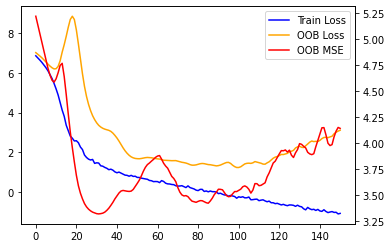

Bootstrap iteration 1 at time 2022-07-06 13:31:10.258339
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.6832475662231445, MSE: 2.2484562397003174
Epoch: 0, Loss: 6.475532531738281, OOB Loss: 6.140190124511719, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.6412193775177, MSE: 1.5799344778060913
Epoch: 40, Loss: 0.8106424808502197, OOB Loss: 0.9334571361541748, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.083254337310791, MSE: 1.5346165895462036
Epoch: 80, Loss: -0.17511606216430664, OOB Loss: 1.626434326171875, LR: 0.00040823971994699836
Early stopped, best epoch: 33, train loss: 1.0369470119476318, best OOB loss: 0.8560030460357666, LR: 0.0004041726062379909


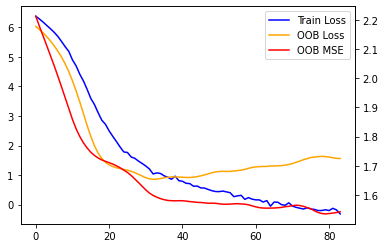

Bootstrap iteration 2 at time 2022-07-06 13:31:17.247605
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.268923759460449, MSE: 2.465930223464966
Epoch: 0, Loss: 6.809595584869385, OOB Loss: 6.587326526641846, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.106337547302246, MSE: 1.8313323259353638
Epoch: 40, Loss: 0.8366787433624268, OOB Loss: 0.7733714580535889, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6756279468536377, MSE: 1.8041187524795532
Epoch: 80, Loss: 0.07439875602722168, OOB Loss: 0.6094858646392822, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.44682240486145, MSE: 1.832480549812317
Epoch: 120, Loss: -0.5905978679656982, OOB Loss: 0.7331297397613525, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: -0.20272445678710938, best OOB loss: 0.5577678680419922, LR: 0.0003504309235993095


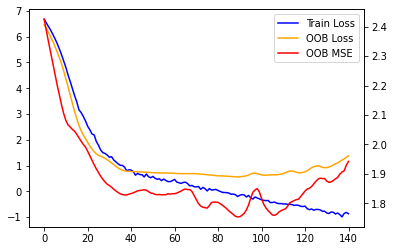

Bootstrap iteration 3 at time 2022-07-06 13:31:28.689078
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.644786834716797, MSE: 5.692348480224609
Epoch: 0, Loss: 7.202455520629883, OOB Loss: 7.430856227874756, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9770839214324951, MSE: 2.8265507221221924
Epoch: 40, Loss: 0.8414106369018555, OOB Loss: 1.4677271842956543, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.823578357696533, MSE: 2.765561580657959
Epoch: 80, Loss: -0.158721923828125, OOB Loss: 1.6469950675964355, LR: 0.00040823971994699836
Early stopped, best epoch: 45, train loss: 0.779456377029419, best OOB loss: 1.4404804706573486, LR: 0.0003922127676914776


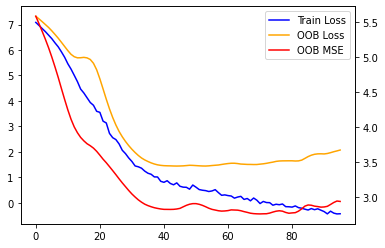

Bootstrap iteration 4 at time 2022-07-06 13:31:36.385805
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.4727396965026855, MSE: 4.324019908905029
Epoch: 0, Loss: 7.067019939422607, OOB Loss: 7.298166275024414, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2063062191009521, MSE: 2.7355735301971436
Epoch: 40, Loss: 0.8443231582641602, OOB Loss: 1.996006727218628, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.853821039199829, MSE: 2.903580665588379
Epoch: 80, Loss: -0.21503496170043945, OOB Loss: 2.0320279598236084, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.391895294189453, MSE: 2.954313039779663
Epoch: 120, Loss: -0.75486159324646, OOB Loss: 2.324618339538574, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: 0.011174201965332031, best OOB loss: 1.9089410305023193, LR: 0.0003684209652939625


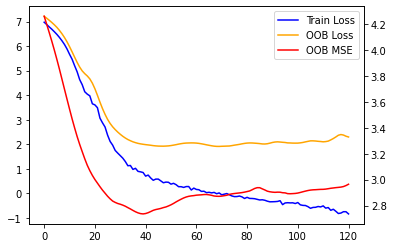

Bootstrap iteration 5 at time 2022-07-06 13:31:46.062572
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -8.255295753479004, MSE: 3.4076662063598633
Epoch: 0, Loss: 8.589742660522461, OOB Loss: 8.49176025390625, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9956836700439453, MSE: 2.453058958053589
Epoch: 40, Loss: 0.9547865390777588, OOB Loss: 2.2214016914367676, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.140151262283325, MSE: 2.549558401107788
Epoch: 80, Loss: -0.11616683006286621, OOB Loss: 2.2612106800079346, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.5036752223968506, best OOB loss: 1.7764363288879395, LR: 0.0003854003082267038


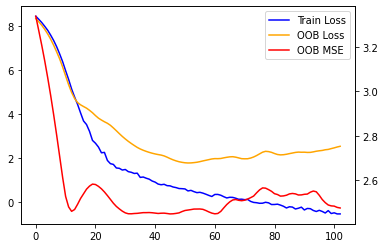

Bootstrap iteration 6 at time 2022-07-06 13:31:54.472500
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.107846260070801, MSE: 3.162400245666504
Epoch: 0, Loss: 6.890056133270264, OOB Loss: 6.671201705932617, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7354358434677124, MSE: 1.9299112558364868
Epoch: 40, Loss: 0.8744349479675293, OOB Loss: 1.2417353391647339, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.220675468444824, MSE: 1.8945995569229126
Epoch: 80, Loss: 0.13039827346801758, OOB Loss: 0.9066975116729736, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.129063367843628, MSE: 1.854781150817871
Epoch: 120, Loss: -0.5619387626647949, OOB Loss: 0.8838322162628174, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.9781641960144043, MSE: 1.9272305965423584
Epoch: 160, Loss: -1.2458219528198242, OOB Loss: 1.4697284698486328, LR: 0.0003341547246965484
Early stopped, best epoch: 114, train loss: -0.4898226261138916, best OOB

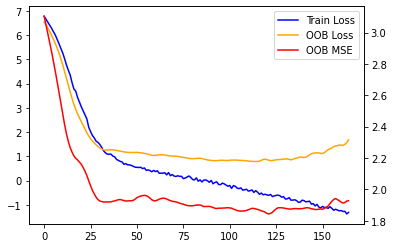

Bootstrap iteration 7 at time 2022-07-06 13:32:07.513836
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.64208459854126, MSE: 4.133899211883545
Epoch: 0, Loss: 6.440750598907471, OOB Loss: 6.47804594039917, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.07912540435791, MSE: 2.7250707149505615
Epoch: 40, Loss: 0.8654890060424805, OOB Loss: 3.6357884407043457, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5997841358184814, MSE: 2.6899685859680176
Epoch: 80, Loss: -0.12064194679260254, OOB Loss: 3.0498316287994385, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.42469143867492676, best OOB loss: 2.356229305267334, LR: 0.0003863662237861692


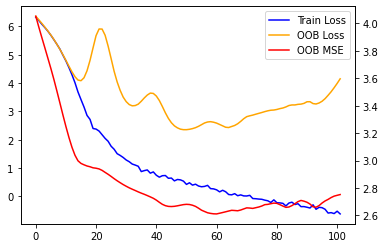

Bootstrap iteration 8 at time 2022-07-06 13:32:15.221209
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.09401273727417, MSE: 4.544827938079834
Epoch: 0, Loss: 6.699751377105713, OOB Loss: 6.806182384490967, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8050880432128906, MSE: 3.1984362602233887
Epoch: 40, Loss: 0.9529323577880859, OOB Loss: 1.3022606372833252, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7023069858551025, MSE: 2.6530957221984863
Epoch: 80, Loss: 0.09640288352966309, OOB Loss: 0.7564539909362793, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.7218050956726074, MSE: 2.8337624073028564
Epoch: 120, Loss: -0.5778098106384277, OOB Loss: 2.148270606994629, LR: 0.00036934432610923556
Early stopped, best epoch: 77, train loss: 0.18885207176208496, best OOB loss: 0.747039794921875, LR: 0.0003620217526757433


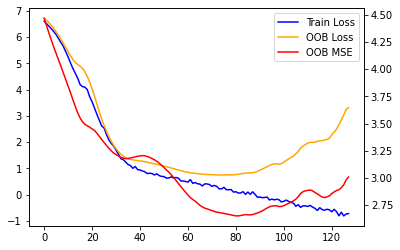

Bootstrap iteration 9 at time 2022-07-06 13:32:25.611572
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.998395919799805, MSE: 3.0857927799224854
Epoch: 0, Loss: 7.528039932250977, OOB Loss: 7.279325485229492, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7292428016662598, MSE: 2.4515416622161865
Epoch: 40, Loss: 0.7800519466400146, OOB Loss: 2.734015464782715, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8952600955963135, MSE: 2.3092052936553955
Epoch: 80, Loss: 0.03783845901489258, OOB Loss: 1.800995111465454, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.33492136001586914, best OOB loss: 1.6168873310089111, LR: 0.0003834757154374967


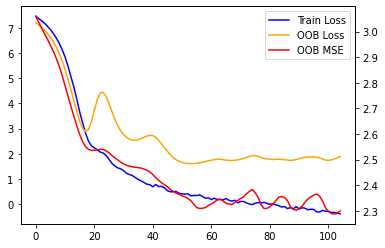

Bootstrap iteration 10 at time 2022-07-06 13:32:33.614893
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.260863304138184, MSE: 3.8708696365356445
Epoch: 0, Loss: 6.91195821762085, OOB Loss: 6.999265670776367, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8802342414855957, MSE: 3.0774424076080322
Epoch: 40, Loss: 0.9514024257659912, OOB Loss: 2.082042932510376, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.399689197540283, MSE: 2.922867774963379
Epoch: 80, Loss: 0.035573720932006836, OOB Loss: 1.4001059532165527, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.18839168548584, MSE: 2.900986671447754
Epoch: 120, Loss: -0.6754746437072754, OOB Loss: 1.9112482070922852, LR: 0.00036934432610923556
Early stopped, best epoch: 78, train loss: 0.04725217819213867, best OOB loss: 1.3855607509613037, LR: 0.00036111669829405396


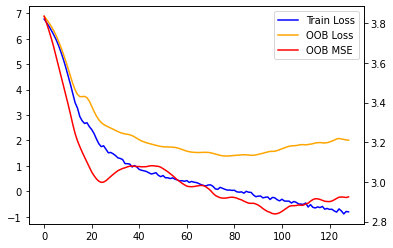

Bootstrap iteration 11 at time 2022-07-06 13:32:44.115989
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.934366703033447, MSE: 2.041097640991211
Epoch: 0, Loss: 6.6304545402526855, OOB Loss: 6.256382942199707, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.8410451412200928, MSE: 1.5838199853897095
Epoch: 40, Loss: 1.1824426651000977, OOB Loss: 0.1955273151397705, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.395329475402832, MSE: 1.5182915925979614
Epoch: 80, Loss: 0.29843783378601074, OOB Loss: -0.23516035079956055, LR: 0.00040823971994699836
Early stopped, best epoch: 90, train loss: 0.08884429931640625, best OOB loss: -0.29233646392822266, LR: 0.0003931957570841881


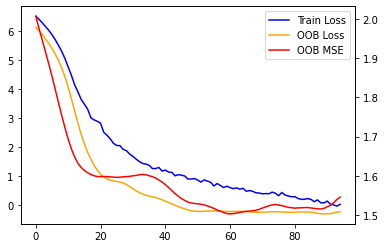

Bootstrap iteration 12 at time 2022-07-06 13:32:52.077774
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.611461162567139, MSE: 3.8251636028289795
Epoch: 0, Loss: 7.18026065826416, OOB Loss: 7.02619743347168, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8805900812149048, MSE: 2.6736576557159424
Epoch: 40, Loss: 0.8425569534301758, OOB Loss: 2.796825885772705, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7308456897735596, MSE: 2.600693702697754
Epoch: 80, Loss: -0.11775588989257812, OOB Loss: 2.6650397777557373, LR: 0.00040823971994699836
Early stopped, best epoch: 59, train loss: 0.36746835708618164, best OOB loss: 2.275430202484131, LR: 0.00037870617638352256


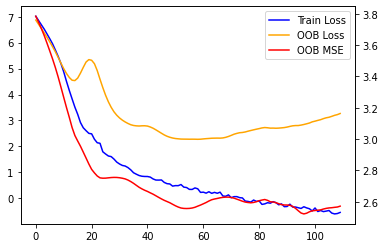

Bootstrap iteration 13 at time 2022-07-06 13:33:00.731036
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.313887119293213, MSE: 3.01037859916687
Epoch: 0, Loss: 7.076816082000732, OOB Loss: 6.757355213165283, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.257091522216797, MSE: 1.8947643041610718
Epoch: 40, Loss: 1.0214440822601318, OOB Loss: 1.23573637008667, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.334563732147217, MSE: 1.8011735677719116
Epoch: 80, Loss: 0.10017585754394531, OOB Loss: 1.2515172958374023, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 5.408599853515625, MSE: 1.8266116380691528
Epoch: 120, Loss: -0.6129698753356934, OOB Loss: 2.621344566345215, LR: 0.00036934432610923556
Early stopped, best epoch: 71, train loss: 0.28236937522888184, best OOB loss: 0.8540735244750977, LR: 0.0003674999128807276


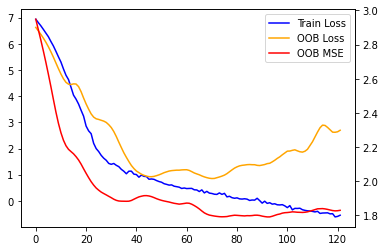

Bootstrap iteration 14 at time 2022-07-06 13:33:10.258622
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.1202263832092285, MSE: 1.7635623216629028
Epoch: 0, Loss: 7.746955394744873, OOB Loss: 7.313671588897705, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7308075428009033, MSE: 1.205254077911377
Epoch: 40, Loss: 1.1455094814300537, OOB Loss: -0.10257816314697266, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.124756097793579, MSE: 1.1580543518066406
Epoch: 80, Loss: 0.22948884963989258, OOB Loss: -0.15532994270324707, LR: 0.00040823971994699836
Early stopped, best epoch: 86, train loss: 0.08356285095214844, best OOB loss: -0.2090294361114502, LR: 0.00040215426928559


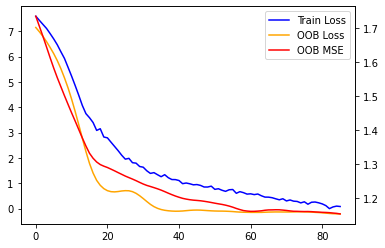

Bootstrap iteration 15 at time 2022-07-06 13:33:17.400943
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.8973259925842285, MSE: 4.106176853179932
Epoch: 0, Loss: 7.322315692901611, OOB Loss: 7.340106010437012, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5098330974578857, MSE: 3.438004493713379
Epoch: 40, Loss: 0.63211989402771, OOB Loss: 3.4268038272857666, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.930914878845215, MSE: 3.7324142456054688
Epoch: 80, Loss: -0.19997143745422363, OOB Loss: 3.4058899879455566, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.3651883602142334, best OOB loss: 2.7459611892700195, LR: 0.00038733456018663577


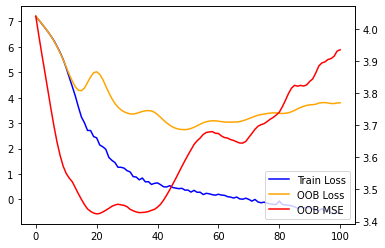

Bootstrap iteration 16 at time 2022-07-06 13:33:25.110478
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.362620830535889, MSE: 3.0170035362243652
Epoch: 0, Loss: 7.161026477813721, OOB Loss: 6.812728404998779, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0031301975250244, MSE: 1.86141037940979
Epoch: 40, Loss: 1.0248968601226807, OOB Loss: 0.6440119743347168, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7372055053710938, MSE: 1.8412410020828247
Epoch: 80, Loss: 0.09070038795471191, OOB Loss: 0.5697882175445557, LR: 0.00040823971994699836
Early stopped, best epoch: 53, train loss: 0.5431954860687256, best OOB loss: 0.4463005065917969, LR: 0.00038443680745613704


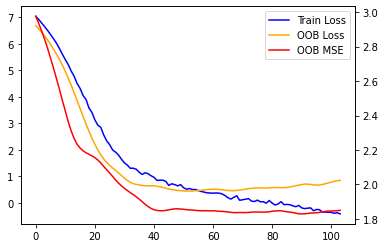

Bootstrap iteration 17 at time 2022-07-06 13:33:34.081385
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.946561336517334, MSE: 5.051118850708008
Epoch: 0, Loss: 7.419637203216553, OOB Loss: 7.728516101837158, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4872101545333862, MSE: 3.706479787826538
Epoch: 40, Loss: 0.8739888668060303, OOB Loss: 3.5518479347229004, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.175096035003662, MSE: 3.6681301593780518
Epoch: 80, Loss: -0.07442355155944824, OOB Loss: 2.3191728591918945, LR: 0.00040823971994699836
Early stopped, best epoch: 64, train loss: 0.18860721588134766, best OOB loss: 1.893568754196167, LR: 0.00037399595921584153


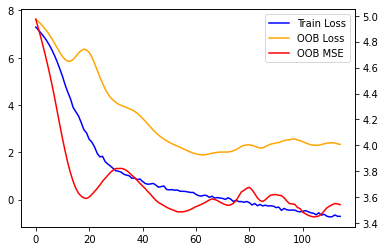

Bootstrap iteration 18 at time 2022-07-06 13:33:43.224401
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.425905227661133, MSE: 3.2803709506988525
Epoch: 0, Loss: 7.143249034881592, OOB Loss: 6.8014750480651855, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.483081102371216, MSE: 2.3320472240448
Epoch: 40, Loss: 0.8215491771697998, OOB Loss: 2.930745840072632, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.884950876235962, MSE: 2.2838187217712402
Epoch: 80, Loss: -0.02789163589477539, OOB Loss: 2.2486250400543213, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.464203357696533, MSE: 2.2372403144836426
Epoch: 120, Loss: -0.603417158126831, OOB Loss: 2.4100050926208496, LR: 0.00036934432610923556
Early stopped, best epoch: 107, train loss: -0.42539548873901367, best OOB loss: 2.0802295207977295, LR: 0.0003358317846712504


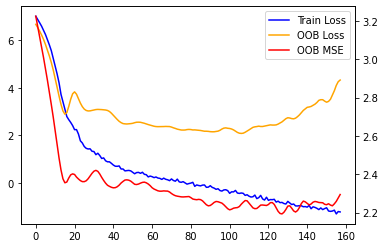

Bootstrap iteration 19 at time 2022-07-06 13:33:55.017417
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.9869537353515625, MSE: 2.6699423789978027
Epoch: 0, Loss: 5.9100236892700195, OOB Loss: 5.502965927124023, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.9629459381103516, MSE: 1.7109148502349854
Epoch: 40, Loss: 0.78240966796875, OOB Loss: 0.4832613468170166, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5819242000579834, MSE: 1.72481369972229
Epoch: 80, Loss: -0.05859208106994629, OOB Loss: 0.7985236644744873, LR: 0.00040823971994699836
Early stopped, best epoch: 39, train loss: 0.8282535076141357, best OOB loss: 0.47989320755004883, LR: 0.00039814778225889965


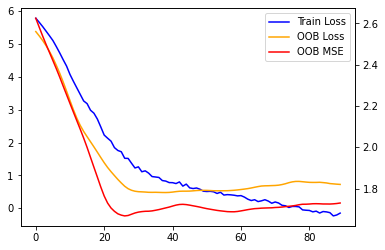

Bootstrap iteration 20 at time 2022-07-06 13:34:02.158356
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.076355934143066, MSE: 1.8705719709396362
Epoch: 0, Loss: 6.911867141723633, OOB Loss: 6.33645486831665, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8335745334625244, MSE: 1.301381230354309
Epoch: 40, Loss: 1.1342158317565918, OOB Loss: 0.3049290180206299, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7371931076049805, MSE: 1.2750484943389893
Epoch: 80, Loss: 0.21685409545898438, OOB Loss: 0.09754014015197754, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1075034141540527, MSE: 1.310488224029541
Epoch: 120, Loss: -0.429440975189209, OOB Loss: 0.23752498626708984, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.21284008026123047, best OOB loss: 0.09410738945007324, LR: 0.00036021390654831885


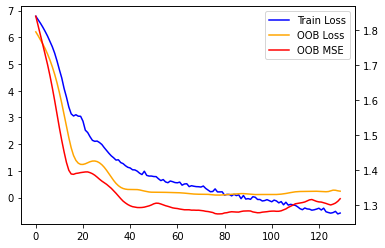

Bootstrap iteration 21 at time 2022-07-06 13:34:12.767709
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.223184585571289, MSE: 3.0688846111297607
Epoch: 0, Loss: 6.857010841369629, OOB Loss: 6.630093574523926, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1912267208099365, MSE: 1.9955105781555176
Epoch: 40, Loss: 0.8055884838104248, OOB Loss: 0.8422350883483887, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7085540294647217, MSE: 2.019153594970703
Epoch: 80, Loss: -0.03606724739074707, OOB Loss: 0.8616509437561035, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.2708394527435303, best OOB loss: 0.7659988403320312, LR: 0.00037493329244695894


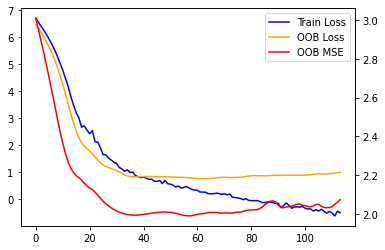

Bootstrap iteration 22 at time 2022-07-06 13:34:21.697189
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.348785400390625, MSE: 1.814950942993164
Epoch: 0, Loss: 7.022550106048584, OOB Loss: 6.60333776473999, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7980258464813232, MSE: 1.2035572528839111
Epoch: 40, Loss: 1.1736340522766113, OOB Loss: -0.08704757690429688, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.2374188899993896, MSE: 1.1291825771331787
Epoch: 80, Loss: 0.20375370979309082, OOB Loss: -0.22298860549926758, LR: 0.00040823971994699836
Early stopped, best epoch: 76, train loss: 0.1986992359161377, best OOB loss: -0.23360133171081543, LR: 0.0004001460114033451


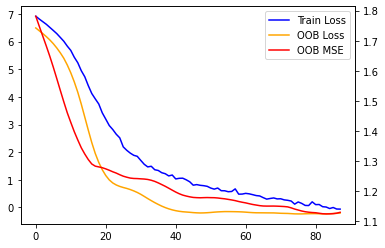

Bootstrap iteration 23 at time 2022-07-06 13:34:29.407510
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.596579074859619, MSE: 2.9645564556121826
Epoch: 0, Loss: 7.15908145904541, OOB Loss: 7.034963607788086, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7189490795135498, MSE: 2.3051249980926514
Epoch: 40, Loss: 0.8340263366699219, OOB Loss: 1.0750036239624023, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.434194326400757, MSE: 2.2935543060302734
Epoch: 80, Loss: -0.06498956680297852, OOB Loss: 0.8159112930297852, LR: 0.00040823971994699836
Early stopped, best epoch: 57, train loss: 0.41551995277404785, best OOB loss: 0.75677490234375, LR: 0.00038060683174957196


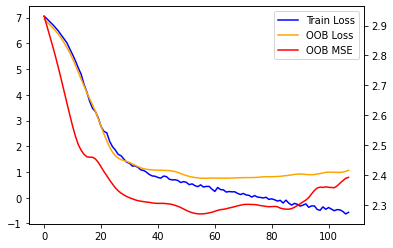

Bootstrap iteration 24 at time 2022-07-06 13:34:38.098536
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.025015830993652, MSE: 3.0072364807128906
Epoch: 0, Loss: 7.525065898895264, OOB Loss: 7.339875221252441, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4175218343734741, MSE: 1.9909462928771973
Epoch: 40, Loss: 0.9303855895996094, OOB Loss: 0.8785015344619751, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1499698162078857, MSE: 1.9244751930236816
Epoch: 80, Loss: 0.04389047622680664, OOB Loss: 0.6299512386322021, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.7994847297668457, MSE: 2.1835148334503174
Epoch: 120, Loss: -0.5833675861358643, OOB Loss: 0.6934041976928711, LR: 0.00036934432610923556
Early stopped, best epoch: 87, train loss: -0.1004035472869873, best OOB loss: 0.6086502075195312, LR: 0.00035307235164682273


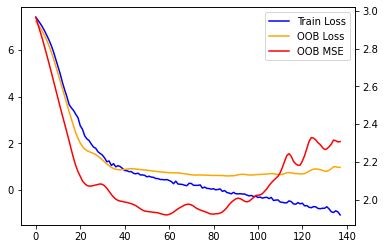

Bootstrap iteration 25 at time 2022-07-06 13:34:49.091507
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.474640846252441, MSE: 4.76975154876709
Epoch: 0, Loss: 6.285599708557129, OOB Loss: 6.328127861022949, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8264083862304688, MSE: 2.886747360229492
Epoch: 40, Loss: 0.7654945850372314, OOB Loss: 1.757441759109497, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3901560306549072, MSE: 2.9550154209136963
Epoch: 80, Loss: -0.15696358680725098, OOB Loss: 1.8801705837249756, LR: 0.00040823971994699836
Early stopped, best epoch: 38, train loss: 0.9118843078613281, best OOB loss: 1.7228891849517822, LR: 0.00039914564637483674


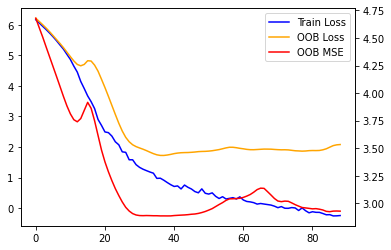

Bootstrap iteration 26 at time 2022-07-06 13:34:56.180863
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.041529178619385, MSE: 2.7170803546905518
Epoch: 0, Loss: 7.5472493171691895, OOB Loss: 7.3268818855285645, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0599472522735596, MSE: 2.1345176696777344
Epoch: 40, Loss: 0.8987448215484619, OOB Loss: 1.3302361965179443, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8677101135253906, MSE: 2.099452257156372
Epoch: 80, Loss: -0.07603025436401367, OOB Loss: 1.226388931274414, LR: 0.00040823971994699836
Early stopped, best epoch: 62, train loss: 0.3243401050567627, best OOB loss: 1.0541465282440186, LR: 0.00037587297488416934


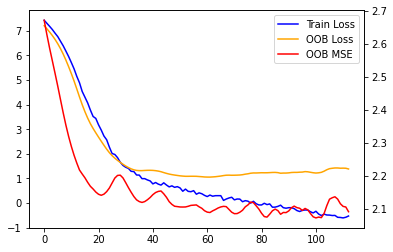

Bootstrap iteration 27 at time 2022-07-06 13:35:05.219846
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.7485833168029785, MSE: 2.6658473014831543
Epoch: 0, Loss: 7.495742321014404, OOB Loss: 7.1174187660217285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5942435264587402, MSE: 1.496719479560852
Epoch: 40, Loss: 1.1709721088409424, OOB Loss: 0.1286334991455078, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3288590908050537, MSE: 1.4553759098052979
Epoch: 80, Loss: 0.33827710151672363, OOB Loss: 0.013990640640258789, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.7417550086975098, best OOB loss: -0.04948925971984863, LR: 0.00038733456018663577


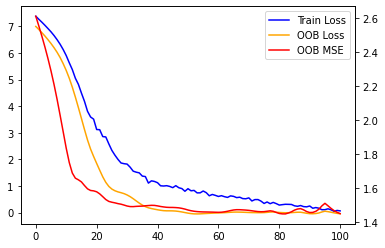

Bootstrap iteration 28 at time 2022-07-06 13:35:13.482371
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.285337924957275, MSE: 6.730997562408447
Epoch: 0, Loss: 6.898528099060059, OOB Loss: 7.357542514801025, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4822965860366821, MSE: 3.882128953933716
Epoch: 40, Loss: 0.7107255458831787, OOB Loss: 4.78330135345459, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.48921799659729, MSE: 3.569027900695801
Epoch: 80, Loss: -0.26474905014038086, OOB Loss: 2.8911783695220947, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.1523611545562744, MSE: 4.152956008911133
Epoch: 120, Loss: -0.8900754451751709, OOB Loss: 3.5117228031158447, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: -0.2316131591796875, best OOB loss: 2.874490261077881, LR: 0.00035751905063161196


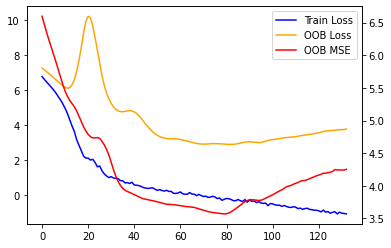

Bootstrap iteration 29 at time 2022-07-06 13:35:23.624519
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.117298603057861, MSE: 4.396451950073242
Epoch: 0, Loss: 6.017981052398682, OOB Loss: 6.3779473304748535, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.5902659893035889, MSE: 2.7207884788513184
Epoch: 40, Loss: 0.6465857028961182, OOB Loss: 2.0254194736480713, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9170421361923218, MSE: 2.6354455947875977
Epoch: 80, Loss: -0.2129068374633789, OOB Loss: 1.7884026765823364, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.5030312538146973, MSE: 2.919908046722412
Epoch: 120, Loss: -0.782832145690918, OOB Loss: 2.297471046447754, LR: 0.00036934432610923556
Early stopped, best epoch: 76, train loss: -0.13099455833435059, best OOB loss: 1.734180212020874, LR: 0.0003629290753641537


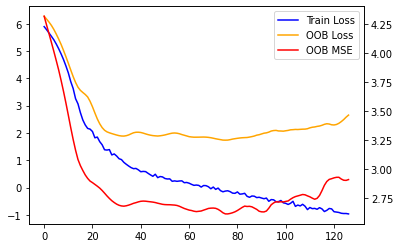

Bootstrap iteration 30 at time 2022-07-06 13:35:33.487580
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.173595905303955, MSE: 3.7362608909606934
Epoch: 0, Loss: 7.07810640335083, OOB Loss: 6.831236362457275, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9261540174484253, MSE: 1.9774816036224365
Epoch: 40, Loss: 0.6924898624420166, OOB Loss: 1.6388190984725952, LR: 0.00045123116063007594
Early stopped, best epoch: 25, train loss: 2.076245069503784, best OOB loss: 1.552129864692688, LR: 0.00041234776026425864


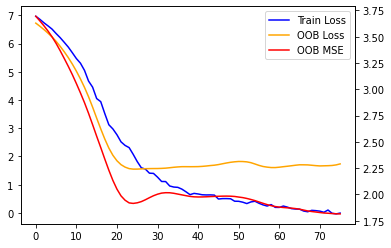

Bootstrap iteration 31 at time 2022-07-06 13:35:39.612043
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.1346893310546875, MSE: 3.3197832107543945
Epoch: 0, Loss: 6.815740585327148, OOB Loss: 6.631720542907715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4918205738067627, MSE: 2.0712966918945312
Epoch: 40, Loss: 0.8807723522186279, OOB Loss: 1.205561637878418, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7791690826416016, MSE: 2.0879905223846436
Epoch: 80, Loss: -0.04823780059814453, OOB Loss: 0.9038193225860596, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.711608409881592, MSE: 2.2492592334747314
Epoch: 120, Loss: -0.6008121967315674, OOB Loss: 1.773820400238037, LR: 0.00036934432610923556
Early stopped, best epoch: 72, train loss: 0.13866233825683594, best OOB loss: 0.8856444358825684, LR: 0.0003665811630985258


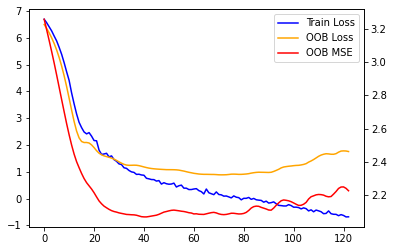

Bootstrap iteration 32 at time 2022-07-06 13:35:49.628293
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.930499076843262, MSE: 2.0082011222839355
Epoch: 0, Loss: 5.857300758361816, OOB Loss: 5.464609146118164, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3487846851348877, MSE: 1.6068967580795288
Epoch: 40, Loss: 0.8193964958190918, OOB Loss: 0.882026195526123, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.536012649536133, MSE: 1.651135802268982
Epoch: 80, Loss: -0.042909860610961914, OOB Loss: 0.8314898014068604, LR: 0.00040823971994699836
Early stopped, best epoch: 64, train loss: 0.325639009475708, best OOB loss: 0.7655825614929199, LR: 0.00037399595921584153


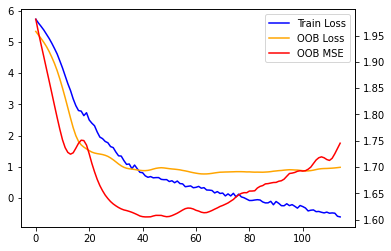

Bootstrap iteration 33 at time 2022-07-06 13:35:58.670477
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.5165228843688965, MSE: 3.0834147930145264
Epoch: 0, Loss: 7.131616592407227, OOB Loss: 6.867286205291748, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.113910675048828, MSE: 1.8870549201965332
Epoch: 40, Loss: 0.9417300224304199, OOB Loss: 0.8931748867034912, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5528564453125, MSE: 1.8711585998535156
Epoch: 80, Loss: 0.027118921279907227, OOB Loss: 0.624640941619873, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.344444751739502, MSE: 1.9028822183609009
Epoch: 120, Loss: -0.6278328895568848, OOB Loss: 0.7641324996948242, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.053437232971191406, best OOB loss: 0.6208124160766602, LR: 0.00036021390654831885


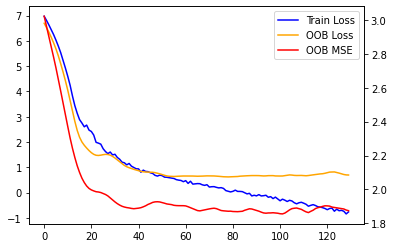

Bootstrap iteration 34 at time 2022-07-06 13:36:09.032846
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.450296401977539, MSE: 1.7475759983062744
Epoch: 0, Loss: 7.923765659332275, OOB Loss: 7.607372760772705, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.5898652076721191, MSE: 1.3138710260391235
Epoch: 40, Loss: 1.1024954319000244, OOB Loss: 0.3186269998550415, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.503675937652588, MSE: 1.2565784454345703
Epoch: 80, Loss: 0.2772526741027832, OOB Loss: -0.01383519172668457, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.138942241668701, MSE: 1.2568776607513428
Epoch: 120, Loss: -0.4225468635559082, OOB Loss: -0.10010480880737305, LR: 0.00036934432610923556
Early stopped, best epoch: 114, train loss: -0.22621774673461914, best OOB loss: -0.13562512397766113, LR: 0.0003638386720442643


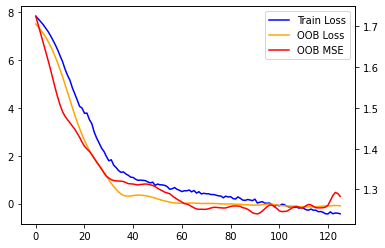

Bootstrap iteration 35 at time 2022-07-06 13:36:19.588749
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.634176254272461, MSE: 5.580713748931885
Epoch: 0, Loss: 7.080575942993164, OOB Loss: 7.2686262130737305, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3160200119018555, MSE: 3.993525981903076
Epoch: 40, Loss: 0.6410267353057861, OOB Loss: 5.111837387084961, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.173102855682373, MSE: 4.711479663848877
Epoch: 80, Loss: -0.2497880458831787, OOB Loss: 3.482326030731201, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.306638717651367, MSE: 5.1753363609313965
Epoch: 120, Loss: -0.8628814220428467, OOB Loss: 5.2628068923950195, LR: 0.00036934432610923556
Early stopped, best epoch: 76, train loss: -0.14402008056640625, best OOB loss: 3.3262484073638916, LR: 0.0003629290753641537


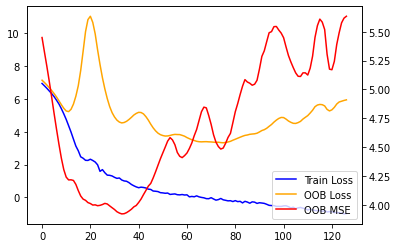

Bootstrap iteration 36 at time 2022-07-06 13:36:29.188009
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.062406063079834, MSE: 2.8420379161834717
Epoch: 0, Loss: 6.895262718200684, OOB Loss: 6.469110488891602, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4782214164733887, MSE: 1.6723313331604004
Epoch: 40, Loss: 0.920238733291626, OOB Loss: 0.5605025291442871, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.187859058380127, MSE: 1.8628431558609009
Epoch: 80, Loss: 0.0942087173461914, OOB Loss: 0.9328856468200684, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.585773229598999, best OOB loss: 0.5253849029541016, LR: 0.0003854003082267038


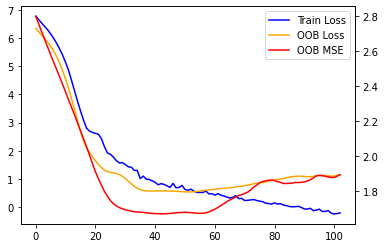

Bootstrap iteration 37 at time 2022-07-06 13:36:37.273670
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.019687175750732, MSE: 4.6583075523376465
Epoch: 0, Loss: 6.754495620727539, OOB Loss: 6.878629207611084, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.743952989578247, MSE: 3.1997435092926025
Epoch: 40, Loss: 0.8244054317474365, OOB Loss: 1.8549282550811768, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3782734870910645, MSE: 3.3614377975463867
Epoch: 80, Loss: 0.04040241241455078, OOB Loss: 1.6635627746582031, LR: 0.00040823971994699836
Early stopped, best epoch: 60, train loss: 0.4292905330657959, best OOB loss: 1.5241875648498535, LR: 0.00037775941094256375


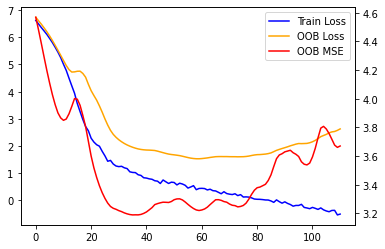

Bootstrap iteration 38 at time 2022-07-06 13:36:46.093722
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.3383355140686035, MSE: 4.713674068450928
Epoch: 0, Loss: 6.961099624633789, OOB Loss: 6.955623149871826, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.0238702297210693, MSE: 2.6829006671905518
Epoch: 40, Loss: 0.892874002456665, OOB Loss: 2.5531861782073975, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.2016420364379883, MSE: 2.453374147415161
Epoch: 80, Loss: 0.14034724235534668, OOB Loss: 1.5640373229980469, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.956491708755493, MSE: 2.39426589012146
Epoch: 120, Loss: -0.5405392646789551, OOB Loss: 2.180279016494751, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: 0.16080069541931152, best OOB loss: 1.5498816967010498, LR: 0.00035751905063161196


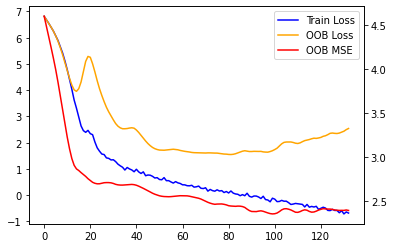

Bootstrap iteration 39 at time 2022-07-06 13:36:56.506917
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.409648418426514, MSE: 2.3801071643829346
Epoch: 0, Loss: 7.037697792053223, OOB Loss: 6.705826759338379, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.096095323562622, MSE: 1.6579816341400146
Epoch: 40, Loss: 1.0705671310424805, OOB Loss: 0.23573684692382812, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.863360643386841, MSE: 1.6557121276855469
Epoch: 80, Loss: 0.17816877365112305, OOB Loss: 0.08112859725952148, LR: 0.00040823971994699836
Early stopped, best epoch: 59, train loss: 0.6118834018707275, best OOB loss: 0.02656388282775879, LR: 0.00037870617638352256


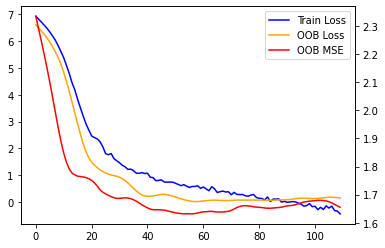

Bootstrap iteration 40 at time 2022-07-06 13:37:05.308996
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.688021183013916, MSE: 5.577893257141113
Epoch: 0, Loss: 7.1947855949401855, OOB Loss: 7.43115758895874, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9043854475021362, MSE: 3.558274507522583
Epoch: 40, Loss: 0.7284409999847412, OOB Loss: 4.013372898101807, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.572514533996582, MSE: 3.813228130340576
Epoch: 80, Loss: -0.11722302436828613, OOB Loss: 3.045624256134033, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1667490005493164, MSE: 4.004201412200928
Epoch: 120, Loss: -0.7963724136352539, OOB Loss: 4.553996562957764, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: -0.11722302436828613, best OOB loss: 3.045624256134033, LR: 0.00035931337178194805


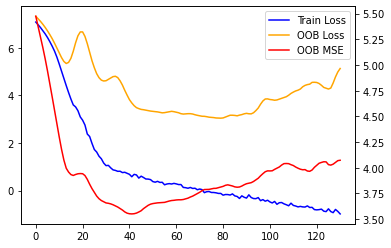

Bootstrap iteration 41 at time 2022-07-06 13:37:15.475705
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.482705116271973, MSE: 4.409422874450684
Epoch: 0, Loss: 7.1482977867126465, OOB Loss: 7.009024620056152, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.677939772605896, MSE: 2.4804770946502686
Epoch: 40, Loss: 0.6338555812835693, OOB Loss: 1.6674515008926392, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.024592161178589, MSE: 2.4260566234588623
Epoch: 80, Loss: -0.10420060157775879, OOB Loss: 1.9048101902008057, LR: 0.00040823971994699836
Early stopped, best epoch: 46, train loss: 0.47821855545043945, best OOB loss: 1.4635692834854126, LR: 0.00039123223577224893


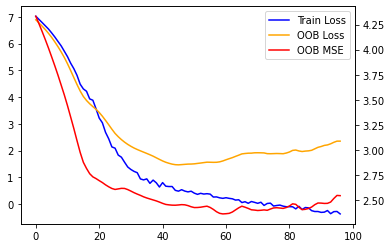

Bootstrap iteration 42 at time 2022-07-06 13:37:23.251053
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.91141939163208, MSE: 2.84106183052063
Epoch: 0, Loss: 6.533275604248047, OOB Loss: 6.32691764831543, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.02728533744812, MSE: 1.9476374387741089
Epoch: 40, Loss: 1.07476806640625, OOB Loss: 1.1695466041564941, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7175509929656982, MSE: 1.8590149879455566
Epoch: 80, Loss: 0.05254554748535156, OOB Loss: 1.0348660945892334, LR: 0.00040823971994699836
Early stopped, best epoch: 57, train loss: 0.5269522666931152, best OOB loss: 0.8092813491821289, LR: 0.00038060683174957196


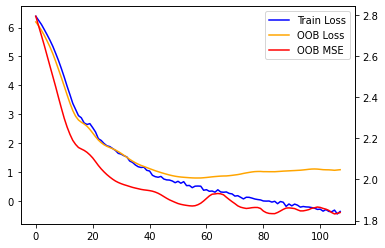

Bootstrap iteration 43 at time 2022-07-06 13:37:32.187553
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.132625102996826, MSE: 2.75430965423584
Epoch: 0, Loss: 6.772417068481445, OOB Loss: 6.471202850341797, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.005223274230957, MSE: 1.857898235321045
Epoch: 40, Loss: 0.9990890026092529, OOB Loss: 0.6316065788269043, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3250536918640137, MSE: 1.7607659101486206
Epoch: 80, Loss: 0.030736207962036133, OOB Loss: 0.5870623588562012, LR: 0.00040823971994699836
Early stopped, best epoch: 58, train loss: 0.4664115905761719, best OOB loss: 0.4364285469055176, LR: 0.00037965531467019806


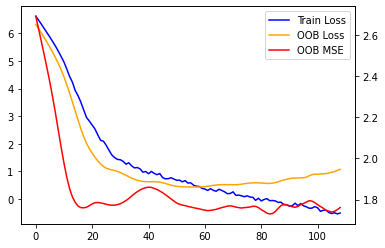

Bootstrap iteration 44 at time 2022-07-06 13:37:40.798169
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.851321697235107, MSE: 1.7723246812820435
Epoch: 0, Loss: 7.4232072830200195, OOB Loss: 7.0501556396484375, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1107869148254395, MSE: 1.3869893550872803
Epoch: 40, Loss: 1.0256977081298828, OOB Loss: 0.6274116039276123, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.522935152053833, MSE: 1.3644177913665771
Epoch: 80, Loss: 0.14579558372497559, OOB Loss: 0.5966980457305908, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.8268089294433594, MSE: 1.3457205295562744
Epoch: 120, Loss: -0.5307033061981201, OOB Loss: 0.6823110580444336, LR: 0.00036934432610923556
Early stopped, best epoch: 83, train loss: 0.0022351741790771484, best OOB loss: 0.5743064880371094, LR: 0.00035662525300503295


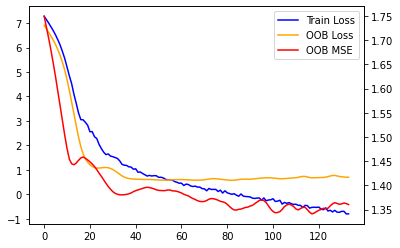

Bootstrap iteration 45 at time 2022-07-06 13:37:51.220111
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.232004642486572, MSE: 2.5208966732025146
Epoch: 0, Loss: 6.936500549316406, OOB Loss: 6.5828752517700195, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.456794023513794, MSE: 1.678609848022461
Epoch: 40, Loss: 1.2243345975875854, OOB Loss: 0.5191171169281006, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.153651714324951, MSE: 1.778157353401184
Epoch: 80, Loss: 0.13163518905639648, OOB Loss: 0.6923842430114746, LR: 0.00040823971994699836
Early stopped, best epoch: 58, train loss: 0.5946917533874512, best OOB loss: 0.34632444381713867, LR: 0.00037965531467019806


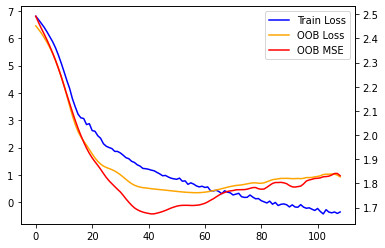

Bootstrap iteration 46 at time 2022-07-06 13:38:00.049040
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.449840545654297, MSE: 2.513082504272461
Epoch: 0, Loss: 7.0487213134765625, OOB Loss: 6.854276180267334, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5414388179779053, MSE: 1.9399386644363403
Epoch: 40, Loss: 1.0578739643096924, OOB Loss: 0.45409703254699707, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.488048791885376, MSE: 1.7368085384368896
Epoch: 80, Loss: 0.2805917263031006, OOB Loss: -0.04256439208984375, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.397392272949219, MSE: 1.7684670686721802
Epoch: 120, Loss: -0.5124187469482422, OOB Loss: 0.15855646133422852, LR: 0.00036934432610923556
Early stopped, best epoch: 96, train loss: -0.0223391056060791, best OOB loss: -0.14310812950134277, LR: 0.0003620217526757433


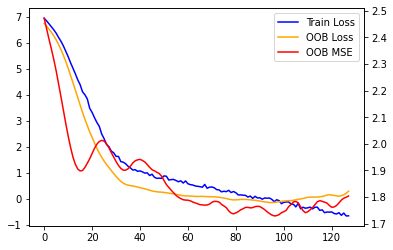

Bootstrap iteration 47 at time 2022-07-06 13:38:10.855051
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.972061634063721, MSE: 2.1973750591278076
Epoch: 0, Loss: 6.583159923553467, OOB Loss: 6.277562141418457, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3884549140930176, MSE: 1.8628541231155396
Epoch: 40, Loss: 0.8830573558807373, OOB Loss: 1.110793113708496, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.748781442642212, MSE: 1.76832914352417
Epoch: 80, Loss: 0.03778529167175293, OOB Loss: 1.0419213771820068, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.5801773071289062, best OOB loss: 0.9500205516815186, LR: 0.0003883053234953742


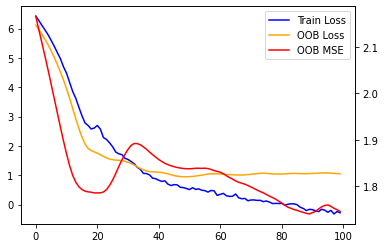

Bootstrap iteration 48 at time 2022-07-06 13:38:18.759821
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.5143818855285645, MSE: 5.074244499206543
Epoch: 0, Loss: 7.149156093597412, OOB Loss: 7.073322772979736, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.636652946472168, MSE: 3.211367607116699
Epoch: 40, Loss: 0.6578822135925293, OOB Loss: 4.261621475219727, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.858306646347046, MSE: 3.150203227996826
Epoch: 80, Loss: -0.20067453384399414, OOB Loss: 3.636915445327759, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.2507610321044922, best OOB loss: 3.0829825401306152, LR: 0.0003863662237861692


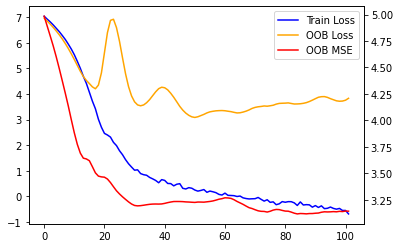

Bootstrap iteration 49 at time 2022-07-06 13:38:26.376658
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.899982452392578, MSE: 4.275486469268799
Epoch: 0, Loss: 6.554782867431641, OOB Loss: 6.714086532592773, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7114564180374146, MSE: 3.010770320892334
Epoch: 40, Loss: 0.44054436683654785, OOB Loss: 2.5697383880615234, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3687872886657715, MSE: 3.1095778942108154
Epoch: 80, Loss: -0.3781604766845703, OOB Loss: 3.151503086090088, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.27695536613464355, best OOB loss: 2.437751054763794, LR: 0.00039025415518281834


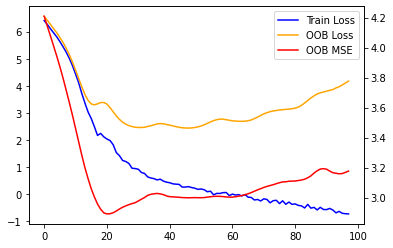

Time 0, 2022-07-06 13:38:34.064284
Time 5, 2022-07-06 13:57:36.058430
Time 10, 2022-07-06 14:16:52.565374
Time 15, 2022-07-06 14:36:39.723544
Time 20, 2022-07-06 14:57:18.189976
Time 25, 2022-07-06 15:17:37.147612
Time 30, 2022-07-06 15:37:46.292149
Time 35, 2022-07-06 15:57:52.102229
Time 40, 2022-07-06 16:17:47.390508
Time 45, 2022-07-06 16:37:14.139414
Time 50, 2022-07-06 16:56:07.300104
Time 55, 2022-07-06 17:13:34.213904
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: -6.670309543609619, MSE: 1.7361929416656494
Epoch: 0, Loss: 7.282065391540527, OOB Loss: 6.8835601806640625, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6402086019515991, MSE: 1.2805728912353516
Epoch: 40, Loss: 1.2391834259033203, OOB Loss: 0.3707331418991089, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.997748613357544, MSE: 1.1803289651870728
Epoch: 80, Loss: 0.2425246238708496, OOB Loss: -0.010657548904418945, LR: 0.00040823971994699836
Early stopped, best epoch: 109, train loss: -0.28287363052368164, best OOB loss: -0.07990145683288574, LR: 0.00037870617638352256


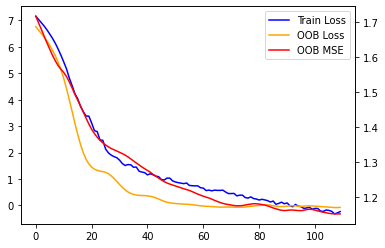

Bootstrap iteration 1 at time 2022-07-06 17:30:57.215264
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.900692462921143, MSE: 4.127163410186768
Epoch: 0, Loss: 6.49926233291626, OOB Loss: 6.63761043548584, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3200747966766357, MSE: 2.974141836166382
Epoch: 40, Loss: 0.5273182392120361, OOB Loss: 3.0579583644866943, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.923640251159668, MSE: 2.794652223587036
Epoch: 80, Loss: -0.28754425048828125, OOB Loss: 2.6502413749694824, LR: 0.00040823971994699836
Early stopped, best epoch: 64, train loss: -0.013276100158691406, best OOB loss: 2.461141586303711, LR: 0.00037399595921584153


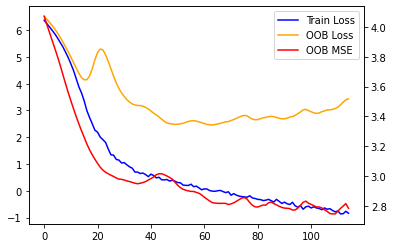

Bootstrap iteration 2 at time 2022-07-06 17:31:06.165964
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.071593761444092, MSE: 3.1173810958862305
Epoch: 0, Loss: 6.916524887084961, OOB Loss: 6.633276462554932, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0789105892181396, MSE: 2.002610445022583
Epoch: 40, Loss: 1.1594831943511963, OOB Loss: 0.8210117816925049, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9335625171661377, MSE: 1.9706196784973145
Epoch: 80, Loss: 0.1621859073638916, OOB Loss: 0.4014120101928711, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.800555467605591, MSE: 2.185800790786743
Epoch: 120, Loss: -0.6221563816070557, OOB Loss: 0.5711591243743896, LR: 0.00036934432610923556
Early stopped, best epoch: 86, train loss: 0.023161649703979492, best OOB loss: 0.3773670196533203, LR: 0.0003539572447587195


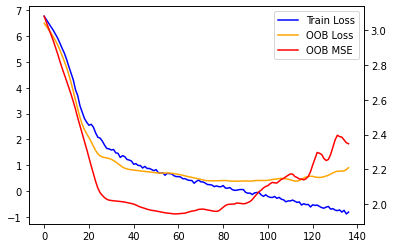

Bootstrap iteration 3 at time 2022-07-06 17:31:17.160656
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.240187644958496, MSE: 2.6517574787139893
Epoch: 0, Loss: 7.7886199951171875, OOB Loss: 7.49669075012207, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1922507286071777, MSE: 1.411620855331421
Epoch: 40, Loss: 0.9796144962310791, OOB Loss: 0.33785271644592285, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.4151840209960938, MSE: 1.3831757307052612
Epoch: 80, Loss: 0.251619815826416, OOB Loss: 0.1370248794555664, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.9488797187805176, MSE: 1.3991438150405884
Epoch: 120, Loss: -0.2520127296447754, OOB Loss: 0.09502291679382324, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.4203853607177734, MSE: 1.3792062997817993
Epoch: 160, Loss: -0.7699108123779297, OOB Loss: 0.10522603988647461, LR: 0.0003341547246965484
Early stopped, best epoch: 146, train loss: -0.564727783203125, best 

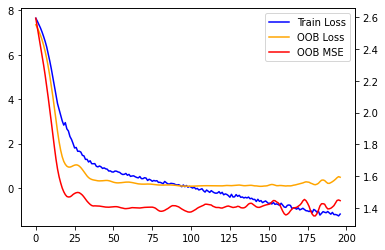

Bootstrap iteration 4 at time 2022-07-06 17:31:32.169188
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.58550500869751, MSE: 3.316873788833618
Epoch: 0, Loss: 8.070683479309082, OOB Loss: 7.863447666168213, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.131457805633545, MSE: 2.1406161785125732
Epoch: 40, Loss: 1.0956001281738281, OOB Loss: 2.3338088989257812, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.4725377559661865, MSE: 2.1949167251586914
Epoch: 80, Loss: 0.16019105911254883, OOB Loss: 1.8344504833221436, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0476388931274414, MSE: 2.1069560050964355
Epoch: 120, Loss: -0.3572356700897217, OOB Loss: 1.5146498680114746, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.64565372467041, MSE: 2.076305866241455
Epoch: 160, Loss: -0.949887752532959, OOB Loss: 1.757646083831787, LR: 0.0003341547246965484
Early stopped, best epoch: 140, train loss: -0.6910350322723389, best OOB los

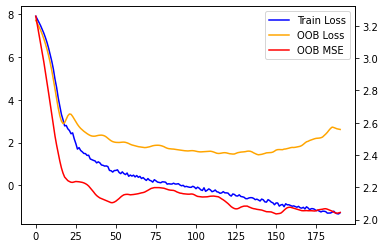

Bootstrap iteration 5 at time 2022-07-06 17:31:46.763772
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.602323055267334, MSE: 2.15891170501709
Epoch: 0, Loss: 7.235253810882568, OOB Loss: 6.8856682777404785, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8807932138442993, MSE: 1.5442888736724854
Epoch: 40, Loss: 1.1040575504302979, OOB Loss: 0.7696059942245483, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.734442949295044, MSE: 1.5627065896987915
Epoch: 80, Loss: -0.0909113883972168, OOB Loss: 0.9534177780151367, LR: 0.00040823971994699836
Early stopped, best epoch: 37, train loss: 1.1327035427093506, best OOB loss: 0.7443822622299194, LR: 0.0004001460114033451


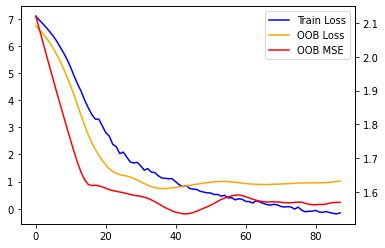

Bootstrap iteration 6 at time 2022-07-06 17:31:53.854263
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.021439552307129, MSE: 5.115784645080566
Epoch: 0, Loss: 6.664283275604248, OOB Loss: 7.10714864730835, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.001590371131897, MSE: 3.147111415863037
Epoch: 40, Loss: 0.6437718868255615, OOB Loss: 2.2775001525878906, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.8366315364837646, MSE: 3.503012180328369
Epoch: 80, Loss: -0.34754443168640137, OOB Loss: 2.987436056137085, LR: 0.00040823971994699836
Early stopped, best epoch: 43, train loss: 0.564873218536377, best OOB loss: 2.2455008029937744, LR: 0.00039418121010946174


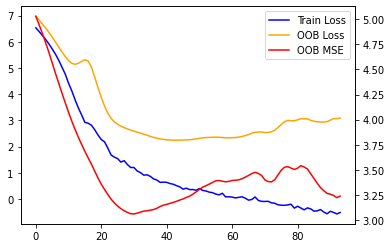

Bootstrap iteration 7 at time 2022-07-06 17:32:01.459478
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.476003646850586, MSE: 4.923526287078857
Epoch: 0, Loss: 7.000397682189941, OOB Loss: 7.084160804748535, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.493531346321106, MSE: 3.0328657627105713
Epoch: 40, Loss: 0.7398922443389893, OOB Loss: 1.935322880744934, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.203751564025879, MSE: 2.631042957305908
Epoch: 80, Loss: -0.03165268898010254, OOB Loss: 1.6248345375061035, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: 0.19036245346069336, best OOB loss: 1.520770788192749, LR: 0.00037119799610227123


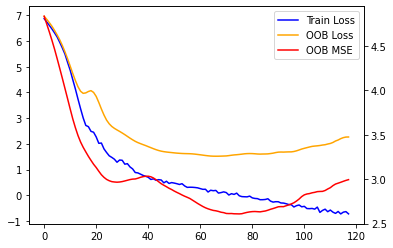

Bootstrap iteration 8 at time 2022-07-06 17:32:11.211611
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.4545416831970215, MSE: 3.9044885635375977
Epoch: 0, Loss: 6.209473133087158, OOB Loss: 6.19087028503418, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.044376850128174, MSE: 2.986532211303711
Epoch: 40, Loss: 0.4786257743835449, OOB Loss: 3.387624740600586, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.751099109649658, MSE: 2.8236513137817383
Epoch: 80, Loss: -0.40053558349609375, OOB Loss: 3.4943370819091797, LR: 0.00040823971994699836
Early stopped, best epoch: 32, train loss: 1.033918023109436, best OOB loss: 2.909060478210449, LR: 0.00040518557016339937


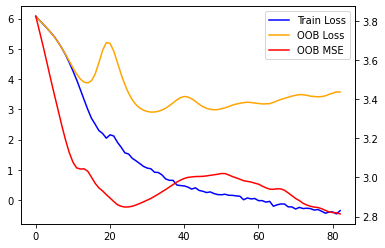

Bootstrap iteration 9 at time 2022-07-06 17:32:17.708003
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.007874488830566, MSE: 5.529114723205566
Epoch: 0, Loss: 6.642529487609863, OOB Loss: 6.878686904907227, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7919870615005493, MSE: 3.528257131576538
Epoch: 40, Loss: 0.5684452056884766, OOB Loss: 3.0132389068603516, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.487495183944702, MSE: 3.3787946701049805
Epoch: 80, Loss: -0.3260316848754883, OOB Loss: 3.0245587825775146, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: -0.03569531440734863, best OOB loss: 2.5124621391296387, LR: 0.00037119799610227123


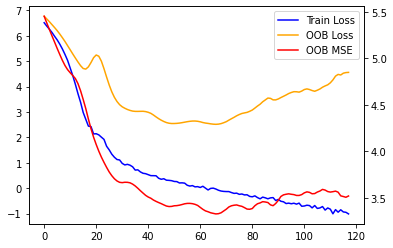

Bootstrap iteration 10 at time 2022-07-06 17:32:26.875456
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.472944259643555, MSE: 4.888271331787109
Epoch: 0, Loss: 6.273575782775879, OOB Loss: 6.585075855255127, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1892926692962646, MSE: 3.3286283016204834
Epoch: 40, Loss: 0.7139379978179932, OOB Loss: 1.8709275722503662, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7682034969329834, MSE: 3.2165379524230957
Epoch: 80, Loss: -0.03143930435180664, OOB Loss: 1.1802029609680176, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.4340498447418213, MSE: 3.2979395389556885
Epoch: 120, Loss: -0.597836971282959, OOB Loss: 1.4355065822601318, LR: 0.00036934432610923556
Early stopped, best epoch: 88, train loss: -0.11517143249511719, best OOB loss: 1.1447603702545166, LR: 0.0003521896707677057


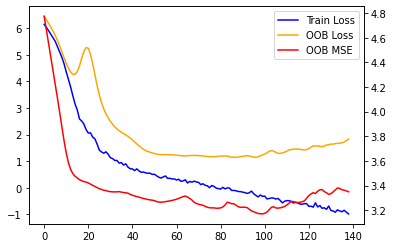

Bootstrap iteration 11 at time 2022-07-06 17:32:37.884330
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.3591413497924805, MSE: 2.390011787414551
Epoch: 0, Loss: 7.177036285400391, OOB Loss: 6.785272121429443, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.644420862197876, MSE: 1.7077138423919678
Epoch: 40, Loss: 1.1374096870422363, OOB Loss: 0.5042810440063477, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.000063896179199, MSE: 1.6215379238128662
Epoch: 80, Loss: 0.41968870162963867, OOB Loss: 0.5395004749298096, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.8101296424865723, best OOB loss: 0.4231686592102051, LR: 0.0003834757154374967


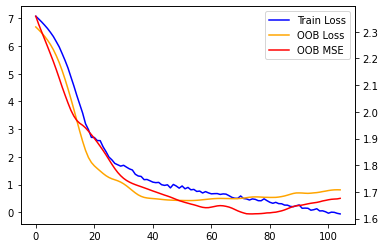

Bootstrap iteration 12 at time 2022-07-06 17:32:46.365709
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.913130760192871, MSE: 4.900585174560547
Epoch: 0, Loss: 7.48921012878418, OOB Loss: 7.465127468109131, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.498384714126587, MSE: 2.6545681953430176
Epoch: 40, Loss: 0.9333209991455078, OOB Loss: 1.7611989974975586, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.288836717605591, MSE: 2.564882516860962
Epoch: 80, Loss: -0.11329913139343262, OOB Loss: 1.3729784488677979, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.013519048690796, MSE: 2.8498246669769287
Epoch: 120, Loss: -0.8259527683258057, OOB Loss: 2.031425714492798, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: -0.18299055099487305, best OOB loss: 1.3602991104125977, LR: 0.00035751905063161196


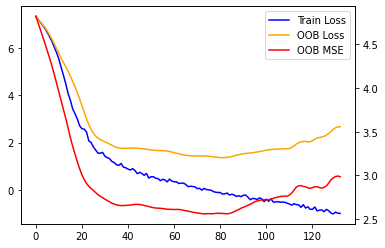

Bootstrap iteration 13 at time 2022-07-06 17:32:57.137876
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.652280330657959, MSE: 3.487868070602417
Epoch: 0, Loss: 6.366495132446289, OOB Loss: 6.175387382507324, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9273076057434082, MSE: 2.32875394821167
Epoch: 40, Loss: 0.6332247257232666, OOB Loss: 1.5502293109893799, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.443467378616333, MSE: 2.28252911567688
Epoch: 80, Loss: -0.15631604194641113, OOB Loss: 1.6070477962493896, LR: 0.00040823971994699836
Early stopped, best epoch: 36, train loss: 0.812743067741394, best OOB loss: 1.457458257675171, LR: 0.000401148883612376


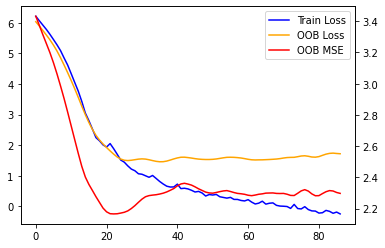

Bootstrap iteration 14 at time 2022-07-06 17:33:04.020263
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.460442543029785, MSE: 4.648480415344238
Epoch: 0, Loss: 6.120973587036133, OOB Loss: 6.389620780944824, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.380175828933716, MSE: 3.894944190979004
Epoch: 40, Loss: 0.6617212295532227, OOB Loss: 3.902686357498169, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7000181674957275, MSE: 3.467175006866455
Epoch: 80, Loss: -0.18725943565368652, OOB Loss: 2.450427293777466, LR: 0.00040823971994699836
Early stopped, best epoch: 61, train loss: 0.16304945945739746, best OOB loss: 2.327504873275757, LR: 0.00037681501241520733


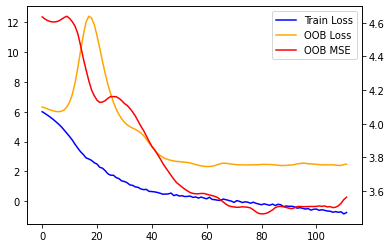

Bootstrap iteration 15 at time 2022-07-06 17:33:12.889619
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.023313999176025, MSE: 6.975440502166748
Epoch: 0, Loss: 6.563543319702148, OOB Loss: 7.289889812469482, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.008467435836792, MSE: 4.617756366729736
Epoch: 40, Loss: 0.4893815517425537, OOB Loss: 5.602603912353516, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3483002185821533, MSE: 4.534450054168701
Epoch: 80, Loss: -0.22806763648986816, OOB Loss: 5.04350471496582, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.31920409202575684, best OOB loss: 4.536461353302002, LR: 0.00039025415518281834


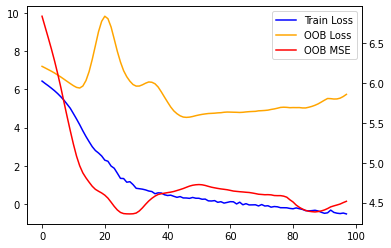

Bootstrap iteration 16 at time 2022-07-06 17:33:20.139560
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.6610260009765625, MSE: 2.6847758293151855
Epoch: 0, Loss: 8.085556983947754, OOB Loss: 7.878307819366455, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5463616847991943, MSE: 2.1878085136413574
Epoch: 40, Loss: 0.8214991092681885, OOB Loss: 1.3815062046051025, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.961512327194214, MSE: 2.1475670337677
Epoch: 80, Loss: -0.16903138160705566, OOB Loss: 1.5617320537567139, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.4493370056152344, best OOB loss: 1.2482566833496094, LR: 0.0003883053234953742


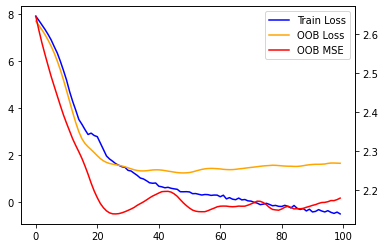

Bootstrap iteration 17 at time 2022-07-06 17:33:28.119519
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.26015567779541, MSE: 3.789850950241089
Epoch: 0, Loss: 7.733354091644287, OOB Loss: 7.69565486907959, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.85056734085083, MSE: 2.843334436416626
Epoch: 40, Loss: 0.8657286167144775, OOB Loss: 1.8631024360656738, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9754549264907837, MSE: 2.8799052238464355
Epoch: 80, Loss: 0.18496084213256836, OOB Loss: 1.0096291303634644, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.8693459033966064, MSE: 2.975296974182129
Epoch: 120, Loss: -0.4845278263092041, OOB Loss: 1.012014389038086, LR: 0.00036934432610923556
Early stopped, best epoch: 99, train loss: -0.04809117317199707, best OOB loss: 0.8671009540557861, LR: 0.00034262461655602014


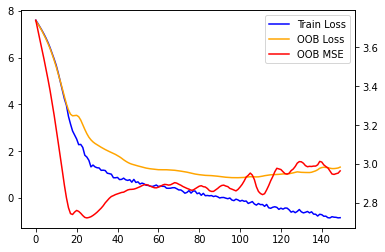

Bootstrap iteration 18 at time 2022-07-06 17:33:40.608705
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.01863431930542, MSE: 4.341932773590088
Epoch: 0, Loss: 7.586071968078613, OOB Loss: 7.533379077911377, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.7616620063781738, MSE: 3.058467388153076
Epoch: 40, Loss: 0.6640517711639404, OOB Loss: 2.191479444503784, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.722812294960022, MSE: 2.7690117359161377
Epoch: 80, Loss: -0.2805194854736328, OOB Loss: 1.8957980871200562, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.772178888320923, MSE: 2.838742971420288
Epoch: 120, Loss: -1.019719123840332, OOB Loss: 2.640033006668091, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: 0.0018091201782226562, best OOB loss: 1.884186863899231, LR: 0.0003684209652939625


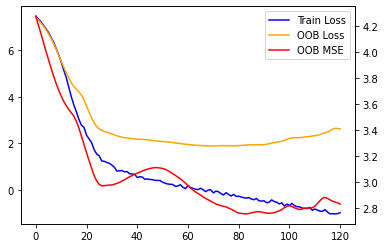

Bootstrap iteration 19 at time 2022-07-06 17:33:50.527525
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.182320594787598, MSE: 2.2721221446990967
Epoch: 0, Loss: 6.867485046386719, OOB Loss: 6.576216697692871, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0168042182922363, MSE: 1.5133570432662964
Epoch: 40, Loss: 1.1061444282531738, OOB Loss: 0.07642436027526855, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.661297559738159, MSE: 1.452155351638794
Epoch: 80, Loss: -0.04949069023132324, OOB Loss: 0.004120826721191406, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.6852962970733643, best OOB loss: -0.1639695167541504, LR: 0.0003931957570841881


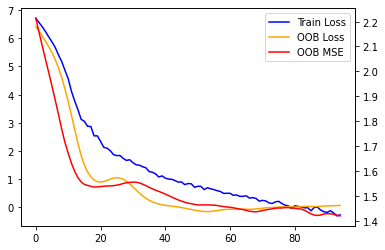

Bootstrap iteration 20 at time 2022-07-06 17:33:58.349761
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.280592441558838, MSE: 3.730844736099243
Epoch: 0, Loss: 6.890807151794434, OOB Loss: 6.88004207611084, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.1579545736312866, MSE: 3.1278200149536133
Epoch: 40, Loss: 1.0657382011413574, OOB Loss: 2.782011032104492, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.062037229537964, MSE: 3.127741575241089
Epoch: 80, Loss: -0.05987882614135742, OOB Loss: 1.9267868995666504, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.484562397003174, MSE: 3.309096574783325
Epoch: 120, Loss: -0.7832474708557129, OOB Loss: 2.272191047668457, LR: 0.00036934432610923556
Early stopped, best epoch: 81, train loss: -0.062177181243896484, best OOB loss: 1.9141571521759033, LR: 0.0003584150883524932


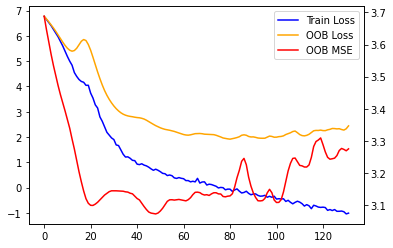

Bootstrap iteration 21 at time 2022-07-06 17:34:09.013309
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.624197959899902, MSE: 4.23432731628418
Epoch: 0, Loss: 6.643008708953857, OOB Loss: 6.459665298461914, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0383341312408447, MSE: 2.6038894653320312
Epoch: 40, Loss: 0.6086869239807129, OOB Loss: 2.8247225284576416, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7267820835113525, MSE: 2.45177960395813
Epoch: 80, Loss: -0.3107149600982666, OOB Loss: 3.0118610858917236, LR: 0.00040823971994699836
Early stopped, best epoch: 32, train loss: 1.0806881189346313, best OOB loss: 2.4684133529663086, LR: 0.00040518557016339937


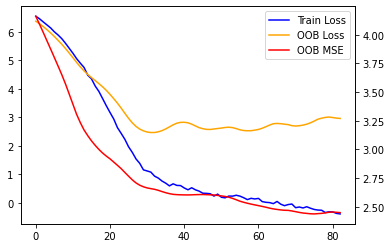

Bootstrap iteration 22 at time 2022-07-06 17:34:15.667263
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.8308539390563965, MSE: 3.7529475688934326
Epoch: 0, Loss: 7.4211273193359375, OOB Loss: 7.214962959289551, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2296456098556519, MSE: 2.69748854637146
Epoch: 40, Loss: 0.6906394958496094, OOB Loss: 1.7811442613601685, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.6425933837890625, MSE: 2.7340898513793945
Epoch: 80, Loss: -0.18747687339782715, OOB Loss: 1.877464771270752, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.46727585792541504, best OOB loss: 1.7587473392486572, LR: 0.00039123223577224893


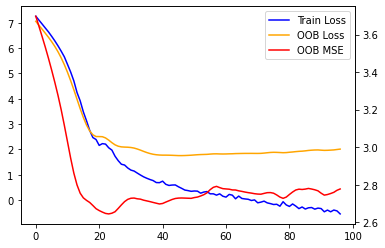

Bootstrap iteration 23 at time 2022-07-06 17:34:23.564353
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.1868743896484375, MSE: 1.8653724193572998
Epoch: 0, Loss: 6.843592643737793, OOB Loss: 6.464681148529053, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4538066387176514, MSE: 1.4725452661514282
Epoch: 40, Loss: 1.0684831142425537, OOB Loss: 0.4135861396789551, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.344914674758911, MSE: 1.36593759059906
Epoch: 80, Loss: 0.12824463844299316, OOB Loss: -0.009541511535644531, LR: 0.00040823971994699836
Early stopped, best epoch: 81, train loss: 0.04575157165527344, best OOB loss: -0.012900829315185547, LR: 0.00037027000111201555


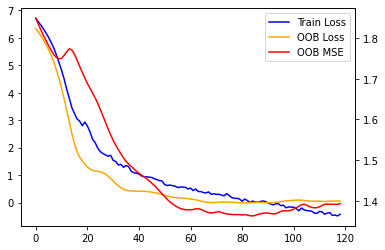

Bootstrap iteration 24 at time 2022-07-06 17:34:33.359417
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.546238422393799, MSE: 5.5672736167907715
Epoch: 0, Loss: 6.256392002105713, OOB Loss: 6.890296936035156, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.489375591278076, MSE: 4.186044692993164
Epoch: 40, Loss: 0.6498031616210938, OOB Loss: 5.717793941497803, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.626420736312866, MSE: 4.544946193695068
Epoch: 80, Loss: -0.0440213680267334, OOB Loss: 4.8712921142578125, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.3884260654449463, best OOB loss: 3.8431832790374756, LR: 0.0003863662237861692


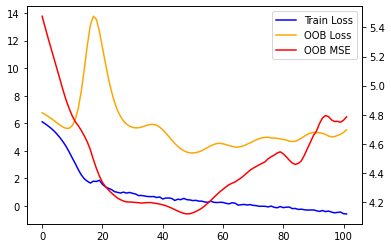

Bootstrap iteration 25 at time 2022-07-06 17:34:40.872695
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.619761943817139, MSE: 7.5443243980407715
Epoch: 0, Loss: 7.129749298095703, OOB Loss: 8.010783195495605, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7816967964172363, MSE: 6.294878005981445
Epoch: 40, Loss: 0.444549560546875, OOB Loss: 10.657909393310547, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9394441843032837, MSE: 5.2413129806518555
Epoch: 80, Loss: -0.3527250289916992, OOB Loss: 6.352316379547119, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.9282467365264893, MSE: 4.959404468536377
Epoch: 120, Loss: -0.9108331203460693, OOB Loss: 8.967754364013672, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: -0.3527250289916992, best OOB loss: 6.352316379547119, LR: 0.00035931337178194805


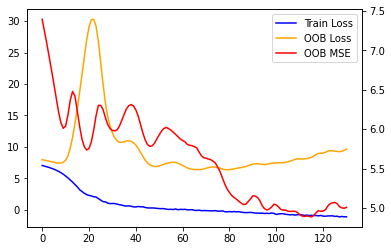

Bootstrap iteration 26 at time 2022-07-06 17:34:50.473059
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.7890496253967285, MSE: 8.116950988769531
Epoch: 0, Loss: 7.233394145965576, OOB Loss: 7.9017791748046875, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.747088074684143, MSE: 5.527668476104736
Epoch: 40, Loss: 0.40856337547302246, OOB Loss: 8.028022766113281, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.3103737831115723, MSE: 6.94873046875
Epoch: 80, Loss: -0.25829553604125977, OOB Loss: 5.450313568115234, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.035875082015991, MSE: 7.942471504211426
Epoch: 120, Loss: -0.8279008865356445, OOB Loss: 8.3078031539917, LR: 0.00036934432610923556
Early stopped, best epoch: 69, train loss: -0.1464400291442871, best OOB loss: 4.727898120880127, LR: 0.00036934432610923556


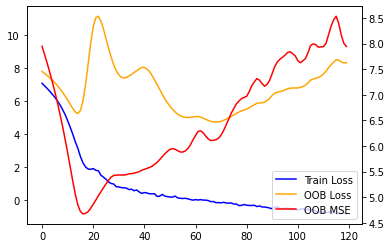

Bootstrap iteration 27 at time 2022-07-06 17:34:59.280979
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.411019325256348, MSE: 3.093491792678833
Epoch: 0, Loss: 7.0407395362854, OOB Loss: 6.80996036529541, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.05838942527771, MSE: 2.118008852005005
Epoch: 40, Loss: 0.8031811714172363, OOB Loss: 2.8794329166412354, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.921708345413208, MSE: 2.0112740993499756
Epoch: 80, Loss: 0.0018744468688964844, OOB Loss: 2.3347413539886475, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.7416059970855713, MSE: 1.8795653581619263
Epoch: 120, Loss: -0.5802221298217773, OOB Loss: 2.380620241165161, LR: 0.00036934432610923556
Early stopped, best epoch: 107, train loss: -0.31545257568359375, best OOB loss: 2.03765606880188, LR: 0.0003358317846712504


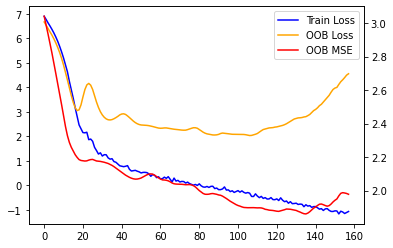

Bootstrap iteration 28 at time 2022-07-06 17:35:11.554313
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.770746231079102, MSE: 6.307605743408203
Epoch: 0, Loss: 7.270294189453125, OOB Loss: 7.588503837585449, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0343899726867676, MSE: 4.153565406799316
Epoch: 40, Loss: 0.25995850563049316, OOB Loss: 4.61893367767334, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.257789373397827, MSE: 4.90128231048584
Epoch: 80, Loss: -0.4405994415283203, OOB Loss: 4.435791969299316, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: -0.044387102127075195, best OOB loss: 3.5851404666900635, LR: 0.0003883053234953742


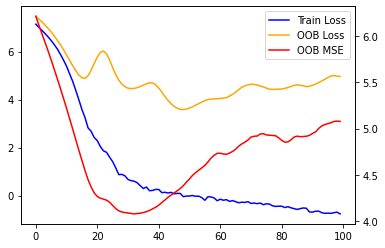

Bootstrap iteration 29 at time 2022-07-06 17:35:19.318157
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.695260047912598, MSE: 2.68782639503479
Epoch: 0, Loss: 7.256164073944092, OOB Loss: 7.0165324211120605, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2245203256607056, MSE: 1.9262434244155884
Epoch: 40, Loss: 0.7832527160644531, OOB Loss: 1.2078603506088257, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3008482456207275, MSE: 1.9663480520248413
Epoch: 80, Loss: -0.11286592483520508, OOB Loss: 1.1179530620574951, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.8489391803741455, MSE: 1.989088535308838
Epoch: 120, Loss: -0.7856626510620117, OOB Loss: 1.1535041332244873, LR: 0.00036934432610923556
Early stopped, best epoch: 95, train loss: -0.37686777114868164, best OOB loss: 1.0750555992126465, LR: 0.0003460723843006206


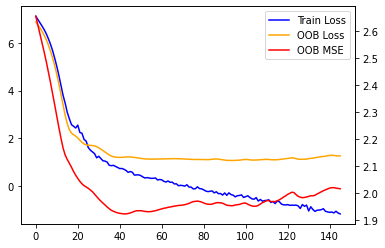

Bootstrap iteration 30 at time 2022-07-06 17:35:30.816360
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.214827537536621, MSE: 1.8486840724945068
Epoch: 0, Loss: 6.975926876068115, OOB Loss: 6.495918273925781, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3252148628234863, MSE: 1.2879610061645508
Epoch: 40, Loss: 1.3510453701019287, OOB Loss: 0.059288740158081055, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9388997554779053, MSE: 1.243818759918213
Epoch: 80, Loss: 0.32208895683288574, OOB Loss: -0.22774624824523926, LR: 0.00040823971994699836
Early stopped, best epoch: 85, train loss: 0.212022066116333, best OOB loss: -0.27555418014526367, LR: 0.0003922127676914776


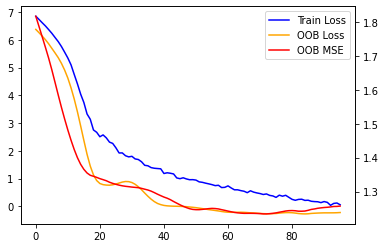

Bootstrap iteration 31 at time 2022-07-06 17:35:39.100236
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.96304178237915, MSE: 2.980478048324585
Epoch: 0, Loss: 7.624854564666748, OOB Loss: 7.28221321105957, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.368715763092041, MSE: 1.9490857124328613
Epoch: 40, Loss: 0.8259422779083252, OOB Loss: 1.9564237594604492, LR: 0.00045123116063007594
Early stopped, best epoch: 28, train loss: 1.6889325380325317, best OOB loss: 1.5219311714172363, LR: 0.000409262877139848


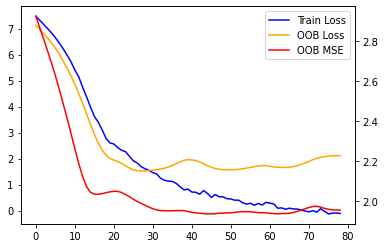

Bootstrap iteration 32 at time 2022-07-06 17:35:45.398515
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.773795127868652, MSE: 1.8907619714736938
Epoch: 0, Loss: 6.565976142883301, OOB Loss: 6.122598648071289, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.047999143600464, MSE: 1.6060103178024292
Epoch: 40, Loss: 1.0421154499053955, OOB Loss: 0.8939018249511719, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6825790405273438, MSE: 1.4889352321624756
Epoch: 80, Loss: -0.03542590141296387, OOB Loss: 0.6795327663421631, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.121816635131836, MSE: 1.4433598518371582
Epoch: 120, Loss: -0.8068668842315674, OOB Loss: 0.6162323951721191, LR: 0.00036934432610923556
Early stopped, best epoch: 107, train loss: -0.4661698341369629, best OOB loss: 0.6117656230926514, LR: 0.0003358317846712504


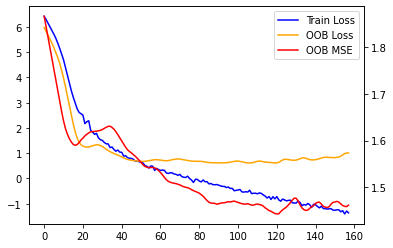

Bootstrap iteration 33 at time 2022-07-06 17:35:57.398102
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.037893772125244, MSE: 2.239193916320801
Epoch: 0, Loss: 6.7885894775390625, OOB Loss: 6.40900182723999, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.747711420059204, MSE: 1.3885949850082397
Epoch: 40, Loss: 1.0504872798919678, OOB Loss: 0.45634889602661133, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.265671968460083, MSE: 1.3970839977264404
Epoch: 80, Loss: 0.19567251205444336, OOB Loss: 0.6279911994934082, LR: 0.00040823971994699836
Early stopped, best epoch: 37, train loss: 1.0487483739852905, best OOB loss: 0.4321177005767822, LR: 0.0004001460114033451


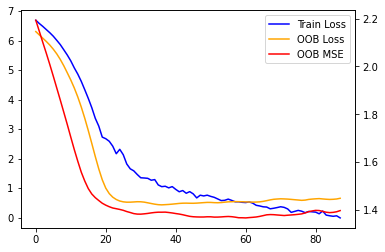

Bootstrap iteration 34 at time 2022-07-06 17:36:04.332123
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.3123931884765625, MSE: 2.1119883060455322
Epoch: 0, Loss: 6.150221347808838, OOB Loss: 5.775988578796387, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.9784021377563477, MSE: 1.574864149093628
Epoch: 40, Loss: 0.7922794818878174, OOB Loss: 0.5167262554168701, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.669058084487915, MSE: 1.6111632585525513
Epoch: 80, Loss: 0.047542572021484375, OOB Loss: 0.636176347732544, LR: 0.00040823971994699836
Early stopped, best epoch: 44, train loss: 0.6663486957550049, best OOB loss: 0.4613935947418213, LR: 0.0003931957570841881


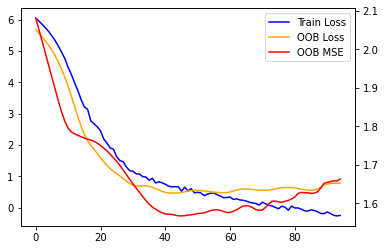

Bootstrap iteration 35 at time 2022-07-06 17:36:12.148948
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.679438591003418, MSE: 3.0581719875335693
Epoch: 0, Loss: 7.207313060760498, OOB Loss: 7.0497355461120605, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.310757637023926, MSE: 2.1908576488494873
Epoch: 40, Loss: 0.940065860748291, OOB Loss: 0.9929442405700684, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1839184761047363, MSE: 2.238525867462158
Epoch: 80, Loss: -0.10394954681396484, OOB Loss: 1.014089584350586, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.5293455123901367, best OOB loss: 0.809321403503418, LR: 0.0003854003082267038


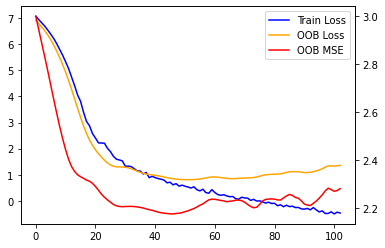

Bootstrap iteration 36 at time 2022-07-06 17:36:20.500712
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.843177795410156, MSE: 3.4742202758789062
Epoch: 0, Loss: 5.704811096191406, OOB Loss: 5.627274990081787, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1459362506866455, MSE: 2.636793375015259
Epoch: 40, Loss: 0.4260075092315674, OOB Loss: 2.465165376663208, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.572112560272217, MSE: 2.6778526306152344
Epoch: 80, Loss: -0.3503577709197998, OOB Loss: 2.5083489418029785, LR: 0.00040823971994699836
Early stopped, best epoch: 43, train loss: 0.3021812438964844, best OOB loss: 2.4012670516967773, LR: 0.00039418121010946174


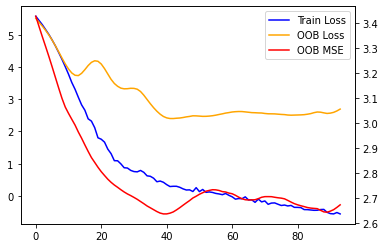

Bootstrap iteration 37 at time 2022-07-06 17:36:27.918566
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.547060012817383, MSE: 6.569998264312744
Epoch: 0, Loss: 8.055975914001465, OOB Loss: 8.099613189697266, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.394134759902954, MSE: 3.932774066925049
Epoch: 40, Loss: 0.4794905185699463, OOB Loss: 5.333467483520508, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1624484062194824, MSE: 4.011436462402344
Epoch: 80, Loss: -0.236236572265625, OOB Loss: 4.7198567390441895, LR: 0.00040823971994699836
Early stopped, best epoch: 32, train loss: 0.9197918176651001, best OOB loss: 4.237490653991699, LR: 0.00040518557016339937


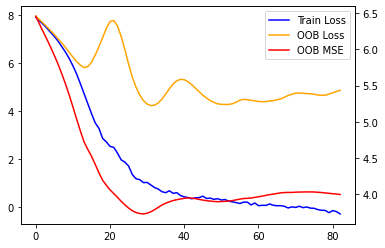

Bootstrap iteration 38 at time 2022-07-06 17:36:34.235753
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.208082675933838, MSE: 4.726102828979492
Epoch: 0, Loss: 6.743748664855957, OOB Loss: 7.048981189727783, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.610039472579956, MSE: 3.5459489822387695
Epoch: 40, Loss: 1.1400749683380127, OOB Loss: 3.2548062801361084, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4364302158355713, MSE: 3.997572183609009
Epoch: 80, Loss: 0.15454936027526855, OOB Loss: 2.7508513927459717, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.6993670463562012, best OOB loss: 2.2206809520721436, LR: 0.00038733456018663577


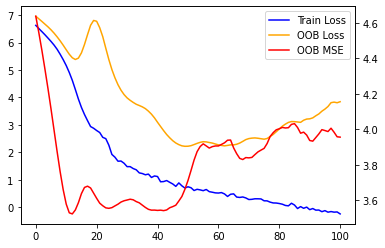

Bootstrap iteration 39 at time 2022-07-06 17:36:42.415991
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.37263822555542, MSE: 2.7875075340270996
Epoch: 0, Loss: 6.995842933654785, OOB Loss: 6.790505886077881, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.6552774906158447, MSE: 1.7232894897460938
Epoch: 40, Loss: 1.240795373916626, OOB Loss: 1.8170149326324463, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.6726696491241455, MSE: 1.7375150918960571
Epoch: 80, Loss: 0.3887014389038086, OOB Loss: 0.896615743637085, LR: 0.00040823971994699836
Early stopped, best epoch: 68, train loss: 0.5518312454223633, best OOB loss: 0.8005475997924805, LR: 0.00037027000111201555


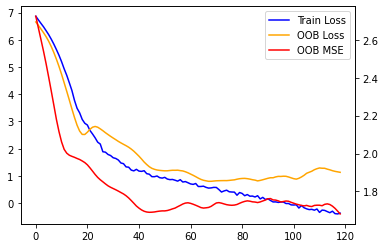

Bootstrap iteration 40 at time 2022-07-06 17:36:51.924537
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.170664310455322, MSE: 3.226931095123291
Epoch: 0, Loss: 6.904470920562744, OOB Loss: 6.5764336585998535, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.430619239807129, MSE: 1.849805474281311
Epoch: 40, Loss: 1.1902430057525635, OOB Loss: 0.21895647048950195, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1354053020477295, MSE: 1.9055118560791016
Epoch: 80, Loss: 0.27306485176086426, OOB Loss: 0.33605456352233887, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.6264152526855469, best OOB loss: 0.16951465606689453, LR: 0.00037493329244695894


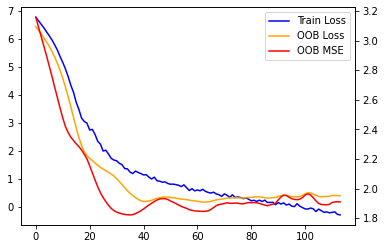

Bootstrap iteration 41 at time 2022-07-06 17:37:00.936106
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.242305755615234, MSE: 2.1585958003997803
Epoch: 0, Loss: 7.059584617614746, OOB Loss: 6.5752949714660645, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.6264476776123047, MSE: 1.2456401586532593
Epoch: 40, Loss: 1.1522396802902222, OOB Loss: -0.03841352462768555, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5464961528778076, MSE: 1.1784586906433105
Epoch: 80, Loss: 0.3041048049926758, OOB Loss: -0.08665609359741211, LR: 0.00040823971994699836
Early stopped, best epoch: 72, train loss: 0.4828975200653076, best OOB loss: -0.10465502738952637, LR: 0.0004001460114033451


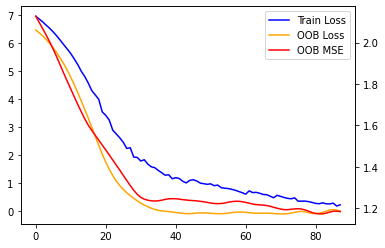

Bootstrap iteration 42 at time 2022-07-06 17:37:08.496743
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.479539394378662, MSE: 2.7028110027313232
Epoch: 0, Loss: 6.287351608276367, OOB Loss: 6.052877902984619, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.695943593978882, MSE: 1.995035171508789
Epoch: 40, Loss: 0.9276149272918701, OOB Loss: 0.7182257175445557, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.306169033050537, MSE: 1.9494045972824097
Epoch: 80, Loss: 0.10472536087036133, OOB Loss: 0.37158751487731934, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.018182277679443, MSE: 2.066009283065796
Epoch: 120, Loss: -0.6598832607269287, OOB Loss: 0.7208490371704102, LR: 0.00036934432610923556
Early stopped, best epoch: 77, train loss: 0.14269065856933594, best OOB loss: 0.3456611633300781, LR: 0.0003620217526757433


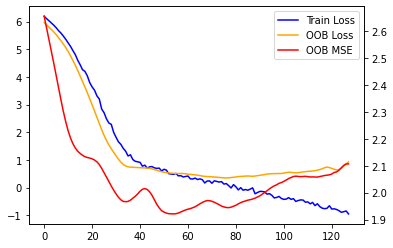

Bootstrap iteration 43 at time 2022-07-06 17:37:19.045289
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.357757568359375, MSE: 2.214484453201294
Epoch: 0, Loss: 6.978108882904053, OOB Loss: 6.655937194824219, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.287466049194336, MSE: 1.8643099069595337
Epoch: 40, Loss: 0.6493241786956787, OOB Loss: 1.6590588092803955, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.475938081741333, MSE: 1.8489214181900024
Epoch: 80, Loss: -0.27372169494628906, OOB Loss: 1.5783679485321045, LR: 0.00040823971994699836
Early stopped, best epoch: 34, train loss: 0.8630914688110352, best OOB loss: 1.4762181043624878, LR: 0.00040316217472239593


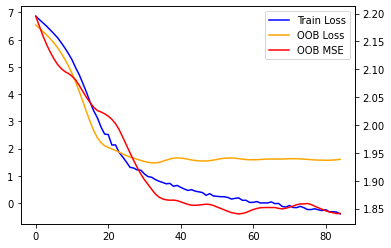

Bootstrap iteration 44 at time 2022-07-06 17:37:25.946427
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.307039737701416, MSE: 2.5502820014953613
Epoch: 0, Loss: 6.400920867919922, OOB Loss: 5.849746227264404, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.3858985900878906, MSE: 1.8636345863342285
Epoch: 40, Loss: 0.8456051349639893, OOB Loss: 1.5865240097045898, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4251930713653564, MSE: 1.7296783924102783
Epoch: 80, Loss: 0.05402803421020508, OOB Loss: 0.9167649745941162, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.714099884033203, MSE: 1.636727213859558
Epoch: 120, Loss: -0.5969696044921875, OOB Loss: 0.600649356842041, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 4.488649368286133, MSE: 1.6898128986358643
Epoch: 160, Loss: -1.2250845432281494, OOB Loss: 1.5338177680969238, LR: 0.0003341547246965484
Early stopped, best epoch: 123, train loss: -0.6008515357971191, best OO

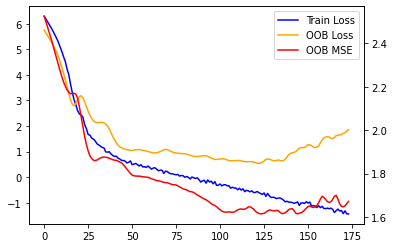

Bootstrap iteration 45 at time 2022-07-06 17:37:39.455917
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.715467929840088, MSE: 3.1317834854125977
Epoch: 0, Loss: 6.737154960632324, OOB Loss: 6.2473273277282715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4703667163848877, MSE: 1.9896169900894165
Epoch: 40, Loss: 1.040907859802246, OOB Loss: 0.9748210906982422, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9492220878601074, MSE: 2.004077911376953
Epoch: 80, Loss: 0.12388014793395996, OOB Loss: 0.9286305904388428, LR: 0.00040823971994699836
Early stopped, best epoch: 46, train loss: 0.855309247970581, best OOB loss: 0.867140531539917, LR: 0.00039123223577224893


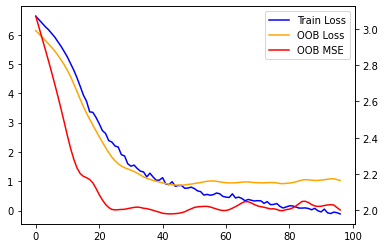

Bootstrap iteration 46 at time 2022-07-06 17:37:47.370048
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.046595096588135, MSE: 2.5957865715026855
Epoch: 0, Loss: 6.697626113891602, OOB Loss: 6.4382405281066895, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4498517513275146, MSE: 1.7185763120651245
Epoch: 40, Loss: 0.7473917007446289, OOB Loss: 1.1570796966552734, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8982889652252197, MSE: 1.796241283416748
Epoch: 80, Loss: -0.1058647632598877, OOB Loss: 1.1735565662384033, LR: 0.00040823971994699836
Early stopped, best epoch: 65, train loss: 0.19122648239135742, best OOB loss: 1.0927150249481201, LR: 0.00037306096931780195


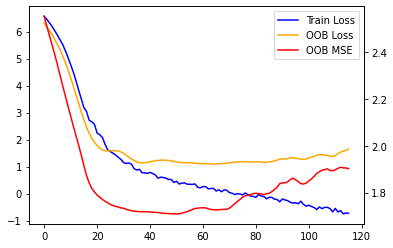

Bootstrap iteration 47 at time 2022-07-06 17:37:56.298184
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.967128276824951, MSE: 4.923520088195801
Epoch: 0, Loss: 5.897510051727295, OOB Loss: 6.2253594398498535, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.247326612472534, MSE: 3.4370474815368652
Epoch: 40, Loss: 0.5959148406982422, OOB Loss: 2.1280572414398193, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3356034755706787, MSE: 3.615906238555908
Epoch: 80, Loss: -0.20339035987854004, OOB Loss: 2.384253740310669, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.39928340911865234, best OOB loss: 1.7945419549942017, LR: 0.0003883053234953742


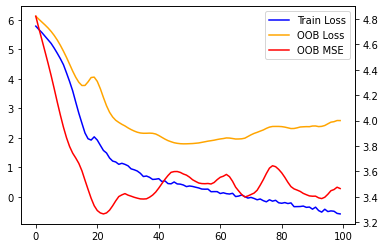

Bootstrap iteration 48 at time 2022-07-06 17:38:04.448926
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.093664169311523, MSE: 2.8917226791381836
Epoch: 0, Loss: 5.9973530769348145, OOB Loss: 5.759100914001465, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.857454299926758, MSE: 1.9754127264022827
Epoch: 40, Loss: 0.889535665512085, OOB Loss: 1.739445686340332, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.006493091583252, MSE: 1.985825538635254
Epoch: 80, Loss: 0.003801584243774414, OOB Loss: 1.1920452117919922, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.610905647277832, MSE: 2.1251752376556396
Epoch: 120, Loss: -0.5279808044433594, OOB Loss: 1.8363656997680664, LR: 0.00036934432610923556
Early stopped, best epoch: 78, train loss: 0.11618447303771973, best OOB loss: 1.164475679397583, LR: 0.00036111669829405396


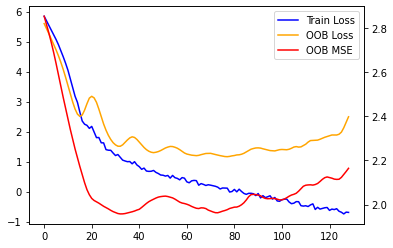

Bootstrap iteration 49 at time 2022-07-06 17:38:14.517865
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.55422830581665, MSE: 1.751112937927246
Epoch: 0, Loss: 6.588588237762451, OOB Loss: 5.877616882324219, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.726562738418579, MSE: 1.266810655593872
Epoch: 40, Loss: 1.121943712234497, OOB Loss: -0.02669048309326172, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.44526743888855, MSE: 1.1378132104873657
Epoch: 80, Loss: 0.19329023361206055, OOB Loss: -0.16365766525268555, LR: 0.00040823971994699836
Early stopped, best epoch: 77, train loss: 0.2581784725189209, best OOB loss: -0.1808488368988037, LR: 0.00039814778225889965


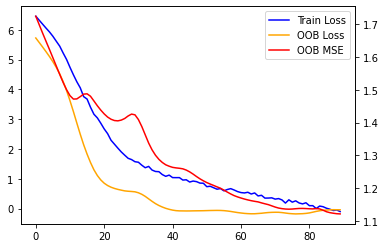

Time 0, 2022-07-06 17:38:22.414552
Time 5, 2022-07-06 17:53:00.288313
Time 10, 2022-07-06 18:07:38.069142
Time 15, 2022-07-06 18:22:10.147091
Time 20, 2022-07-06 18:36:46.551158
Time 25, 2022-07-06 18:51:23.619466
Time 30, 2022-07-06 19:06:13.236851
Time 35, 2022-07-06 19:21:29.318616
Time 40, 2022-07-06 19:36:47.534731
Time 45, 2022-07-06 19:51:56.453189
Time 50, 2022-07-06 20:07:03.585492
Time 55, 2022-07-06 20:22:07.832553
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 1.2882083654403687, OOB Loss: 1.0399819612503052
Epoch: 40, Loss: 0.6449047327041626, OOB Loss: 0.6057393550872803
Epoch: 80, Loss: 0.5247963070869446, OOB Loss: 0.5893653631210327
Epoch: 120, Loss: 0.4419264793395996, OOB Loss: 0.618800163269043
Early stopped, best epoch: 71, train loss: 0.5408974289894104, best OOB loss: 0.5851439833641052, LR: 0.0003674999128807276


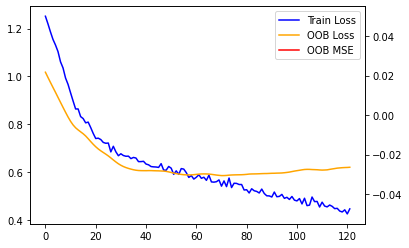

Bootstrap iteration 1 at time 2022-07-06 20:37:32.427323
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9495779871940613, OOB Loss: 0.9109138250350952
Epoch: 40, Loss: 0.5692020654678345, OOB Loss: 0.6394328474998474
Epoch: 80, Loss: 0.4620962142944336, OOB Loss: 0.6661988496780396
Early stopped, best epoch: 33, train loss: 0.6159822940826416, best OOB loss: 0.6341395378112793, LR: 0.0004041726062379909


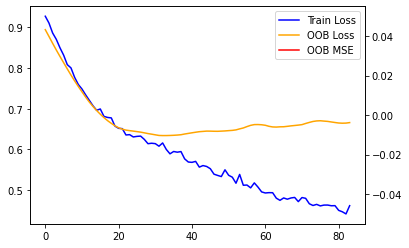

Bootstrap iteration 2 at time 2022-07-06 20:37:45.106054
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.4625095129013062, OOB Loss: 0.4916977286338806
Epoch: 40, Loss: 0.6994830965995789, OOB Loss: 0.38226979970932007
Epoch: 80, Loss: 0.5780323147773743, OOB Loss: 0.34444087743759155
Epoch: 120, Loss: 0.47749969363212585, OOB Loss: 0.35791683197021484
Early stopped, best epoch: 81, train loss: 0.5621252059936523, best OOB loss: 0.344413161277771, LR: 0.00035931337178194805


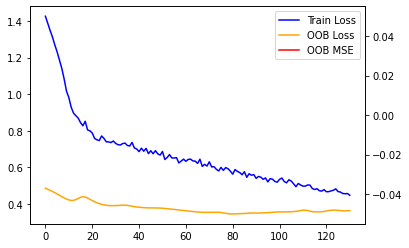

Bootstrap iteration 3 at time 2022-07-06 20:38:05.277674
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1352274417877197, OOB Loss: 0.7545228004455566
Epoch: 40, Loss: 0.662899911403656, OOB Loss: 0.4290977418422699
Epoch: 80, Loss: 0.5223637819290161, OOB Loss: 0.4023311138153076
Epoch: 120, Loss: 0.4207407832145691, OOB Loss: 0.4184040427207947
Early stopped, best epoch: 76, train loss: 0.5309633612632751, best OOB loss: 0.3994255065917969, LR: 0.0003629290753641537


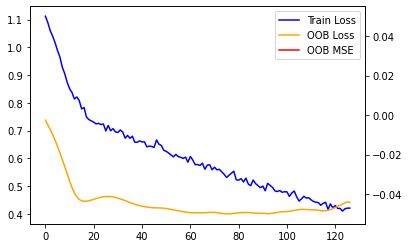

Bootstrap iteration 4 at time 2022-07-06 20:38:24.631910
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0833433866500854, OOB Loss: 1.1606124639511108
Epoch: 40, Loss: 0.6315354704856873, OOB Loss: 0.6588037014007568
Epoch: 80, Loss: 0.50874924659729, OOB Loss: 0.6325398683547974
Epoch: 120, Loss: 0.42096051573753357, OOB Loss: 0.6134337186813354
Epoch: 160, Loss: 0.3566148281097412, OOB Loss: 0.6364742517471313
Early stopped, best epoch: 111, train loss: 0.45546507835388184, best OOB loss: 0.6080090403556824, LR: 0.00033248603954009505


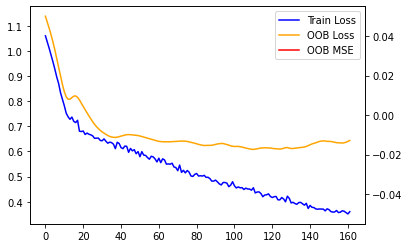

Bootstrap iteration 5 at time 2022-07-06 20:38:49.156262
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2723827362060547, OOB Loss: 0.6507947444915771
Epoch: 40, Loss: 0.6677441000938416, OOB Loss: 0.4509144723415375
Epoch: 80, Loss: 0.5393844842910767, OOB Loss: 0.41695618629455566
Epoch: 120, Loss: 0.4357122778892517, OOB Loss: 0.4081633985042572
Epoch: 160, Loss: 0.3712634742259979, OOB Loss: 0.42716893553733826
Early stopped, best epoch: 110, train loss: 0.47719788551330566, best OOB loss: 0.4062919616699219, LR: 0.00033331933788480705


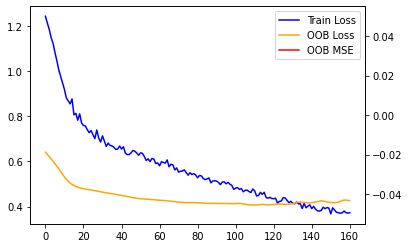

Bootstrap iteration 6 at time 2022-07-06 20:39:14.399075
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0247657299041748, OOB Loss: 0.7665337324142456
Epoch: 40, Loss: 0.5971572399139404, OOB Loss: 0.5647104382514954
Early stopped, best epoch: 21, train loss: 0.6924920082092285, best OOB loss: 0.5104928016662598, LR: 0.00041649713902661297


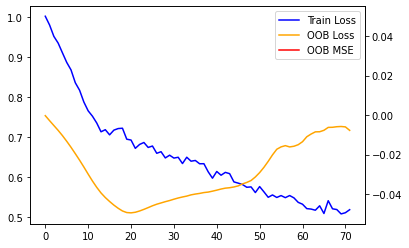

Bootstrap iteration 7 at time 2022-07-06 20:39:25.438585
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0380382537841797, OOB Loss: 1.8861793279647827
Epoch: 40, Loss: 0.5385757684707642, OOB Loss: 1.1150226593017578
Epoch: 80, Loss: 0.48020705580711365, OOB Loss: 1.0809437036514282
Epoch: 120, Loss: 0.4051283299922943, OOB Loss: 1.0710690021514893
Early stopped, best epoch: 99, train loss: 0.43550509214401245, best OOB loss: 1.0236238241195679, LR: 0.00034262461655602014


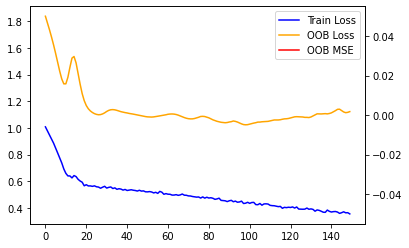

Bootstrap iteration 8 at time 2022-07-06 20:39:47.587220
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8101692199707031, OOB Loss: 1.6449006795883179
Epoch: 40, Loss: 0.5057931542396545, OOB Loss: 1.037688970565796
Epoch: 80, Loss: 0.41608500480651855, OOB Loss: 1.0482600927352905
Early stopped, best epoch: 58, train loss: 0.4522046744823456, best OOB loss: 0.9961642026901245, LR: 0.00037965531467019806


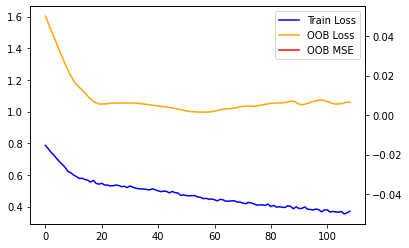

Bootstrap iteration 9 at time 2022-07-06 20:40:04.116737
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0187833309173584, OOB Loss: 0.7411569356918335
Epoch: 40, Loss: 0.604433000087738, OOB Loss: 0.5557228922843933
Epoch: 80, Loss: 0.4721817374229431, OOB Loss: 0.5484451055526733
Epoch: 120, Loss: 0.391651451587677, OOB Loss: 0.573213517665863
Early stopped, best epoch: 73, train loss: 0.4929617643356323, best OOB loss: 0.5382904410362244, LR: 0.0003656647101907795


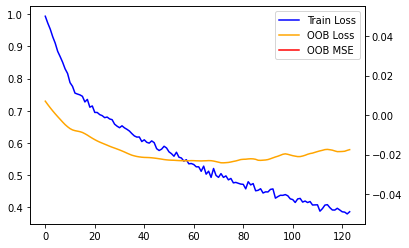

Bootstrap iteration 10 at time 2022-07-06 20:40:22.909654
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2222626209259033, OOB Loss: 1.862177848815918
Epoch: 40, Loss: 0.6273790597915649, OOB Loss: 0.7124179601669312
Epoch: 80, Loss: 0.5312740206718445, OOB Loss: 0.7304911613464355
Early stopped, best epoch: 38, train loss: 0.6211960911750793, best OOB loss: 0.7082001566886902, LR: 0.00039914564637483674


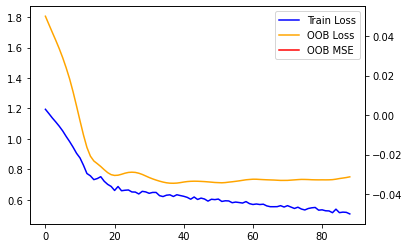

Bootstrap iteration 11 at time 2022-07-06 20:40:36.466630
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9058834314346313, OOB Loss: 0.883020281791687
Epoch: 40, Loss: 0.6132301092147827, OOB Loss: 0.6451639533042908
Epoch: 80, Loss: 0.45790839195251465, OOB Loss: 0.6380653381347656
Epoch: 120, Loss: 0.39336347579956055, OOB Loss: 0.635008692741394
Early stopped, best epoch: 104, train loss: 0.41217440366744995, best OOB loss: 0.6188694834709167, LR: 0.00033836316941939377


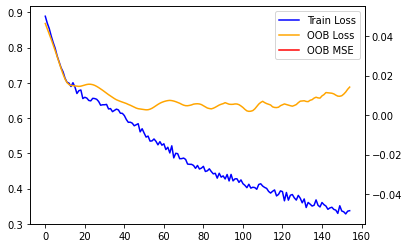

Bootstrap iteration 12 at time 2022-07-06 20:40:59.147685
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9022728800773621, OOB Loss: 1.1873512268066406
Epoch: 40, Loss: 0.5413419604301453, OOB Loss: 0.8268766403198242
Epoch: 80, Loss: 0.40456467866897583, OOB Loss: 0.9513852000236511
Early stopped, best epoch: 37, train loss: 0.5306984186172485, best OOB loss: 0.8252514600753784, LR: 0.0004001460114033451


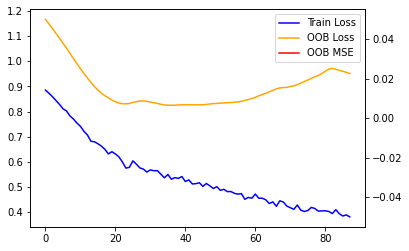

Bootstrap iteration 13 at time 2022-07-06 20:41:12.457166
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7926658987998962, OOB Loss: 1.7388644218444824
Epoch: 40, Loss: 0.5117110013961792, OOB Loss: 1.0868325233459473
Early stopped, best epoch: 25, train loss: 0.5505878925323486, best OOB loss: 1.0039373636245728, LR: 0.00041234776026425864


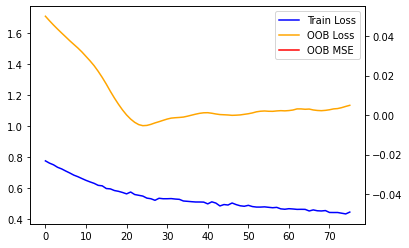

Bootstrap iteration 14 at time 2022-07-06 20:41:23.887156
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.02298903465271, OOB Loss: 0.43704184889793396
Epoch: 40, Loss: 0.6707960367202759, OOB Loss: 0.31754904985427856
Epoch: 80, Loss: 0.5411478281021118, OOB Loss: 0.30183398723602295
Epoch: 120, Loss: 0.45278191566467285, OOB Loss: 0.3001806139945984
Early stopped, best epoch: 104, train loss: 0.47835344076156616, best OOB loss: 0.29712364077568054, LR: 0.00033836316941939377


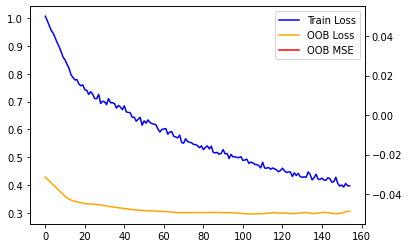

Bootstrap iteration 15 at time 2022-07-06 20:41:47.267239
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.49601411819458, OOB Loss: 0.5651273727416992
Epoch: 40, Loss: 0.705854594707489, OOB Loss: 0.3891948163509369
Epoch: 80, Loss: 0.5867599844932556, OOB Loss: 0.364176481962204
Epoch: 120, Loss: 0.49526143074035645, OOB Loss: 0.35857877135276794
Epoch: 160, Loss: 0.4258904457092285, OOB Loss: 0.360792875289917
Early stopped, best epoch: 126, train loss: 0.49062222242355347, best OOB loss: 0.35674524307250977, LR: 0.00032023366088401164


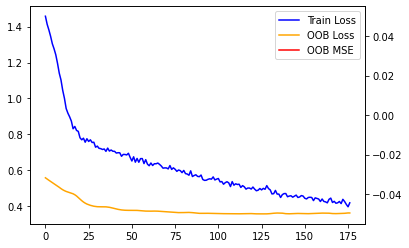

Bootstrap iteration 16 at time 2022-07-06 20:42:14.253105
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9830489158630371, OOB Loss: 1.255617618560791
Epoch: 40, Loss: 0.5315449237823486, OOB Loss: 0.960061252117157
Early stopped, best epoch: 23, train loss: 0.5729954242706299, best OOB loss: 0.8644689321517944, LR: 0.00041441725643859886


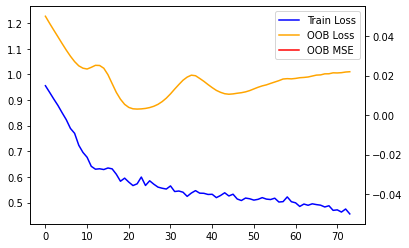

Bootstrap iteration 17 at time 2022-07-06 20:42:25.391259
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1528910398483276, OOB Loss: 1.7773168087005615
Epoch: 40, Loss: 0.5423304438591003, OOB Loss: 1.2266606092453003
Early stopped, best epoch: 27, train loss: 0.5803285837173462, best OOB loss: 1.038323163986206, LR: 0.00041028859863643906


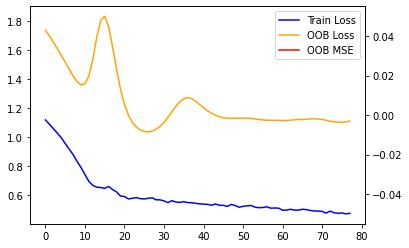

Bootstrap iteration 18 at time 2022-07-06 20:42:36.875699
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3182399272918701, OOB Loss: 0.5553854703903198
Epoch: 40, Loss: 0.6861516237258911, OOB Loss: 0.3508335053920746
Epoch: 80, Loss: 0.5743721723556519, OOB Loss: 0.3478306233882904
Epoch: 120, Loss: 0.4738759398460388, OOB Loss: 0.34484243392944336
Epoch: 160, Loss: 0.4168054461479187, OOB Loss: 0.34163790941238403
Epoch: 200, Loss: 0.36622804403305054, OOB Loss: 0.3568297326564789
Early stopped, best epoch: 158, train loss: 0.41407510638237, best OOB loss: 0.340599000453949, LR: 0.00029558331785413394


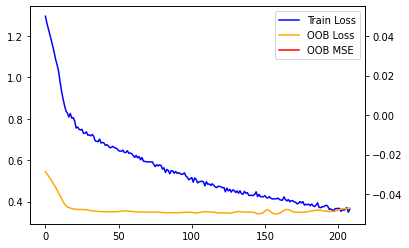

Bootstrap iteration 19 at time 2022-07-06 20:43:07.392456
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7519044876098633, OOB Loss: 1.5853781700134277
Epoch: 40, Loss: 0.5142362117767334, OOB Loss: 1.115090012550354
Epoch: 80, Loss: 0.4304203987121582, OOB Loss: 1.0362344980239868
Epoch: 120, Loss: 0.3524121642112732, OOB Loss: 1.2114557027816772
Early stopped, best epoch: 82, train loss: 0.4243229329586029, best OOB loss: 1.032987117767334, LR: 0.00035751905063161196


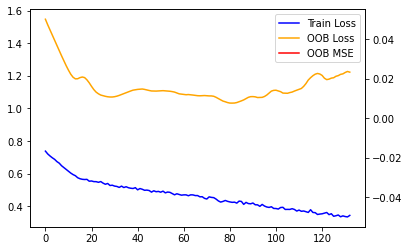

Bootstrap iteration 20 at time 2022-07-06 20:43:26.853536
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9986035823822021, OOB Loss: 0.4524856507778168
Epoch: 40, Loss: 0.6489455103874207, OOB Loss: 0.36925697326660156
Epoch: 80, Loss: 0.5173712968826294, OOB Loss: 0.3522280156612396
Epoch: 120, Loss: 0.4468262195587158, OOB Loss: 0.34406012296676636
Epoch: 160, Loss: 0.3744596242904663, OOB Loss: 0.34790295362472534
Early stopped, best epoch: 136, train loss: 0.4076100289821625, best OOB loss: 0.3388330936431885, LR: 0.0003123172872599734


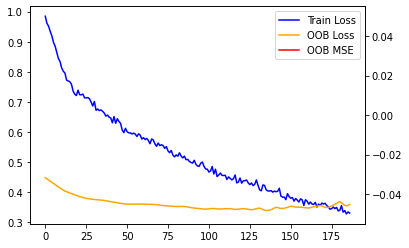

Bootstrap iteration 21 at time 2022-07-06 20:43:54.885552
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9185277819633484, OOB Loss: 0.6625608801841736
Epoch: 40, Loss: 0.6166695356369019, OOB Loss: 0.5370263457298279
Epoch: 80, Loss: 0.47143346071243286, OOB Loss: 0.5217276811599731
Epoch: 120, Loss: 0.4038901925086975, OOB Loss: 0.5201578140258789
Epoch: 160, Loss: 0.3458506464958191, OOB Loss: 0.5383164882659912
Early stopped, best epoch: 117, train loss: 0.40726932883262634, best OOB loss: 0.5177692770957947, LR: 0.0003275298158059346


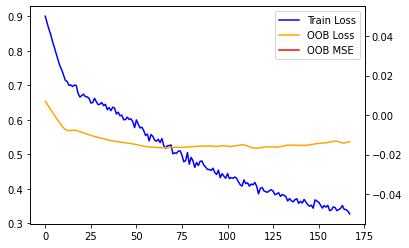

Bootstrap iteration 22 at time 2022-07-06 20:44:20.079831
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1903284788131714, OOB Loss: 0.42119503021240234
Epoch: 40, Loss: 0.6857839822769165, OOB Loss: 0.32746466994285583
Epoch: 80, Loss: 0.5641684532165527, OOB Loss: 0.31508922576904297
Epoch: 120, Loss: 0.4720842242240906, OOB Loss: 0.30898433923721313
Epoch: 160, Loss: 0.4005887508392334, OOB Loss: 0.30940207839012146
Early stopped, best epoch: 146, train loss: 0.42053720355033875, best OOB loss: 0.3057871162891388, LR: 0.00030459661127491027


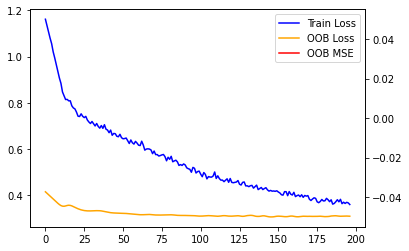

Bootstrap iteration 23 at time 2022-07-06 20:44:49.130823
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3149962425231934, OOB Loss: 0.6370630264282227
Epoch: 40, Loss: 0.6571962237358093, OOB Loss: 0.3856971859931946
Epoch: 80, Loss: 0.5686259269714355, OOB Loss: 0.3619982600212097
Epoch: 120, Loss: 0.47051748633384705, OOB Loss: 0.3655322790145874
Early stopped, best epoch: 107, train loss: 0.5080190896987915, best OOB loss: 0.35889142751693726, LR: 0.00033667346834210566


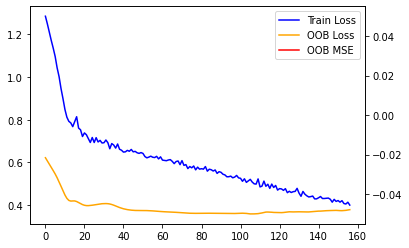

Bootstrap iteration 24 at time 2022-07-06 20:45:12.666404
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0219769477844238, OOB Loss: 0.894864559173584
Epoch: 40, Loss: 0.5912944078445435, OOB Loss: 0.6813368797302246
Epoch: 80, Loss: 0.4653472900390625, OOB Loss: 0.6817907691001892
Early stopped, best epoch: 57, train loss: 0.5155670642852783, best OOB loss: 0.6747311949729919, LR: 0.00038060683174957196


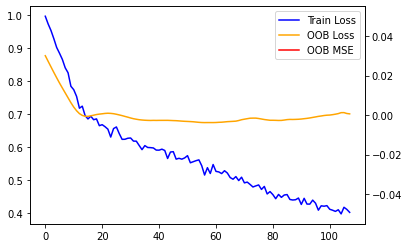

Bootstrap iteration 25 at time 2022-07-06 20:45:28.717781
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.296697974205017, OOB Loss: 0.6004697680473328
Epoch: 40, Loss: 0.6836894750595093, OOB Loss: 0.3931669592857361
Epoch: 80, Loss: 0.5668863654136658, OOB Loss: 0.3680967092514038
Epoch: 120, Loss: 0.47255462408065796, OOB Loss: 0.370874285697937
Early stopped, best epoch: 77, train loss: 0.5732399821281433, best OOB loss: 0.36779293417930603, LR: 0.0003620217526757433


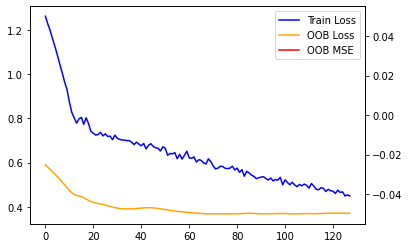

Bootstrap iteration 26 at time 2022-07-06 20:45:47.914358
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3328864574432373, OOB Loss: 0.576348066329956
Epoch: 40, Loss: 0.7027093768119812, OOB Loss: 0.3724913001060486
Epoch: 80, Loss: 0.6005679368972778, OOB Loss: 0.33926424384117126
Epoch: 120, Loss: 0.48152849078178406, OOB Loss: 0.31792590022087097
Epoch: 160, Loss: 0.4021869897842407, OOB Loss: 0.3125596046447754
Epoch: 200, Loss: 0.3559425473213196, OOB Loss: 0.31227725744247437
Early stopped, best epoch: 165, train loss: 0.4137387275695801, best OOB loss: 0.30644726753234863, LR: 0.0002904492438585402


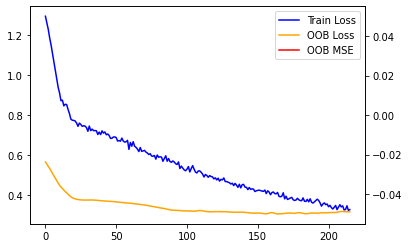

Bootstrap iteration 27 at time 2022-07-06 20:46:20.588606
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1036818027496338, OOB Loss: 0.7749365568161011
Epoch: 40, Loss: 0.6310150027275085, OOB Loss: 0.6249372363090515
Epoch: 80, Loss: 0.5067214369773865, OOB Loss: 0.6823377013206482
Early stopped, best epoch: 44, train loss: 0.6336373090744019, best OOB loss: 0.6206303834915161, LR: 0.0003931957570841881


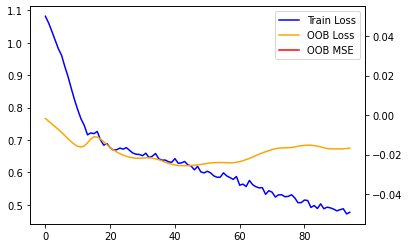

Bootstrap iteration 28 at time 2022-07-06 20:46:35.112676
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9688023328781128, OOB Loss: 1.3734420537948608
Epoch: 40, Loss: 0.5818471908569336, OOB Loss: 0.7933074831962585
Epoch: 80, Loss: 0.46595120429992676, OOB Loss: 0.8796329498291016
Early stopped, best epoch: 52, train loss: 0.5401397943496704, best OOB loss: 0.7806040048599243, LR: 0.0003854003082267038


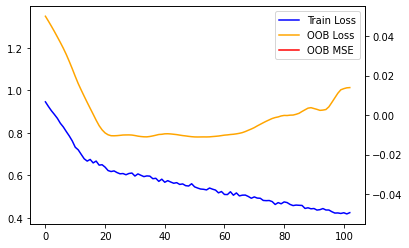

Bootstrap iteration 29 at time 2022-07-06 20:46:50.542072
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7490727305412292, OOB Loss: 1.7023611068725586
Epoch: 40, Loss: 0.5074957609176636, OOB Loss: 0.972827136516571
Epoch: 80, Loss: 0.42003464698791504, OOB Loss: 0.9922932386398315
Early stopped, best epoch: 57, train loss: 0.47236499190330505, best OOB loss: 0.9193086624145508, LR: 0.00038060683174957196


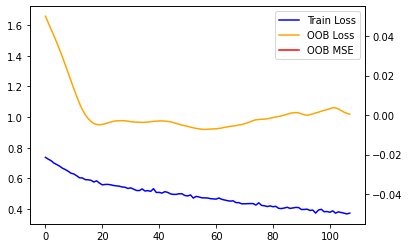

Bootstrap iteration 30 at time 2022-07-06 20:47:06.308700
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.4961605072021484, OOB Loss: 1.0377103090286255
Epoch: 40, Loss: 0.6419846415519714, OOB Loss: 0.66679447889328
Epoch: 80, Loss: 0.5310580134391785, OOB Loss: 0.6392639875411987
Epoch: 120, Loss: 0.4413717985153198, OOB Loss: 0.6538996696472168
Early stopped, best epoch: 98, train loss: 0.48058637976646423, best OOB loss: 0.6386876106262207, LR: 0.0003443441853315194


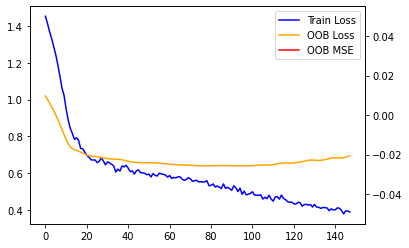

Bootstrap iteration 31 at time 2022-07-06 20:47:28.777309
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9713651537895203, OOB Loss: 0.6676845550537109
Epoch: 40, Loss: 0.6227770447731018, OOB Loss: 0.4804784953594208
Epoch: 80, Loss: 0.49548929929733276, OOB Loss: 0.48490452766418457
Early stopped, best epoch: 51, train loss: 0.5871614217758179, best OOB loss: 0.47966527938842773, LR: 0.0003883053234953742


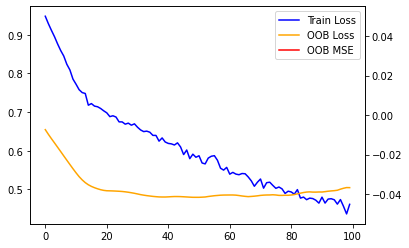

Bootstrap iteration 32 at time 2022-07-06 20:47:44.096090
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.4873311519622803, OOB Loss: 0.6893681883811951
Epoch: 40, Loss: 0.6912845969200134, OOB Loss: 0.3781989514827728
Epoch: 80, Loss: 0.5845192670822144, OOB Loss: 0.3679901957511902
Epoch: 120, Loss: 0.48800548911094666, OOB Loss: 0.37460994720458984
Early stopped, best epoch: 81, train loss: 0.5789521932601929, best OOB loss: 0.36783844232559204, LR: 0.0003584150883524932


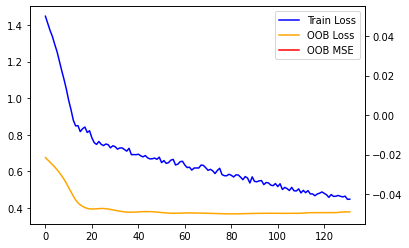

Bootstrap iteration 33 at time 2022-07-06 20:48:03.995222
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0147231817245483, OOB Loss: 1.109703540802002
Epoch: 40, Loss: 0.6041816473007202, OOB Loss: 0.6778087615966797
Epoch: 80, Loss: 0.47258490324020386, OOB Loss: 0.6912767291069031
Early stopped, best epoch: 47, train loss: 0.5442404747009277, best OOB loss: 0.6734062433242798, LR: 0.00039025415518281834


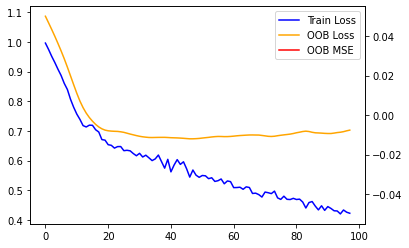

Bootstrap iteration 34 at time 2022-07-06 20:48:18.992682
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.062825322151184, OOB Loss: 0.7022193670272827
Epoch: 40, Loss: 0.6488889455795288, OOB Loss: 0.5076887011528015
Epoch: 80, Loss: 0.5332309007644653, OOB Loss: 0.4851982295513153
Epoch: 120, Loss: 0.4409319758415222, OOB Loss: 0.48072195053100586
Epoch: 160, Loss: 0.37512946128845215, OOB Loss: 0.4805266261100769
Early stopped, best epoch: 115, train loss: 0.45719385147094727, best OOB loss: 0.4771498143672943, LR: 0.00032999862316169143


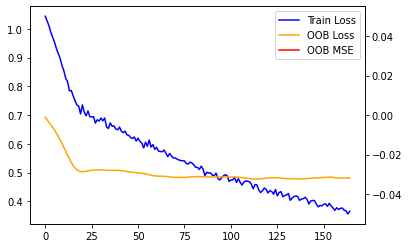

Bootstrap iteration 35 at time 2022-07-06 20:48:43.557994
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.6909977793693542, OOB Loss: 1.6870002746582031
Epoch: 40, Loss: 0.47173404693603516, OOB Loss: 1.3077800273895264
Early stopped, best epoch: 24, train loss: 0.515985369682312, best OOB loss: 1.248401403427124, LR: 0.0004133812132975024


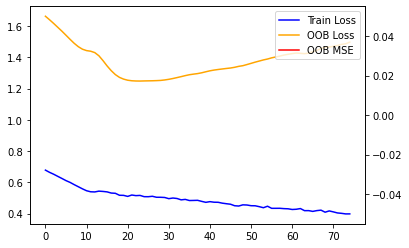

Bootstrap iteration 36 at time 2022-07-06 20:48:54.888908
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0423120260238647, OOB Loss: 0.9763293266296387
Epoch: 40, Loss: 0.5880138874053955, OOB Loss: 0.6672229766845703
Early stopped, best epoch: 18, train loss: 0.7002627849578857, best OOB loss: 0.6502330303192139, LR: 0.00041963655153460226


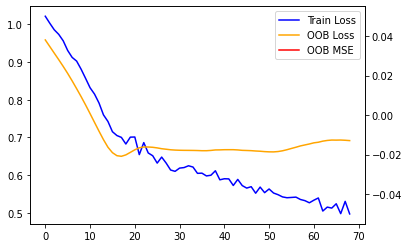

Bootstrap iteration 37 at time 2022-07-06 20:49:05.414379
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0389821529388428, OOB Loss: 1.5823545455932617
Epoch: 40, Loss: 0.519228994846344, OOB Loss: 1.1246132850646973
Epoch: 80, Loss: 0.4689280390739441, OOB Loss: 1.120985984802246
Early stopped, best epoch: 47, train loss: 0.5188505053520203, best OOB loss: 1.0712904930114746, LR: 0.00039025415518281834


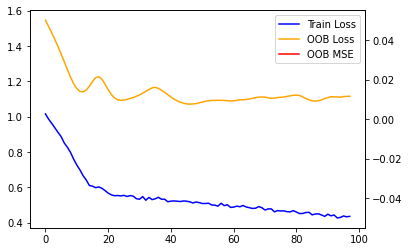

Bootstrap iteration 38 at time 2022-07-06 20:49:19.799380
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9141693115234375, OOB Loss: 1.3265595436096191
Epoch: 40, Loss: 0.548783540725708, OOB Loss: 0.9440387487411499
Epoch: 80, Loss: 0.4653814733028412, OOB Loss: 0.9267942905426025
Early stopped, best epoch: 49, train loss: 0.5367326736450195, best OOB loss: 0.9128502607345581, LR: 0.0003883053234953742


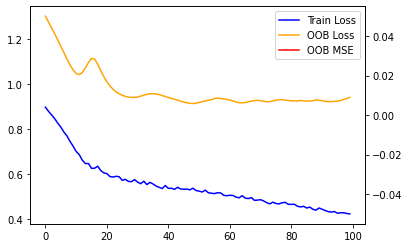

Bootstrap iteration 39 at time 2022-07-06 20:49:34.957860
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.4018200635910034, OOB Loss: 0.500169575214386
Epoch: 40, Loss: 0.6772364377975464, OOB Loss: 0.37713027000427246
Epoch: 80, Loss: 0.5924482941627502, OOB Loss: 0.3761955201625824
Epoch: 120, Loss: 0.47680172324180603, OOB Loss: 0.3800680637359619
Early stopped, best epoch: 82, train loss: 0.5848820209503174, best OOB loss: 0.3741280436515808, LR: 0.00035751905063161196


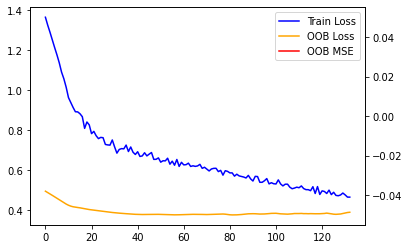

Bootstrap iteration 40 at time 2022-07-06 20:49:54.993568
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.255354404449463, OOB Loss: 1.3912019729614258
Epoch: 40, Loss: 0.5925317406654358, OOB Loss: 0.7839121222496033
Epoch: 80, Loss: 0.48675185441970825, OOB Loss: 0.8856678009033203
Early stopped, best epoch: 38, train loss: 0.5852214694023132, best OOB loss: 0.782880961894989, LR: 0.00039914564637483674


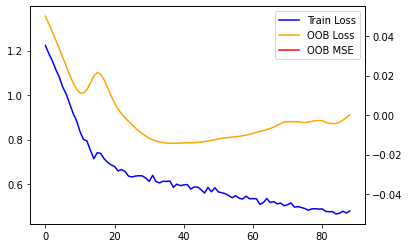

Bootstrap iteration 41 at time 2022-07-06 20:50:08.449958
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0316544771194458, OOB Loss: 1.401099681854248
Epoch: 40, Loss: 0.5766565203666687, OOB Loss: 0.862646758556366
Epoch: 80, Loss: 0.4891899526119232, OOB Loss: 1.032435417175293
Early stopped, best epoch: 36, train loss: 0.5954746603965759, best OOB loss: 0.8527045249938965, LR: 0.000401148883612376


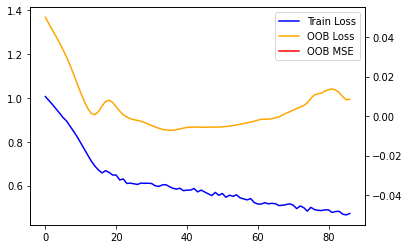

Bootstrap iteration 42 at time 2022-07-06 20:50:21.745041
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9252809882164001, OOB Loss: 1.9628710746765137
Epoch: 40, Loss: 0.5187976360321045, OOB Loss: 1.2389748096466064
Epoch: 80, Loss: 0.43124884366989136, OOB Loss: 1.2880945205688477
Early stopped, best epoch: 51, train loss: 0.4925347566604614, best OOB loss: 1.1483378410339355, LR: 0.0003863662237861692


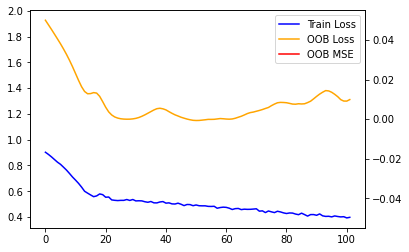

Bootstrap iteration 43 at time 2022-07-06 20:50:37.130197
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3757286071777344, OOB Loss: 0.5719714164733887
Epoch: 40, Loss: 0.6837674975395203, OOB Loss: 0.3670240342617035
Epoch: 80, Loss: 0.558346688747406, OOB Loss: 0.3443776071071625
Epoch: 120, Loss: 0.46662330627441406, OOB Loss: 0.35190388560295105
Early stopped, best epoch: 93, train loss: 0.5312551259994507, best OOB loss: 0.34049615263938904, LR: 0.000347809256776649


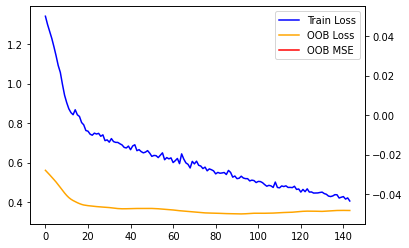

Bootstrap iteration 44 at time 2022-07-06 20:50:59.268530
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9770991206169128, OOB Loss: 1.4541276693344116
Epoch: 40, Loss: 0.522964358329773, OOB Loss: 0.9641437530517578
Early stopped, best epoch: 24, train loss: 0.5837199687957764, best OOB loss: 0.9403025507926941, LR: 0.0004133812132975024


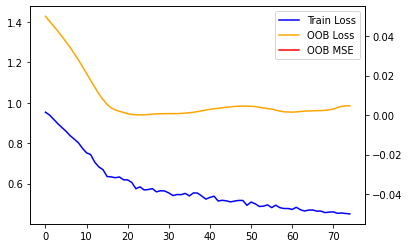

Bootstrap iteration 45 at time 2022-07-06 20:51:10.539832
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0633400678634644, OOB Loss: 0.6762182712554932
Epoch: 40, Loss: 0.6260406970977783, OOB Loss: 0.5057899355888367
Epoch: 80, Loss: 0.5045362710952759, OOB Loss: 0.5136639475822449
Early stopped, best epoch: 55, train loss: 0.5857023000717163, best OOB loss: 0.5045287609100342, LR: 0.000382517026148903


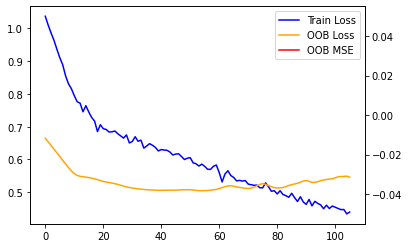

Bootstrap iteration 46 at time 2022-07-06 20:51:26.592242
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1824759244918823, OOB Loss: 1.078956961631775
Epoch: 40, Loss: 0.6129496097564697, OOB Loss: 0.7418197393417358
Epoch: 80, Loss: 0.5152532458305359, OOB Loss: 0.7679254412651062
Early stopped, best epoch: 56, train loss: 0.5586131811141968, best OOB loss: 0.734602153301239, LR: 0.00038156073358353075


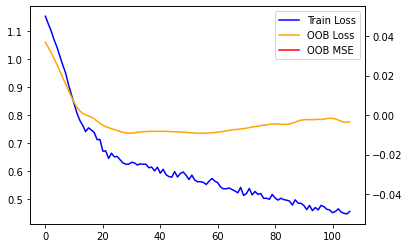

Bootstrap iteration 47 at time 2022-07-06 20:51:42.391723
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.150665521621704, OOB Loss: 1.112766146659851
Epoch: 40, Loss: 0.59318608045578, OOB Loss: 0.7028089761734009
Early stopped, best epoch: 21, train loss: 0.6528546810150146, best OOB loss: 0.6972081065177917, LR: 0.00041649713902661297


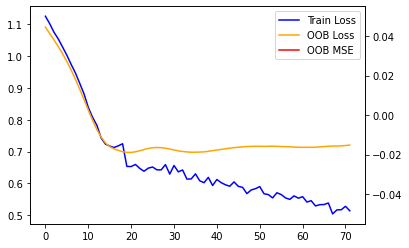

Bootstrap iteration 48 at time 2022-07-06 20:51:53.431818
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1898201704025269, OOB Loss: 0.9859272837638855
Epoch: 40, Loss: 0.634229302406311, OOB Loss: 0.7021535634994507
Epoch: 80, Loss: 0.5046562552452087, OOB Loss: 0.6957653760910034
Early stopped, best epoch: 63, train loss: 0.5599396228790283, best OOB loss: 0.6774461269378662, LR: 0.00037587297488416934


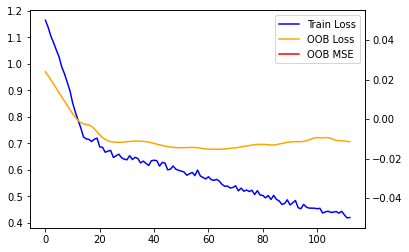

Bootstrap iteration 49 at time 2022-07-06 20:52:10.649340
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2414015531539917, OOB Loss: 0.8706318140029907
Epoch: 40, Loss: 0.6511867046356201, OOB Loss: 0.596537709236145
Epoch: 80, Loss: 0.536906898021698, OOB Loss: 0.5600647330284119
Epoch: 120, Loss: 0.44268888235092163, OOB Loss: 0.5685027837753296
Early stopped, best epoch: 92, train loss: 0.4838011860847473, best OOB loss: 0.5572589039802551, LR: 0.0003486809591745855


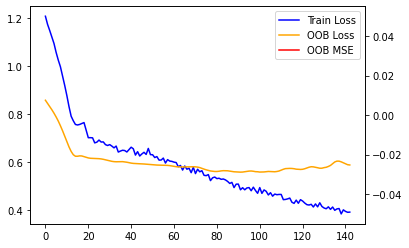

Time 0, 2022-07-06 20:52:32.972315
Time 5, 2022-07-06 21:07:42.118478
Time 10, 2022-07-06 21:22:04.473401
Time 15, 2022-07-06 21:36:19.466975
Time 20, 2022-07-06 21:50:33.171675
Time 25, 2022-07-06 22:04:53.762245
Time 30, 2022-07-06 22:19:11.964272
Time 35, 2022-07-06 22:33:28.109405
Time 40, 2022-07-06 22:47:43.154630
Time 45, 2022-07-06 23:02:07.709814
Time 50, 2022-07-06 23:16:24.230769
Time 55, 2022-07-06 23:30:40.728568
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: 1.8957058191299438, MSE: 1.5064741373062134
Epoch: 40, Loss: 1.0984692573547363, OOB Loss: 0.4266916513442993, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3479647636413574, MSE: 1.4538849592208862
Epoch: 80, Loss: 0.22474193572998047, OOB Loss: 0.23929643630981445, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0235676765441895, MSE: 1.4663236141204834
Epoch: 120, Loss: -0.4501912593841553, OOB Loss: 0.20536303520202637, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.6499786376953125, MSE: 1.4982746839523315
Epoch: 160, Loss: -1.0539236068725586, OOB Loss: 0.2907888889312744, LR: 0.0003341547246965484
Early stopped, best epoch: 125, train loss: -0.49129676818847656, best OOB loss: 0.15400147438049316, LR: 0.00032103625151279363


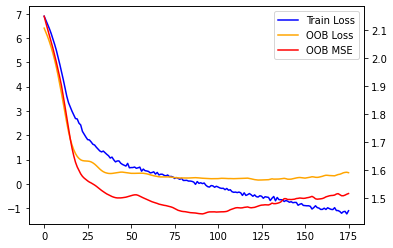

Bootstrap iteration 1 at time 2022-07-06 23:45:19.017185
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.627580642700195, MSE: 6.883810520172119
Epoch: 0, Loss: 7.185469627380371, OOB Loss: 7.460958480834961, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.7604190111160278, MSE: 4.101737022399902
Epoch: 40, Loss: 0.4379451274871826, OOB Loss: 3.1869654655456543, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9728870391845703, MSE: 3.912431478500366
Epoch: 80, Loss: -0.31209659576416016, OOB Loss: 3.5159482955932617, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.3166186809539795, best OOB loss: 3.0925662517547607, LR: 0.00039025415518281834


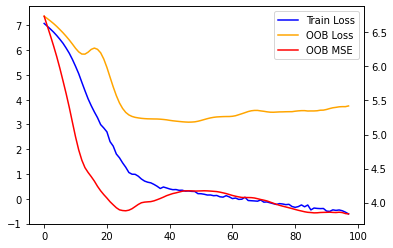

Bootstrap iteration 2 at time 2022-07-06 23:45:26.645935
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.304079055786133, MSE: 6.617680072784424
Epoch: 0, Loss: 6.0163893699646, OOB Loss: 6.479006290435791, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3808441162109375, MSE: 4.343861103057861
Epoch: 40, Loss: 0.5713865756988525, OOB Loss: 6.2520551681518555, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.276012659072876, MSE: 4.128935813903809
Epoch: 80, Loss: -0.07817864418029785, OOB Loss: 4.141878128051758, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.735396385192871, MSE: 3.9025135040283203
Epoch: 120, Loss: -0.6754884719848633, OOB Loss: 4.078167915344238, LR: 0.00036934432610923556
Early stopped, best epoch: 89, train loss: -0.2814490795135498, best OOB loss: 3.751347303390503, LR: 0.00035130919659078646


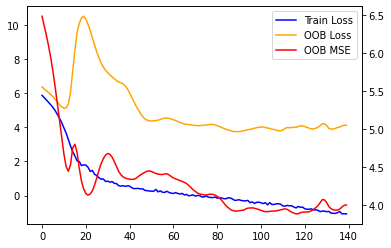

Bootstrap iteration 3 at time 2022-07-06 23:45:36.897813
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.126410007476807, MSE: 6.370398998260498
Epoch: 0, Loss: 6.652797222137451, OOB Loss: 7.169465065002441, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4493391513824463, MSE: 4.766729831695557
Epoch: 40, Loss: 0.2884492874145508, OOB Loss: 5.030790328979492, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.5234684944152832, MSE: 4.423586368560791
Epoch: 80, Loss: -0.3380465507507324, OOB Loss: 4.052544116973877, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.0632009506225586, best OOB loss: 3.6629204750061035, LR: 0.0003883053234953742


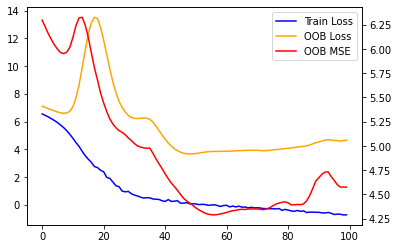

Bootstrap iteration 4 at time 2022-07-06 23:45:44.427083
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.5505781173706055, MSE: 4.191549301147461
Epoch: 0, Loss: 6.221999645233154, OOB Loss: 6.139764785766602, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1075832843780518, MSE: 2.8118252754211426
Epoch: 40, Loss: 0.8897426128387451, OOB Loss: 1.48048996925354, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5014920234680176, MSE: 2.9509990215301514
Epoch: 80, Loss: 0.18967962265014648, OOB Loss: 0.9932966232299805, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.5033159255981445, MSE: 3.384061813354492
Epoch: 120, Loss: -0.7217180728912354, OOB Loss: 1.317906379699707, LR: 0.00036934432610923556
Early stopped, best epoch: 101, train loss: -0.256361722946167, best OOB loss: 0.9854817390441895, LR: 0.00034091363487709353


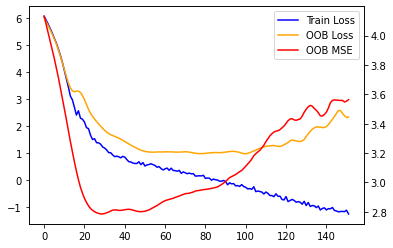

Bootstrap iteration 5 at time 2022-07-06 23:45:56.018971
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.538972854614258, MSE: 1.7703717947006226
Epoch: 0, Loss: 7.159666538238525, OOB Loss: 6.759171485900879, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.131593942642212, MSE: 1.1909065246582031
Epoch: 40, Loss: 1.2681299448013306, OOB Loss: 0.0521697998046875, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5286805629730225, MSE: 1.1482609510421753
Epoch: 80, Loss: 0.2884957790374756, OOB Loss: 0.16399598121643066, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.9376134872436523, best OOB loss: -0.03954005241394043, LR: 0.00039025415518281834


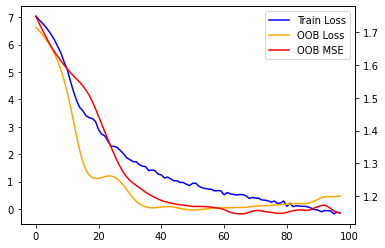

Bootstrap iteration 6 at time 2022-07-06 23:46:03.689625
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.983631610870361, MSE: 1.8558156490325928
Epoch: 0, Loss: 6.7630085945129395, OOB Loss: 6.246731281280518, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.740581750869751, MSE: 1.3844879865646362
Epoch: 40, Loss: 1.0161848068237305, OOB Loss: 0.1984109878540039, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3405978679656982, MSE: 1.3683499097824097
Epoch: 80, Loss: 0.12163496017456055, OOB Loss: 0.017220020294189453, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.7793171405792236, MSE: 1.4011489152908325
Epoch: 120, Loss: -0.4281487464904785, OOB Loss: 0.07036852836608887, LR: 0.00036934432610923556
Early stopped, best epoch: 106, train loss: -0.26933765411376953, best OOB loss: -5.221366882324219e-05, LR: 0.0003548443556478391


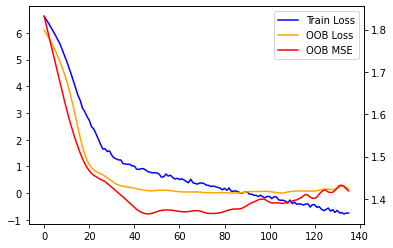

Bootstrap iteration 7 at time 2022-07-06 23:46:14.434033
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.541790962219238, MSE: 2.5997798442840576
Epoch: 0, Loss: 7.212587356567383, OOB Loss: 6.872079372406006, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.2254159450531006, MSE: 1.768187165260315
Epoch: 40, Loss: 1.0203800201416016, OOB Loss: 1.1311218738555908, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.715620279312134, MSE: 1.7267553806304932
Epoch: 80, Loss: 0.27756190299987793, OOB Loss: 1.1968061923980713, LR: 0.00040823971994699836
Early stopped, best epoch: 35, train loss: 1.336279273033142, best OOB loss: 0.9020380973815918, LR: 0.00040215426928559


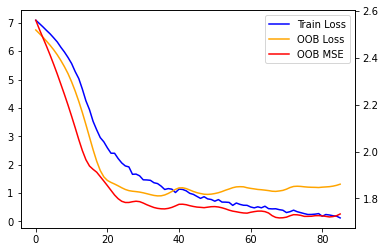

Bootstrap iteration 8 at time 2022-07-06 23:46:21.207295
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.881523132324219, MSE: 3.378511667251587
Epoch: 0, Loss: 6.537387847900391, OOB Loss: 6.3540544509887695, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8476122617721558, MSE: 2.1548874378204346
Epoch: 40, Loss: 1.0284522771835327, OOB Loss: 1.1040016412734985, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.5990235805511475, MSE: 2.1376798152923584
Epoch: 80, Loss: 0.2290041446685791, OOB Loss: 0.6589305400848389, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.105867624282837, MSE: 2.1149916648864746
Epoch: 120, Loss: -0.5279028415679932, OOB Loss: 0.5132434368133545, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.8045332431793213, MSE: 2.1588258743286133
Epoch: 160, Loss: -1.0775103569030762, OOB Loss: 0.8630392551422119, LR: 0.0003341547246965484
Early stopped, best epoch: 123, train loss: -0.595146894454956, best OO

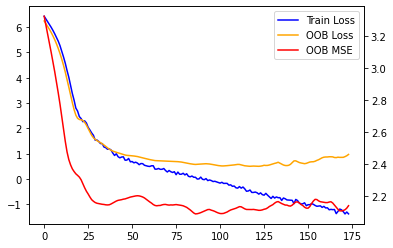

Bootstrap iteration 9 at time 2022-07-06 23:46:34.866671
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.702471733093262, MSE: 4.984714031219482
Epoch: 0, Loss: 6.332480430603027, OOB Loss: 6.743646144866943, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.146939277648926, MSE: 3.8790218830108643
Epoch: 40, Loss: 0.4349808692932129, OOB Loss: 4.665172576904297, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3285703659057617, MSE: 4.067694187164307
Epoch: 80, Loss: -0.34197211265563965, OOB Loss: 3.9207539558410645, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.0971519947052002, best OOB loss: 3.3288862705230713, LR: 0.0003834757154374967


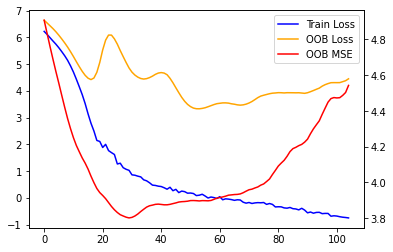

Bootstrap iteration 10 at time 2022-07-06 23:46:42.655756
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.179571628570557, MSE: 4.748335838317871
Epoch: 0, Loss: 6.06743860244751, OOB Loss: 6.271121025085449, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4741952419281006, MSE: 3.742584705352783
Epoch: 40, Loss: 0.4432566165924072, OOB Loss: 4.127967834472656, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9324281215667725, MSE: 3.423285722732544
Epoch: 80, Loss: -0.35642290115356445, OOB Loss: 3.620887041091919, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: -0.20595216751098633, best OOB loss: 3.450016736984253, LR: 0.00037119799610227123


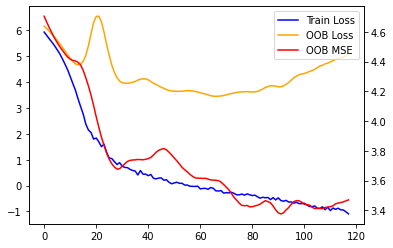

Bootstrap iteration 11 at time 2022-07-06 23:46:51.491487
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.710692405700684, MSE: 6.816610813140869
Epoch: 0, Loss: 7.230504989624023, OOB Loss: 7.713569641113281, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.4854551553726196, MSE: 5.334351539611816
Epoch: 40, Loss: 0.16286468505859375, OOB Loss: 7.234440326690674, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.89115309715271, MSE: 6.094333171844482
Epoch: 80, Loss: -0.48131370544433594, OOB Loss: 7.854477882385254, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: -0.12760186195373535, best OOB loss: 6.004298686981201, LR: 0.0003854003082267038


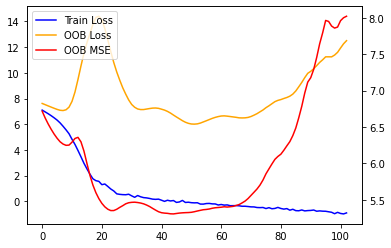

Bootstrap iteration 12 at time 2022-07-06 23:46:58.740565
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.409628391265869, MSE: 3.519753932952881
Epoch: 0, Loss: 7.941402435302734, OOB Loss: 7.71257209777832, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.584136962890625, MSE: 2.756925344467163
Epoch: 40, Loss: 0.7922396659851074, OOB Loss: 3.396665096282959, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9637093544006348, MSE: 2.8056931495666504
Epoch: 80, Loss: -0.041284799575805664, OOB Loss: 2.950815200805664, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.498790979385376, MSE: 2.639908790588379
Epoch: 120, Loss: -0.5782437324523926, OOB Loss: 2.7970259189605713, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.9715330600738525, MSE: 2.6033456325531006
Epoch: 160, Loss: -1.2110185623168945, OOB Loss: 3.2731101512908936, LR: 0.0003341547246965484
Early stopped, best epoch: 117, train loss: -0.5865042209625244, best OOB 

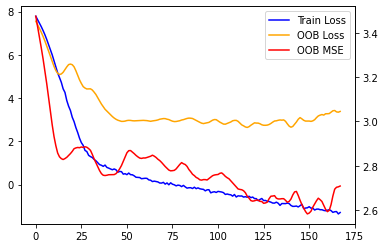

Bootstrap iteration 13 at time 2022-07-06 23:47:10.945131
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.977175235748291, MSE: 2.1016499996185303
Epoch: 0, Loss: 7.565952777862549, OOB Loss: 7.1832404136657715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.8616433143615723, MSE: 1.5684621334075928
Epoch: 40, Loss: 1.0518896579742432, OOB Loss: 0.7081632614135742, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1823835372924805, MSE: 1.5991969108581543
Epoch: 80, Loss: 0.05938720703125, OOB Loss: 0.6810188293457031, LR: 0.00040823971994699836
Early stopped, best epoch: 62, train loss: 0.4477052688598633, best OOB loss: 0.6112954616546631, LR: 0.00037587297488416934


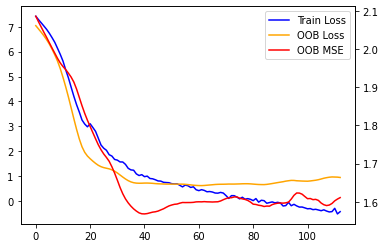

Bootstrap iteration 14 at time 2022-07-06 23:47:19.795972
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.608548164367676, MSE: 1.6736968755722046
Epoch: 0, Loss: 6.503054618835449, OOB Loss: 5.898533821105957, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7569007873535156, MSE: 1.1685049533843994
Epoch: 40, Loss: 1.288935899734497, OOB Loss: -0.2999269962310791, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.2403957843780518, MSE: 1.1033447980880737
Epoch: 80, Loss: 0.4479234218597412, OOB Loss: -0.5171422958374023, LR: 0.00040823971994699836
Early stopped, best epoch: 86, train loss: 0.38115358352661133, best OOB loss: -0.5508236885070801, LR: 0.00040215426928559


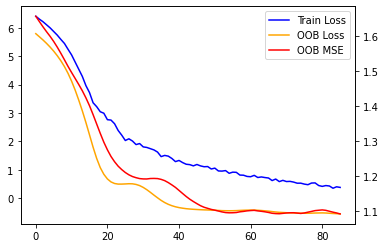

Bootstrap iteration 15 at time 2022-07-06 23:47:27.152978
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.055125713348389, MSE: 3.6934258937835693
Epoch: 0, Loss: 6.7901291847229, OOB Loss: 6.596019744873047, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.0999184846878052, MSE: 2.0292716026306152
Epoch: 40, Loss: 0.5837628841400146, OOB Loss: 1.531333327293396, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9728732109069824, MSE: 2.0252442359924316
Epoch: 80, Loss: -0.2239527702331543, OOB Loss: 1.4070076942443848, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.582960605621338, MSE: 2.0199272632598877
Epoch: 120, Loss: -0.7788999080657959, OOB Loss: 1.493743896484375, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: -0.28972411155700684, best OOB loss: 1.3295035362243652, LR: 0.0003504309235993095


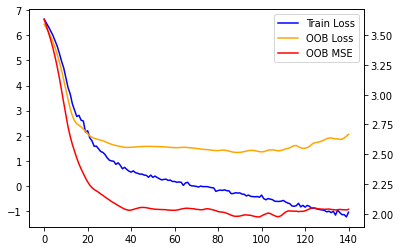

Bootstrap iteration 16 at time 2022-07-06 23:47:37.912775
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.9880170822143555, MSE: 3.947617769241333
Epoch: 0, Loss: 6.151907444000244, OOB Loss: 5.94163179397583, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1138341426849365, MSE: 2.295839548110962
Epoch: 40, Loss: 0.6327023506164551, OOB Loss: 1.4160594940185547, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.566007137298584, MSE: 2.208484172821045
Epoch: 80, Loss: -0.21208906173706055, OOB Loss: 1.4821367263793945, LR: 0.00040823971994699836
Early stopped, best epoch: 42, train loss: 0.5154521465301514, best OOB loss: 1.40249764919281, LR: 0.00039516913294181626


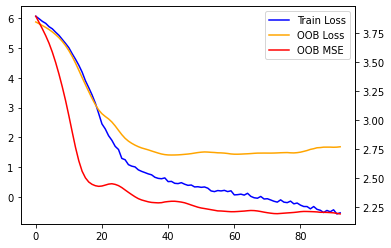

Bootstrap iteration 17 at time 2022-07-06 23:47:45.271752
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.189188480377197, MSE: 3.4519670009613037
Epoch: 0, Loss: 6.234409332275391, OOB Loss: 5.9166131019592285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.215639591217041, MSE: 2.3440451622009277
Epoch: 40, Loss: 0.9030954837799072, OOB Loss: 0.774658203125, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0164287090301514, MSE: 2.3419830799102783
Epoch: 80, Loss: -0.011617898941040039, OOB Loss: 0.8765068054199219, LR: 0.00040823971994699836
Early stopped, best epoch: 43, train loss: 0.7656576633453369, best OOB loss: 0.740462064743042, LR: 0.00039418121010946174


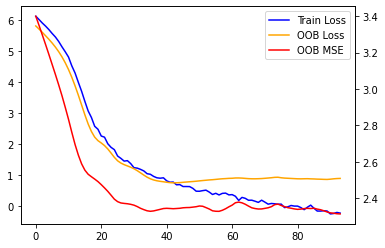

Bootstrap iteration 18 at time 2022-07-06 23:47:52.705767
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.14180326461792, MSE: 3.786393404006958
Epoch: 0, Loss: 7.697353363037109, OOB Loss: 7.503801345825195, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1528737545013428, MSE: 1.7872610092163086
Epoch: 40, Loss: 1.1690797805786133, OOB Loss: 0.7816417217254639, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.481200933456421, MSE: 1.6918138265609741
Epoch: 80, Loss: 0.33022332191467285, OOB Loss: 0.577357292175293, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.203707456588745, MSE: 1.6182376146316528
Epoch: 120, Loss: -0.26259326934814453, OOB Loss: 0.42499279975891113, LR: 0.00036934432610923556
Early stopped, best epoch: 106, train loss: -0.010855674743652344, best OOB loss: 0.36476945877075195, LR: 0.00033667346834210566


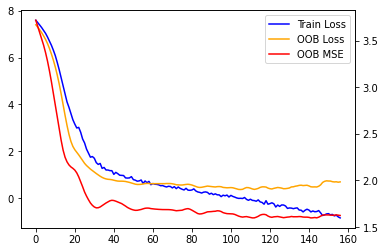

Bootstrap iteration 19 at time 2022-07-06 23:48:04.739392
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.809247970581055, MSE: 3.6381676197052
Epoch: 0, Loss: 6.617578029632568, OOB Loss: 6.401082992553711, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.234520673751831, MSE: 2.1198549270629883
Epoch: 40, Loss: 0.6239509582519531, OOB Loss: 1.5154221057891846, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.4004961252212524, MSE: 2.0731494426727295
Epoch: 80, Loss: -0.12971949577331543, OOB Loss: 1.3734174966812134, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 1.952486276626587, MSE: 2.066190481185913
Epoch: 120, Loss: -0.7228760719299316, OOB Loss: 1.484830617904663, LR: 0.00036934432610923556
Early stopped, best epoch: 106, train loss: -0.5668272972106934, best OOB loss: 1.3444055318832397, LR: 0.00033667346834210566


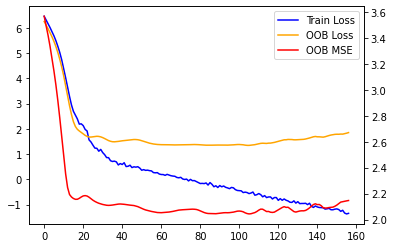

Bootstrap iteration 20 at time 2022-07-06 23:48:16.505119
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.260431289672852, MSE: 3.3625528812408447
Epoch: 0, Loss: 7.7265625, OOB Loss: 7.5942912101745605, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5228006839752197, MSE: 2.3994691371917725
Epoch: 40, Loss: 0.9045155048370361, OOB Loss: 3.161639451980591, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.294114589691162, MSE: 2.312300443649292
Epoch: 80, Loss: 0.051700592041015625, OOB Loss: 2.1883559226989746, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.878261089324951, MSE: 2.208275556564331
Epoch: 120, Loss: -0.4626481533050537, OOB Loss: 2.206254005432129, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: -0.03593921661376953, best OOB loss: 1.9579012393951416, LR: 0.0003504309235993095


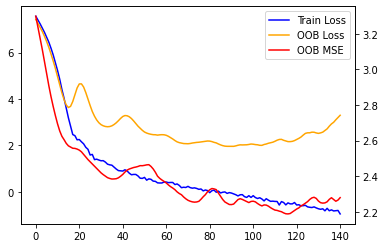

Bootstrap iteration 21 at time 2022-07-06 23:48:27.227397
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.575047016143799, MSE: 2.095135450363159
Epoch: 0, Loss: 6.515302658081055, OOB Loss: 5.923944473266602, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.576925039291382, MSE: 1.2261253595352173
Epoch: 40, Loss: 1.292527675628662, OOB Loss: 0.18559813499450684, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.6123905181884766, MSE: 1.1522752046585083
Epoch: 80, Loss: 0.31139564514160156, OOB Loss: 0.10933184623718262, LR: 0.00040823971994699836
Early stopped, best epoch: 57, train loss: 0.6453557014465332, best OOB loss: -0.009497404098510742, LR: 0.0003863662237861692


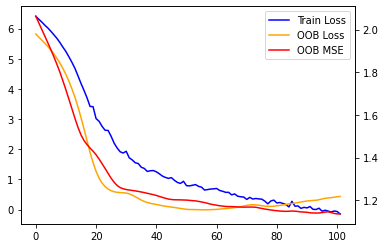

Bootstrap iteration 22 at time 2022-07-06 23:48:35.533214
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.132654190063477, MSE: 5.610628604888916
Epoch: 0, Loss: 5.952810287475586, OOB Loss: 6.056267261505127, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0575754642486572, MSE: 3.4562902450561523
Epoch: 40, Loss: 0.8001620769500732, OOB Loss: 1.8596384525299072, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6718008518218994, MSE: 3.1735520362854004
Epoch: 80, Loss: -0.04478049278259277, OOB Loss: 1.5068609714508057, LR: 0.00040823971994699836
Early stopped, best epoch: 59, train loss: 0.27735066413879395, best OOB loss: 1.425865650177002, LR: 0.00037870617638352256


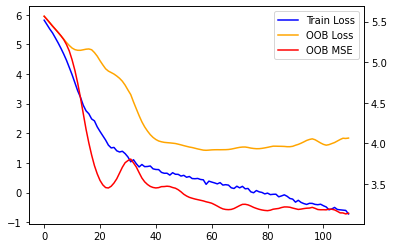

Bootstrap iteration 23 at time 2022-07-06 23:48:44.246210
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.379426956176758, MSE: 2.2693567276000977
Epoch: 0, Loss: 7.9023637771606445, OOB Loss: 7.591527462005615, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.28130841255188, MSE: 1.5011539459228516
Epoch: 40, Loss: 1.0353138446807861, OOB Loss: 0.10624575614929199, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4711410999298096, MSE: 1.4220850467681885
Epoch: 80, Loss: 0.31807756423950195, OOB Loss: -0.0010786056518554688, LR: 0.00040823971994699836
Early stopped, best epoch: 72, train loss: 0.49522900581359863, best OOB loss: -0.06763482093811035, LR: 0.00037870617638352256


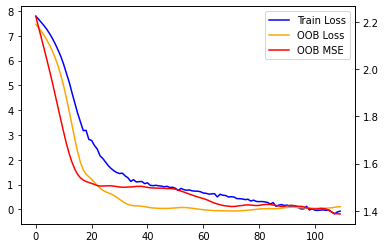

Bootstrap iteration 24 at time 2022-07-06 23:48:53.095787
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.822975158691406, MSE: 4.083001136779785
Epoch: 0, Loss: 6.539400100708008, OOB Loss: 6.529007911682129, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5007100105285645, MSE: 2.7252345085144043
Epoch: 40, Loss: 0.8509941101074219, OOB Loss: 3.3133177757263184, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8205063343048096, MSE: 2.6127147674560547
Epoch: 80, Loss: -0.14541387557983398, OOB Loss: 2.6245853900909424, LR: 0.00040823971994699836
Early stopped, best epoch: 68, train loss: 0.17858171463012695, best OOB loss: 2.2714922428131104, LR: 0.00037027000111201555


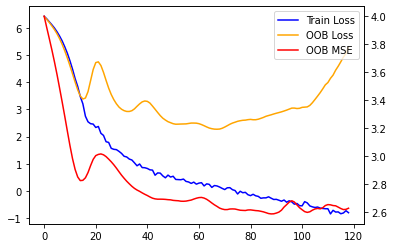

Bootstrap iteration 25 at time 2022-07-06 23:49:01.902307
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.250662326812744, MSE: 3.341301441192627
Epoch: 0, Loss: 6.83949089050293, OOB Loss: 6.701081275939941, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.675374448299408, MSE: 2.8443615436553955
Epoch: 40, Loss: 0.3986043930053711, OOB Loss: 2.571787118911743, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.026467204093933, MSE: 2.7110512256622314
Epoch: 80, Loss: -0.4303169250488281, OOB Loss: 2.6307015419006348, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 1.5779478549957275, MSE: 2.668962240219116
Epoch: 120, Loss: -1.1427419185638428, OOB Loss: 2.91113018989563, LR: 0.00036934432610923556
Early stopped, best epoch: 71, train loss: -0.3437235355377197, best OOB loss: 2.4903876781463623, LR: 0.0003674999128807276


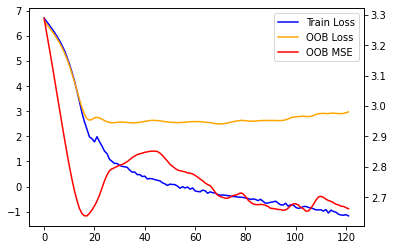

Bootstrap iteration 26 at time 2022-07-06 23:49:10.585438
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.140600681304932, MSE: 3.9018876552581787
Epoch: 0, Loss: 6.823835372924805, OOB Loss: 6.836082458496094, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.180637836456299, MSE: 2.556415557861328
Epoch: 40, Loss: 0.9358117580413818, OOB Loss: 1.2717339992523193, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8405513763427734, MSE: 2.6253769397735596
Epoch: 80, Loss: 0.20503735542297363, OOB Loss: 0.750962495803833, LR: 0.00040823971994699836
Early stopped, best epoch: 65, train loss: 0.3840789794921875, best OOB loss: 0.6806309223175049, LR: 0.00037306096931780195


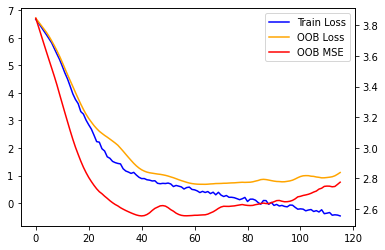

Bootstrap iteration 27 at time 2022-07-06 23:49:20.045617
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.789126873016357, MSE: 4.276645183563232
Epoch: 0, Loss: 6.520828723907471, OOB Loss: 6.5290303230285645, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2610924243927, MSE: 2.5954225063323975
Epoch: 40, Loss: 0.7256391048431396, OOB Loss: 1.385955810546875, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.4590444564819336, MSE: 2.47312068939209
Epoch: 80, Loss: -0.13810205459594727, OOB Loss: 1.2171671390533447, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.15747618675231934, best OOB loss: 1.1764533519744873, LR: 0.00037493329244695894


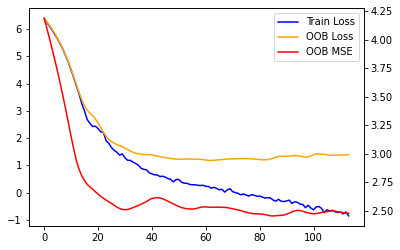

Bootstrap iteration 28 at time 2022-07-06 23:49:29.122537
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.075823783874512, MSE: 6.595787048339844
Epoch: 0, Loss: 6.594382286071777, OOB Loss: 7.461719036102295, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.1515004634857178, MSE: 4.713563919067383
Epoch: 40, Loss: 0.44638633728027344, OOB Loss: 5.641566276550293, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.1463154554367065, MSE: 4.3888373374938965
Epoch: 80, Loss: -0.35552263259887695, OOB Loss: 3.6418299674987793, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.0988574028015137, MSE: 4.604923725128174
Epoch: 120, Loss: -1.0654387474060059, OOB Loss: 5.002650260925293, LR: 0.00036934432610923556
Early stopped, best epoch: 69, train loss: -0.14237761497497559, best OOB loss: 3.5481626987457275, LR: 0.00036934432610923556


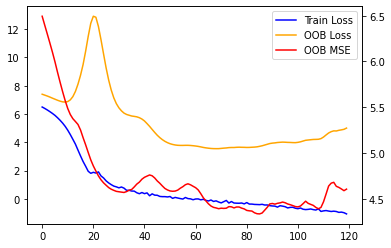

Bootstrap iteration 29 at time 2022-07-06 23:49:38.392327
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.066601753234863, MSE: 1.727235198020935
Epoch: 0, Loss: 6.776986122131348, OOB Loss: 6.289351940155029, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.9124345779418945, MSE: 1.215886116027832
Epoch: 40, Loss: 1.344249963760376, OOB Loss: -0.2252333164215088, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5897634029388428, MSE: 1.2230422496795654
Epoch: 80, Loss: 0.4025239944458008, OOB Loss: -0.4988365173339844, LR: 0.00040823971994699836
Early stopped, best epoch: 81, train loss: 0.4643821716308594, best OOB loss: -0.4995231628417969, LR: 0.000401148883612376


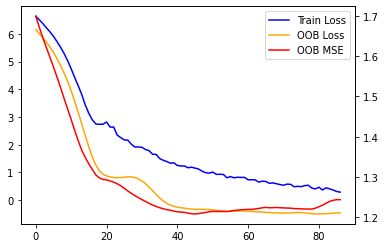

Bootstrap iteration 30 at time 2022-07-06 23:49:45.789380
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.542452335357666, MSE: 2.689702033996582
Epoch: 0, Loss: 7.159679412841797, OOB Loss: 6.8641767501831055, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8982644081115723, MSE: 1.7677379846572876
Epoch: 40, Loss: 0.8140182495117188, OOB Loss: 1.2812013626098633, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9308199882507324, MSE: 1.7006982564926147
Epoch: 80, Loss: -0.16871356964111328, OOB Loss: 1.45615816116333, LR: 0.00040823971994699836
Early stopped, best epoch: 32, train loss: 1.171040654182434, best OOB loss: 1.1235038042068481, LR: 0.00040518557016339937


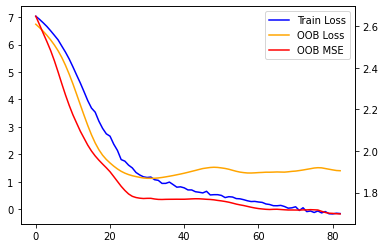

Bootstrap iteration 31 at time 2022-07-06 23:49:52.363318
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.3763604164123535, MSE: 4.630373477935791
Epoch: 0, Loss: 7.869948863983154, OOB Loss: 7.796533584594727, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2261860370635986, MSE: 2.8546366691589355
Epoch: 40, Loss: 0.7343940734863281, OOB Loss: 1.9722497463226318, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.7900562286376953, MSE: 2.6416256427764893
Epoch: 80, Loss: -0.0633857250213623, OOB Loss: 1.8859491348266602, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.5049967765808105, best OOB loss: 1.468371868133545, LR: 0.0003863662237861692


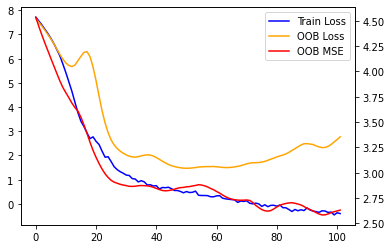

Bootstrap iteration 32 at time 2022-07-06 23:50:00.037379
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.761143684387207, MSE: 3.4938130378723145
Epoch: 0, Loss: 7.370759963989258, OOB Loss: 7.122443199157715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0649211406707764, MSE: 2.055419445037842
Epoch: 40, Loss: 1.024161696434021, OOB Loss: 1.338834524154663, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.334458589553833, MSE: 2.125990867614746
Epoch: 80, Loss: 0.14162755012512207, OOB Loss: 1.5201404094696045, LR: 0.00040823971994699836
Early stopped, best epoch: 42, train loss: 0.9795916080474854, best OOB loss: 1.31783127784729, LR: 0.00039516913294181626


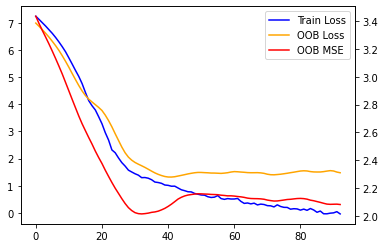

Bootstrap iteration 33 at time 2022-07-06 23:50:07.376764
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.09035062789917, MSE: 3.4071202278137207
Epoch: 0, Loss: 6.7834906578063965, OOB Loss: 6.598239898681641, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4707024097442627, MSE: 1.917061448097229
Epoch: 40, Loss: 0.8955988883972168, OOB Loss: 0.8330092430114746, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.791774272918701, MSE: 1.7961578369140625
Epoch: 80, Loss: 0.17500662803649902, OOB Loss: 0.5730884075164795, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.346052885055542, MSE: 1.7618157863616943
Epoch: 120, Loss: -0.6137568950653076, OOB Loss: 0.6588876247406006, LR: 0.00036934432610923556
Early stopped, best epoch: 81, train loss: 0.039129018783569336, best OOB loss: 0.5709097385406494, LR: 0.0003584150883524932


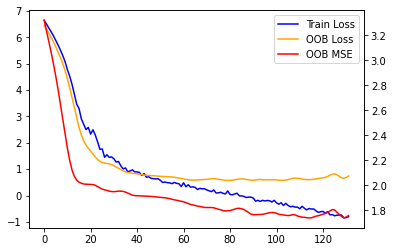

Bootstrap iteration 34 at time 2022-07-06 23:50:17.721549
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.606888771057129, MSE: 3.9574806690216064
Epoch: 0, Loss: 6.3875226974487305, OOB Loss: 6.618252277374268, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1982650756835938, MSE: 3.0833728313446045
Epoch: 40, Loss: 0.8832900524139404, OOB Loss: 2.060412883758545, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8371076583862305, MSE: 2.932539939880371
Epoch: 80, Loss: 0.12385320663452148, OOB Loss: 1.1017088890075684, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.3970205783843994, MSE: 2.8570291996002197
Epoch: 120, Loss: -0.5161864757537842, OOB Loss: 1.2827966213226318, LR: 0.00036934432610923556
Early stopped, best epoch: 85, train loss: 0.04830813407897949, best OOB loss: 1.0868730545043945, LR: 0.0003548443556478391


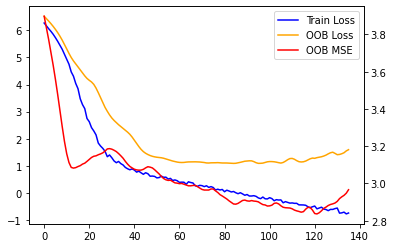

Bootstrap iteration 35 at time 2022-07-06 23:50:28.340152
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.457002639770508, MSE: 5.652498245239258
Epoch: 0, Loss: 6.2641215324401855, OOB Loss: 6.484832286834717, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.150099039077759, MSE: 3.514186143875122
Epoch: 40, Loss: 0.984666109085083, OOB Loss: 3.088488817214966, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3181889057159424, MSE: 3.1008665561676025
Epoch: 80, Loss: 0.16907739639282227, OOB Loss: 1.2615370750427246, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.154758930206299, MSE: 3.249695301055908
Epoch: 120, Loss: -0.6629641056060791, OOB Loss: 1.4965381622314453, LR: 0.00036934432610923556
Early stopped, best epoch: 83, train loss: -0.020209789276123047, best OOB loss: 1.2409093379974365, LR: 0.00035662525300503295


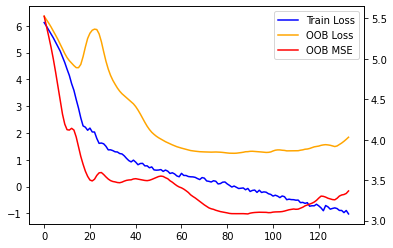

Bootstrap iteration 36 at time 2022-07-06 23:50:38.829090
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.535796642303467, MSE: 7.2864837646484375
Epoch: 0, Loss: 6.938662528991699, OOB Loss: 7.946747303009033, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.847117304801941, MSE: 4.137082099914551
Epoch: 40, Loss: 0.544806718826294, OOB Loss: 7.212919235229492, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.0717568397521973, MSE: 4.42227029800415
Epoch: 80, Loss: -0.3389596939086914, OOB Loss: 6.402839183807373, LR: 0.00040823971994699836
Early stopped, best epoch: 62, train loss: 0.06376433372497559, best OOB loss: 5.593837738037109, LR: 0.00037587297488416934


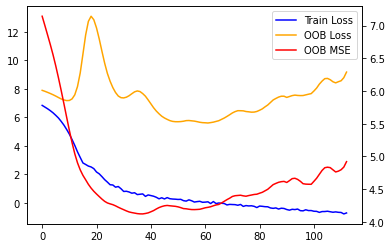

Bootstrap iteration 37 at time 2022-07-06 23:50:47.129008
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.971365928649902, MSE: 1.5683972835540771
Epoch: 0, Loss: 7.542153835296631, OOB Loss: 7.202754497528076, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9809480905532837, MSE: 1.1396801471710205
Epoch: 40, Loss: 1.2467747926712036, OOB Loss: 3.540515899658203e-05, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0832388401031494, MSE: 1.0781042575836182
Epoch: 80, Loss: 0.13700056076049805, OOB Loss: -0.15719056129455566, LR: 0.00040823971994699836
Early stopped, best epoch: 55, train loss: 0.6650233268737793, best OOB loss: -0.23012089729309082, LR: 0.0003971524128032524


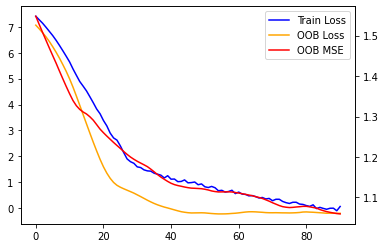

Bootstrap iteration 38 at time 2022-07-06 23:50:54.687567
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.979552745819092, MSE: 2.662191867828369
Epoch: 0, Loss: 6.275452613830566, OOB Loss: 5.623956203460693, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4668049812316895, MSE: 1.5602997541427612
Epoch: 40, Loss: 0.8705954551696777, OOB Loss: 0.7983176708221436, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.903695821762085, MSE: 1.512369155883789
Epoch: 80, Loss: 0.2001814842224121, OOB Loss: 0.5488197803497314, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.496885299682617, MSE: 1.4892234802246094
Epoch: 120, Loss: -0.39132022857666016, OOB Loss: 0.4886283874511719, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 4.2888031005859375, MSE: 1.453406810760498
Epoch: 160, Loss: -0.8717865943908691, OOB Loss: 0.6530890464782715, LR: 0.0003341547246965484
Early stopped, best epoch: 125, train loss: -0.42615723609924316, best OO

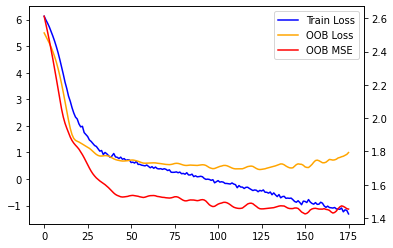

Bootstrap iteration 39 at time 2022-07-06 23:51:07.957192
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.595080375671387, MSE: 3.2178807258605957
Epoch: 0, Loss: 6.54965353012085, OOB Loss: 6.185369968414307, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.305208206176758, MSE: 1.817400574684143
Epoch: 40, Loss: 1.0219848155975342, OOB Loss: 1.243903398513794, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9861555099487305, MSE: 1.7447468042373657
Epoch: 80, Loss: 0.05565452575683594, OOB Loss: 0.801060676574707, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.5607376098632812, MSE: 1.575048565864563
Epoch: 120, Loss: -0.5874629020690918, OOB Loss: 0.7324008941650391, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 4.014726638793945, MSE: 1.585821270942688
Epoch: 160, Loss: -1.2332115173339844, OOB Loss: 0.7647848129272461, LR: 0.0003341547246965484
Early stopped, best epoch: 138, train loss: -0.8835935592651367, best OOB lo

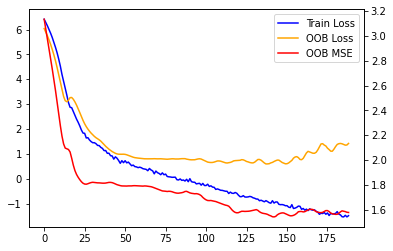

Bootstrap iteration 40 at time 2022-07-06 23:51:22.347601
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.084197998046875, MSE: 2.6462275981903076
Epoch: 0, Loss: 7.703060626983643, OOB Loss: 7.312423229217529, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.247422456741333, MSE: 1.6688836812973022
Epoch: 40, Loss: 1.2954490184783936, OOB Loss: 1.0965335369110107, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.220104694366455, MSE: 1.6207188367843628
Epoch: 80, Loss: 0.4076821804046631, OOB Loss: 0.25388336181640625, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: 0.5926988124847412, best OOB loss: 0.11517190933227539, LR: 0.00037119799610227123


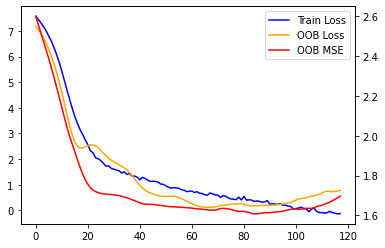

Bootstrap iteration 41 at time 2022-07-06 23:51:31.717294
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.685330390930176, MSE: 4.030511379241943
Epoch: 0, Loss: 7.220011234283447, OOB Loss: 7.192612648010254, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6557320356369019, MSE: 2.7557709217071533
Epoch: 40, Loss: 0.6926717758178711, OOB Loss: 2.4269375801086426, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.2179508209228516, MSE: 2.7473573684692383
Epoch: 80, Loss: -0.3715553283691406, OOB Loss: 2.565554618835449, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.4944620132446289, best OOB loss: 2.1466798782348633, LR: 0.00039025415518281834


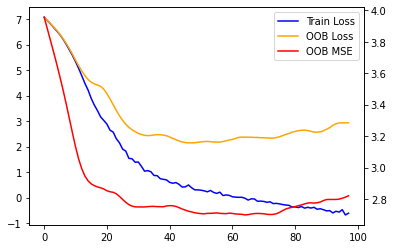

Bootstrap iteration 42 at time 2022-07-06 23:51:39.404525
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.329644680023193, MSE: 2.249607563018799
Epoch: 0, Loss: 7.127734184265137, OOB Loss: 6.6157965660095215, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.408644199371338, MSE: 1.4848846197128296
Epoch: 40, Loss: 1.062253475189209, OOB Loss: 0.542182207107544, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1615869998931885, MSE: 1.4462603330612183
Epoch: 80, Loss: 0.28000617027282715, OOB Loss: 0.33380675315856934, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.9740569591522217, MSE: 1.4272516965866089
Epoch: 120, Loss: -0.3590703010559082, OOB Loss: 0.44577574729919434, LR: 0.00036934432610923556
Early stopped, best epoch: 95, train loss: 0.007064104080200195, best OOB loss: 0.29801464080810547, LR: 0.0003460723843006206


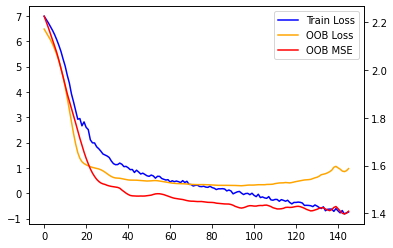

Bootstrap iteration 43 at time 2022-07-06 23:51:50.893703
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.15190315246582, MSE: 7.6936774253845215
Epoch: 0, Loss: 7.654188632965088, OOB Loss: 7.837419509887695, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.8172714710235596, MSE: 3.8850462436676025
Epoch: 40, Loss: 0.9400296211242676, OOB Loss: 2.1224496364593506, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.7416114807128906, MSE: 3.768545389175415
Epoch: 80, Loss: -0.07827377319335938, OOB Loss: 1.875075101852417, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.810256242752075, MSE: 3.6505043506622314
Epoch: 120, Loss: -0.7736976146697998, OOB Loss: 2.3668205738067627, LR: 0.00036934432610923556
Early stopped, best epoch: 89, train loss: -0.1735830307006836, best OOB loss: 1.7843568325042725, LR: 0.00035130919659078646


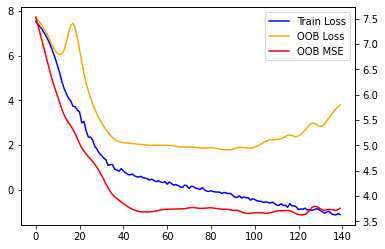

Bootstrap iteration 44 at time 2022-07-06 23:52:01.690494
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.546975135803223, MSE: 2.2613637447357178
Epoch: 0, Loss: 6.447815418243408, OOB Loss: 6.052534103393555, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3647682666778564, MSE: 1.5712960958480835
Epoch: 40, Loss: 1.013706922531128, OOB Loss: 0.20061755180358887, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.459824562072754, MSE: 1.6072235107421875
Epoch: 80, Loss: 0.04044532775878906, OOB Loss: -0.011051177978515625, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: 0.28141045570373535, best OOB loss: -0.11014652252197266, LR: 0.0003922127676914776


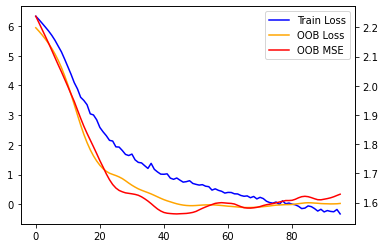

Bootstrap iteration 45 at time 2022-07-06 23:52:09.601450
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.8576459884643555, MSE: 2.5473225116729736
Epoch: 0, Loss: 7.520692825317383, OOB Loss: 7.175158977508545, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3194618225097656, MSE: 1.4133363962173462
Epoch: 40, Loss: 1.3130698204040527, OOB Loss: 0.13645195960998535, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.30358624458313, MSE: 1.3524993658065796
Epoch: 80, Loss: 0.22221684455871582, OOB Loss: -0.2019338607788086, LR: 0.00040823971994699836
Early stopped, best epoch: 105, train loss: -0.13264703750610352, best OOB loss: -0.24632930755615234, LR: 0.00037870617638352256


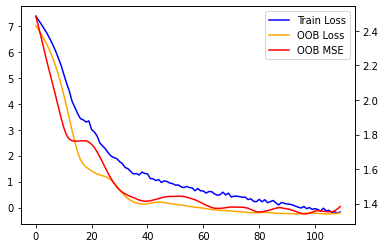

Bootstrap iteration 46 at time 2022-07-06 23:52:18.778297
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.558864593505859, MSE: 5.801271915435791
Epoch: 0, Loss: 7.068912029266357, OOB Loss: 7.282796382904053, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.00276780128479, MSE: 4.370047569274902
Epoch: 40, Loss: 0.6755597591400146, OOB Loss: 6.0745649337768555, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5327301025390625, MSE: 4.771512985229492
Epoch: 80, Loss: -0.018619060516357422, OOB Loss: 6.11662483215332, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.45522332191467285, best OOB loss: 4.147486686706543, LR: 0.0003863662237861692


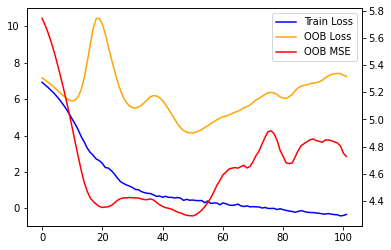

Bootstrap iteration 47 at time 2022-07-06 23:52:26.511065
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.458001136779785, MSE: 6.3138861656188965
Epoch: 0, Loss: 6.111291408538818, OOB Loss: 6.836261749267578, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.325371265411377, MSE: 3.5303165912628174
Epoch: 40, Loss: 0.6270551681518555, OOB Loss: 3.9866490364074707, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.877034902572632, MSE: 3.3190231323242188
Epoch: 80, Loss: -0.17258667945861816, OOB Loss: 2.1695830821990967, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.954319477081299, MSE: 3.35239577293396
Epoch: 120, Loss: -0.8902490139007568, OOB Loss: 2.372992515563965, LR: 0.00036934432610923556
Early stopped, best epoch: 87, train loss: -0.31754517555236816, best OOB loss: 1.8711154460906982, LR: 0.00035307235164682273


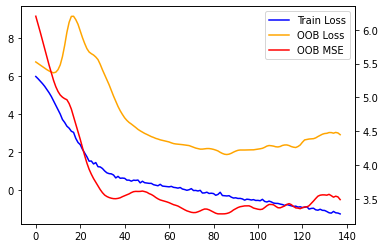

Bootstrap iteration 48 at time 2022-07-06 23:52:37.213557
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.7656426429748535, MSE: 1.9331475496292114
Epoch: 0, Loss: 7.417173862457275, OOB Loss: 6.962777614593506, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.806379795074463, MSE: 1.3846784830093384
Epoch: 40, Loss: 1.2541388273239136, OOB Loss: 0.3864631652832031, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.303363561630249, MSE: 1.3809140920639038
Epoch: 80, Loss: 0.23365235328674316, OOB Loss: 0.07589292526245117, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.0809550285339355, MSE: 1.5055553913116455
Epoch: 120, Loss: -0.33307671546936035, OOB Loss: 0.5041656494140625, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.32100772857666016, best OOB loss: 0.0612947940826416, LR: 0.00036475054841530254


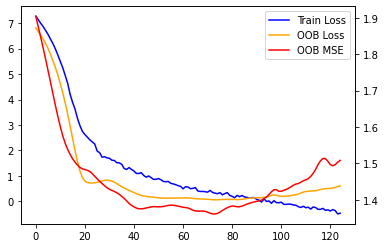

Bootstrap iteration 49 at time 2022-07-06 23:52:46.958887
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.604706764221191, MSE: 6.492353916168213
Epoch: 0, Loss: 6.3563618659973145, OOB Loss: 6.855987548828125, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.226060152053833, MSE: 3.213512420654297
Epoch: 40, Loss: 0.7291820049285889, OOB Loss: 1.750443696975708, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.2063510417938232, MSE: 3.425762414932251
Epoch: 80, Loss: -0.1282515525817871, OOB Loss: 2.105570077896118, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 0.3864109516143799, best OOB loss: 1.6791244745254517, LR: 0.0003863662237861692


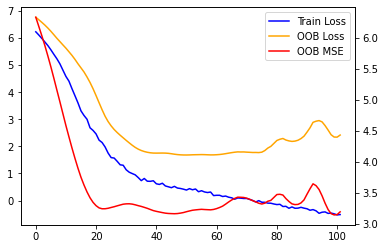

Time 0, 2022-07-06 23:52:55.222717
Time 5, 2022-07-07 00:09:43.819703
Time 10, 2022-07-07 00:26:43.394185
Time 15, 2022-07-07 00:43:31.430475
Time 20, 2022-07-07 01:00:14.060203
Time 25, 2022-07-07 01:16:24.869063
Time 30, 2022-07-07 01:32:24.680562
Time 35, 2022-07-07 01:48:28.935536
Time 40, 2022-07-07 02:04:30.932808
Time 45, 2022-07-07 02:20:29.744849
Time 50, 2022-07-07 02:36:40.081963
Time 55, 2022-07-07 02:52:24.392913
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: 1.7946010828018188, MSE: 1.424686074256897
Epoch: 40, Loss: 0.9311091899871826, OOB Loss: 0.41459953784942627, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1605045795440674, MSE: 1.39936101436615
Epoch: 80, Loss: 0.15571975708007812, OOB Loss: 0.25713467597961426, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.8909645080566406, MSE: 1.3965755701065063
Epoch: 120, Loss: -0.4705655574798584, OOB Loss: 0.14001941680908203, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.641191244125366, MSE: 1.4213556051254272
Epoch: 160, Loss: -1.0728583335876465, OOB Loss: 0.20392870903015137, LR: 0.0003341547246965484
Early stopped, best epoch: 141, train loss: -0.7847511768341064, best OOB loss: 0.06616759300231934, LR: 0.0003084327922610704


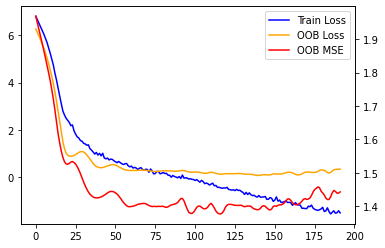

Bootstrap iteration 1 at time 2022-07-07 03:08:16.771630
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.963987827301025, MSE: 2.4751904010772705
Epoch: 0, Loss: 6.709867477416992, OOB Loss: 6.281861305236816, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.199625253677368, MSE: 1.9685238599777222
Epoch: 40, Loss: 0.9569685459136963, OOB Loss: 1.9352810382843018, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5624618530273438, MSE: 2.050510883331299
Epoch: 80, Loss: 0.15211796760559082, OOB Loss: 1.937973976135254, LR: 0.00040823971994699836
Early stopped, best epoch: 48, train loss: 0.7731521129608154, best OOB loss: 1.3859167098999023, LR: 0.0003892785197948613


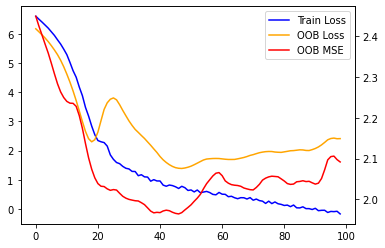

Bootstrap iteration 2 at time 2022-07-07 03:08:23.998423
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.230015277862549, MSE: 3.7576730251312256
Epoch: 0, Loss: 7.073307991027832, OOB Loss: 6.881135940551758, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.2630231380462646, MSE: 1.9879692792892456
Epoch: 40, Loss: 0.7470963001251221, OOB Loss: 2.7701656818389893, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.71560001373291, MSE: 1.8725666999816895
Epoch: 80, Loss: -0.015011072158813477, OOB Loss: 2.5978922843933105, LR: 0.00040823971994699836
Early stopped, best epoch: 58, train loss: 0.34507036209106445, best OOB loss: 2.058469772338867, LR: 0.00037965531467019806


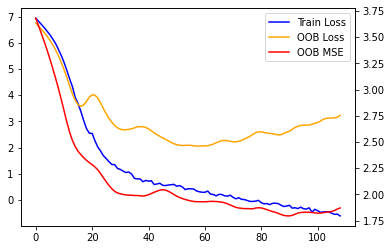

Bootstrap iteration 3 at time 2022-07-07 03:08:32.056323
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.086291790008545, MSE: 1.520135521888733
Epoch: 0, Loss: 6.985738754272461, OOB Loss: 6.395867347717285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.532972574234009, MSE: 1.1592093706130981
Epoch: 40, Loss: 0.9938464164733887, OOB Loss: -0.02435755729675293, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.38494610786438, MSE: 1.0988909006118774
Epoch: 80, Loss: 0.22902274131774902, OOB Loss: -0.19642972946166992, LR: 0.00040823971994699836
Early stopped, best epoch: 84, train loss: 0.05694246292114258, best OOB loss: -0.21496176719665527, LR: 0.00040316217472239593


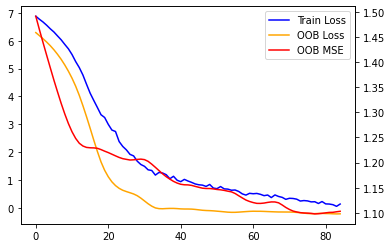

Bootstrap iteration 4 at time 2022-07-07 03:08:38.879369
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.336866855621338, MSE: 1.8820571899414062
Epoch: 0, Loss: 7.032872200012207, OOB Loss: 6.583864212036133, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.740586757659912, MSE: 1.3712822198867798
Epoch: 40, Loss: 1.1866106986999512, OOB Loss: 0.11067819595336914, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.2077829837799072, MSE: 1.349125862121582
Epoch: 80, Loss: 0.2757565975189209, OOB Loss: 0.08475518226623535, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.9837673902511597, best OOB loss: 0.03529238700866699, LR: 0.00039025415518281834


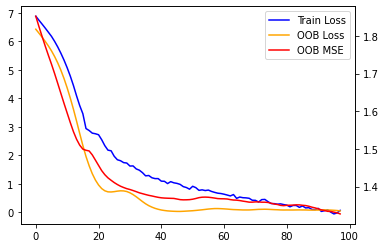

Bootstrap iteration 5 at time 2022-07-07 03:08:46.209053
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.9881157875061035, MSE: 3.800447702407837
Epoch: 0, Loss: 7.561924934387207, OOB Loss: 7.386354923248291, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.133143901824951, MSE: 2.2867603302001953
Epoch: 40, Loss: 0.8732705116271973, OOB Loss: 1.3034741878509521, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0049571990966797, MSE: 2.365164041519165
Epoch: 80, Loss: -0.08118152618408203, OOB Loss: 1.3367233276367188, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: 0.22081685066223145, best OOB loss: 1.2641081809997559, LR: 0.00037119799610227123


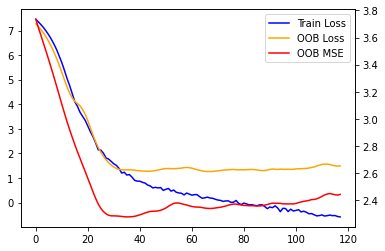

Bootstrap iteration 6 at time 2022-07-07 03:08:54.862927
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.94594669342041, MSE: 4.264175891876221
Epoch: 0, Loss: 6.610536098480225, OOB Loss: 6.550972938537598, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3592522144317627, MSE: 2.348905086517334
Epoch: 40, Loss: 0.8357570171356201, OOB Loss: 1.2649641036987305, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8196513652801514, MSE: 2.2573049068450928
Epoch: 80, Loss: -0.0579218864440918, OOB Loss: 1.1252634525299072, LR: 0.00040823971994699836
Early stopped, best epoch: 66, train loss: 0.11514091491699219, best OOB loss: 1.051206350326538, LR: 0.0003721283168945075


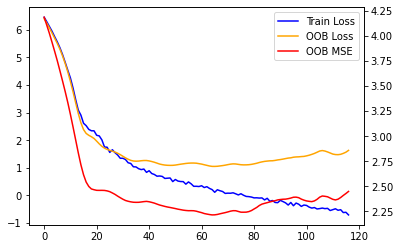

Bootstrap iteration 7 at time 2022-07-07 03:09:03.506573
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.230655193328857, MSE: 5.502180576324463
Epoch: 0, Loss: 7.644538402557373, OOB Loss: 7.814182281494141, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2584023475646973, MSE: 4.460866451263428
Epoch: 40, Loss: 0.6516852378845215, OOB Loss: 5.582341194152832, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.0507640838623047, MSE: 4.23374080657959
Epoch: 80, Loss: -0.030390262603759766, OOB Loss: 3.1429061889648438, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.6759438514709473, MSE: 4.3517069816589355
Epoch: 120, Loss: -0.7104480266571045, OOB Loss: 3.7507200241088867, LR: 0.00036934432610923556
Early stopped, best epoch: 92, train loss: -0.20774102210998535, best OOB loss: 3.0649514198303223, LR: 0.0003486809591745855


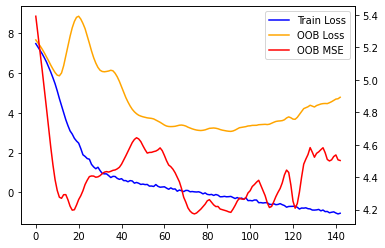

Bootstrap iteration 8 at time 2022-07-07 03:09:13.789693
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.3852362632751465, MSE: 3.890289783477783
Epoch: 0, Loss: 6.159763813018799, OOB Loss: 5.919137001037598, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.469258189201355, MSE: 2.222256660461426
Epoch: 40, Loss: 0.7545778751373291, OOB Loss: 1.1439663171768188, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.276048183441162, MSE: 2.1046142578125
Epoch: 80, Loss: -0.22911477088928223, OOB Loss: 1.1044836044311523, LR: 0.00040823971994699836
Early stopped, best epoch: 48, train loss: 0.5372719764709473, best OOB loss: 1.07773756980896, LR: 0.0003892785197948613


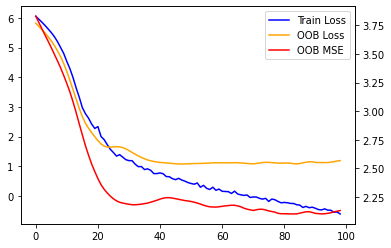

Bootstrap iteration 9 at time 2022-07-07 03:09:21.277796
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.2404913902282715, MSE: 3.2517004013061523
Epoch: 0, Loss: 7.695309638977051, OOB Loss: 7.510873794555664, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.3369415998458862, MSE: 1.840788722038269
Epoch: 40, Loss: 0.7614743709564209, OOB Loss: 1.3196359872817993, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.7840919494628906, MSE: 1.6997660398483276
Epoch: 80, Loss: -0.05147910118103027, OOB Loss: 1.1133325099945068, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.4297845363616943, MSE: 1.7169290781021118
Epoch: 120, Loss: -0.7134077548980713, OOB Loss: 1.1007499694824219, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.1419975757598877, MSE: 1.724984884262085
Epoch: 160, Loss: -1.3801774978637695, OOB Loss: 1.5181620121002197, LR: 0.0003341547246965484
Early stopped, best epoch: 117, train loss: -0.636563777923584, best 

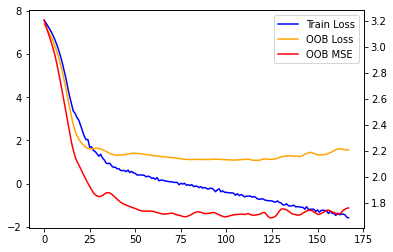

Bootstrap iteration 10 at time 2022-07-07 03:09:33.615020
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.858821392059326, MSE: 2.3425488471984863
Epoch: 0, Loss: 7.498214244842529, OOB Loss: 7.08229923248291, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.414545774459839, MSE: 1.4516613483428955
Epoch: 40, Loss: 1.0611371994018555, OOB Loss: 0.2144792079925537, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1705963611602783, MSE: 1.3801523447036743
Epoch: 80, Loss: 0.2032785415649414, OOB Loss: -0.01351308822631836, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.603543519973755, MSE: 1.3624147176742554
Epoch: 120, Loss: -0.5457370281219482, OOB Loss: -0.014079093933105469, LR: 0.00036934432610923556
Early stopped, best epoch: 112, train loss: -0.3373560905456543, best OOB loss: -0.06016850471496582, LR: 0.0003629290753641537


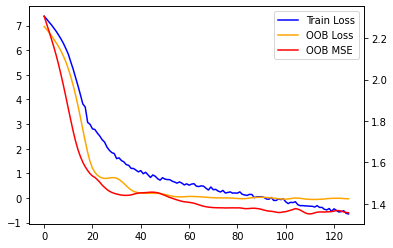

Bootstrap iteration 11 at time 2022-07-07 03:09:43.238904
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.465674877166748, MSE: 2.723572254180908
Epoch: 0, Loss: 6.192855358123779, OOB Loss: 5.8748602867126465, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.758662223815918, MSE: 1.7997989654541016
Epoch: 40, Loss: 0.9415867328643799, OOB Loss: 1.2612428665161133, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.273531198501587, MSE: 1.8657093048095703
Epoch: 80, Loss: 0.09325313568115234, OOB Loss: 0.9906361103057861, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.6734471321105957, MSE: 1.7811635732650757
Epoch: 120, Loss: -0.6780805587768555, OOB Loss: 0.9538788795471191, LR: 0.00036934432610923556
Early stopped, best epoch: 93, train loss: -0.1135566234588623, best OOB loss: 0.863168478012085, LR: 0.000347809256776649


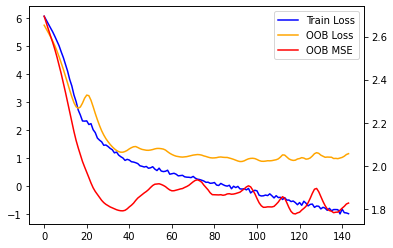

Bootstrap iteration 12 at time 2022-07-07 03:09:53.686895
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.37899112701416, MSE: 2.0300450325012207
Epoch: 0, Loss: 6.659111022949219, OOB Loss: 5.876829624176025, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.256633996963501, MSE: 1.5380182266235352
Epoch: 40, Loss: 0.9757648706436157, OOB Loss: 0.7291467189788818, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0136609077453613, MSE: 1.4199227094650269
Epoch: 80, Loss: -0.003431558609008789, OOB Loss: 0.3374149799346924, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.8329086303710938, MSE: 1.4107674360275269
Epoch: 120, Loss: -0.5877835750579834, OOB Loss: 0.4946918487548828, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: -0.12532496452331543, best OOB loss: 0.33356690406799316, LR: 0.0003504309235993095


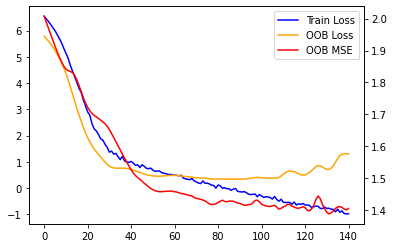

Bootstrap iteration 13 at time 2022-07-07 03:10:04.555245
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.655457019805908, MSE: 1.5937668085098267
Epoch: 0, Loss: 7.260761737823486, OOB Loss: 6.874152183532715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.0572826862335205, MSE: 1.424980640411377
Epoch: 40, Loss: 1.1575212478637695, OOB Loss: 0.5025627613067627, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.856724262237549, MSE: 1.3374055624008179
Epoch: 80, Loss: 0.2310619354248047, OOB Loss: 0.2675051689147949, LR: 0.00040823971994699836
Early stopped, best epoch: 66, train loss: 0.40146565437316895, best OOB loss: 0.20324349403381348, LR: 0.0003721283168945075


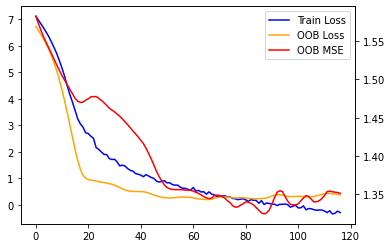

Bootstrap iteration 14 at time 2022-07-07 03:10:13.573445
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.31259298324585, MSE: 3.596585512161255
Epoch: 0, Loss: 7.0722270011901855, OOB Loss: 6.823448181152344, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5515408515930176, MSE: 2.5558767318725586
Epoch: 40, Loss: 0.9160909652709961, OOB Loss: 2.460566520690918, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.150101900100708, MSE: 2.374175786972046
Epoch: 80, Loss: 0.02399730682373047, OOB Loss: 1.7161729335784912, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.112204551696777, MSE: 2.3183865547180176
Epoch: 120, Loss: -0.6348445415496826, OOB Loss: 2.10552978515625, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: -0.08607840538024902, best OOB loss: 1.5041873455047607, LR: 0.0003504309235993095


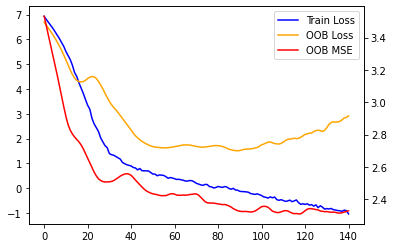

Bootstrap iteration 15 at time 2022-07-07 03:10:24.212080
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.601369857788086, MSE: 2.210827350616455
Epoch: 0, Loss: 6.604509353637695, OOB Loss: 6.011847496032715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.9975428581237793, MSE: 1.574400782585144
Epoch: 40, Loss: 0.9163205623626709, OOB Loss: 0.44568371772766113, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.6206507682800293, MSE: 1.5187779664993286
Epoch: 80, Loss: 0.08917045593261719, OOB Loss: 0.5556440353393555, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 0.6598572731018066, best OOB loss: 0.39720964431762695, LR: 0.00039025415518281834


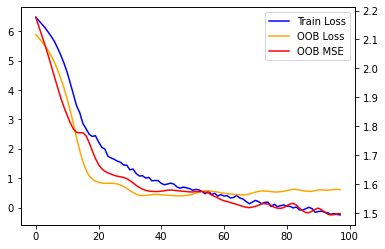

Bootstrap iteration 16 at time 2022-07-07 03:10:31.806918
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.768444061279297, MSE: 4.591643333435059
Epoch: 0, Loss: 6.433079242706299, OOB Loss: 6.600803375244141, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.034698486328125, MSE: 2.940068483352661
Epoch: 40, Loss: 0.8281741142272949, OOB Loss: 2.3629417419433594, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.6835739612579346, MSE: 3.0685713291168213
Epoch: 80, Loss: 0.040313720703125, OOB Loss: 1.4676048755645752, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.59045672416687, MSE: 3.474318742752075
Epoch: 120, Loss: -0.7129600048065186, OOB Loss: 2.7878215312957764, LR: 0.00036934432610923556
Early stopped, best epoch: 77, train loss: 0.08287525177001953, best OOB loss: 1.442425012588501, LR: 0.0003629290753641537


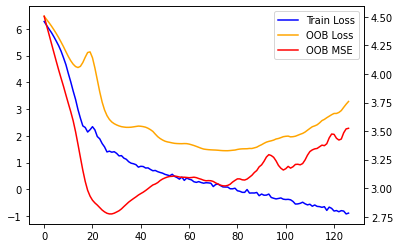

Bootstrap iteration 17 at time 2022-07-07 03:10:41.397804
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -4.423627853393555, MSE: 6.613300323486328
Epoch: 0, Loss: 5.226964950561523, OOB Loss: 6.114709854125977, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.401355504989624, MSE: 4.295307636260986
Epoch: 40, Loss: 0.41675329208374023, OOB Loss: 4.874464988708496, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.578683853149414, MSE: 5.030035495758057
Epoch: 80, Loss: -0.33698368072509766, OOB Loss: 4.801412582397461, LR: 0.00040823971994699836
Early stopped, best epoch: 64, train loss: -0.04041576385498047, best OOB loss: 3.644416570663452, LR: 0.00037399595921584153


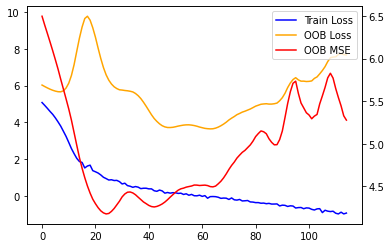

Bootstrap iteration 18 at time 2022-07-07 03:10:49.450538
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.3167290687561035, MSE: 3.5151312351226807
Epoch: 0, Loss: 6.924638748168945, OOB Loss: 6.7280592918396, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6206891536712646, MSE: 2.0382537841796875
Epoch: 40, Loss: 0.9362874031066895, OOB Loss: 0.9848737716674805, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.792534351348877, MSE: 2.13855242729187
Epoch: 80, Loss: -0.11957931518554688, OOB Loss: 1.2551345825195312, LR: 0.00040823971994699836
Early stopped, best epoch: 39, train loss: 0.8924190998077393, best OOB loss: 0.9783779382705688, LR: 0.00039814778225889965


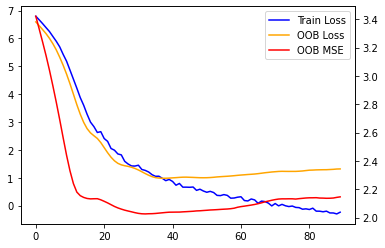

Bootstrap iteration 19 at time 2022-07-07 03:10:56.226668
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.015398979187012, MSE: 2.5952377319335938
Epoch: 0, Loss: 5.788369178771973, OOB Loss: 5.547665119171143, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1037261486053467, MSE: 1.6486279964447021
Epoch: 40, Loss: 0.959519624710083, OOB Loss: 0.7358789443969727, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.585254192352295, MSE: 1.6338462829589844
Epoch: 80, Loss: 0.13526177406311035, OOB Loss: 0.49248409271240234, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.3803765773773193, MSE: 1.692513108253479
Epoch: 120, Loss: -0.6106138229370117, OOB Loss: 0.7047207355499268, LR: 0.00036934432610923556
Early stopped, best epoch: 84, train loss: -0.016663551330566406, best OOB loss: 0.45717716217041016, LR: 0.0003557336898725204


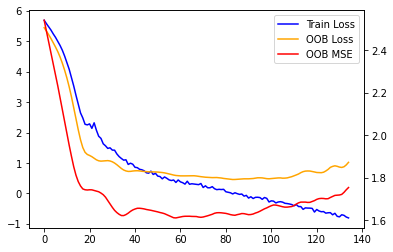

Bootstrap iteration 20 at time 2022-07-07 03:11:06.307768
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.413515567779541, MSE: 7.556814670562744
Epoch: 0, Loss: 7.868938446044922, OOB Loss: 8.047548294067383, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.148526668548584, MSE: 5.365145206451416
Epoch: 40, Loss: 0.31000614166259766, OOB Loss: 8.489877700805664, LR: 0.00045123116063007594
Early stopped, best epoch: 12, train loss: 4.250586986541748, best OOB loss: 5.343967914581299, LR: 0.0004259865463627658


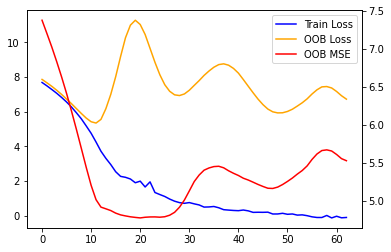

Bootstrap iteration 21 at time 2022-07-07 03:11:10.819721
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.074403762817383, MSE: 2.9680511951446533
Epoch: 0, Loss: 6.91126012802124, OOB Loss: 6.481734752655029, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6133772134780884, MSE: 1.7788777351379395
Epoch: 40, Loss: 0.9814350605010986, OOB Loss: 0.7199186086654663, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1434032917022705, MSE: 1.869409203529358
Epoch: 80, Loss: 0.14777445793151855, OOB Loss: 0.9663403034210205, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 0.5060200691223145, best OOB loss: 0.5914976596832275, LR: 0.0003834757154374967


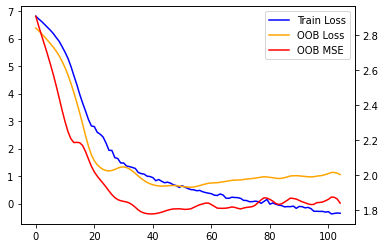

Bootstrap iteration 22 at time 2022-07-07 03:11:18.586413
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.686981201171875, MSE: 3.9607391357421875
Epoch: 0, Loss: 6.861220359802246, OOB Loss: 6.478116035461426, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.7071890830993652, MSE: 2.3235511779785156
Epoch: 40, Loss: 0.7576634883880615, OOB Loss: 2.278477668762207, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3022165298461914, MSE: 2.314727783203125
Epoch: 80, Loss: -0.23226594924926758, OOB Loss: 2.127958297729492, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.4029090404510498, best OOB loss: 1.946162223815918, LR: 0.00038733456018663577


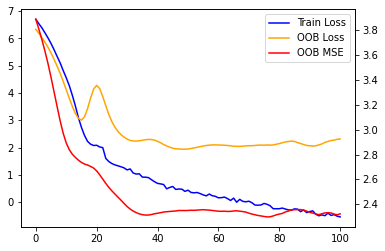

Bootstrap iteration 23 at time 2022-07-07 03:11:26.151184
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.625304222106934, MSE: 2.516634702682495
Epoch: 0, Loss: 6.487334251403809, OOB Loss: 6.137598514556885, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.8132576942443848, MSE: 1.85365891456604
Epoch: 40, Loss: 0.9602129459381104, OOB Loss: 0.8790853023529053, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.449408769607544, MSE: 1.86673104763031
Epoch: 80, Loss: 0.012999296188354492, OOB Loss: 0.8976213932037354, LR: 0.00040823971994699836
Early stopped, best epoch: 58, train loss: 0.5366685390472412, best OOB loss: 0.6730484962463379, LR: 0.00037965531467019806


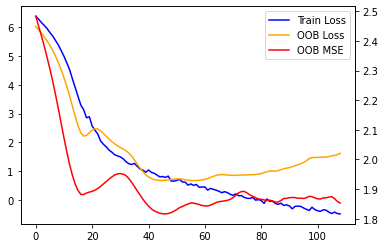

Bootstrap iteration 24 at time 2022-07-07 03:11:34.259562
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.1807861328125, MSE: 6.439287185668945
Epoch: 0, Loss: 6.724319934844971, OOB Loss: 7.368981838226318, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.1272430419921875, MSE: 3.883219003677368
Epoch: 40, Loss: 0.6484990119934082, OOB Loss: 3.826901435852051, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.8139735460281372, MSE: 3.6971185207366943
Epoch: 80, Loss: -0.18497943878173828, OOB Loss: 2.534555435180664, LR: 0.00040823971994699836
Early stopped, best epoch: 66, train loss: 0.08737874031066895, best OOB loss: 2.342338800430298, LR: 0.0003721283168945075


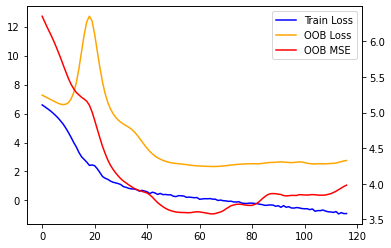

Bootstrap iteration 25 at time 2022-07-07 03:11:42.718246
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.439448356628418, MSE: 2.5450689792633057
Epoch: 0, Loss: 7.07142972946167, OOB Loss: 6.754490852355957, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.906998872756958, MSE: 1.8919614553451538
Epoch: 40, Loss: 1.1692144870758057, OOB Loss: 0.9392476081848145, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.381995439529419, MSE: 1.9115968942642212
Epoch: 80, Loss: 0.16521835327148438, OOB Loss: 0.7230207920074463, LR: 0.00040823971994699836
Early stopped, best epoch: 65, train loss: 0.43820667266845703, best OOB loss: 0.45174431800842285, LR: 0.00037306096931780195


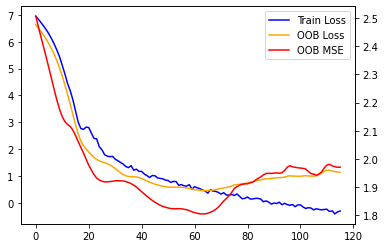

Bootstrap iteration 26 at time 2022-07-07 03:11:51.574163
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.728476047515869, MSE: 3.129072427749634
Epoch: 0, Loss: 7.311216354370117, OOB Loss: 7.086842060089111, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.310235023498535, MSE: 1.8193817138671875
Epoch: 40, Loss: 1.0572781562805176, OOB Loss: 1.6095056533813477, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 4.0652360916137695, MSE: 2.055164098739624
Epoch: 80, Loss: 0.16136932373046875, OOB Loss: 1.940598487854004, LR: 0.00040823971994699836
Early stopped, best epoch: 42, train loss: 0.9676275253295898, best OOB loss: 1.5767788887023926, LR: 0.00039516913294181626


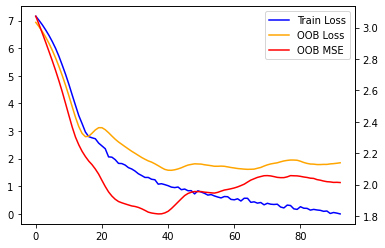

Bootstrap iteration 27 at time 2022-07-07 03:11:58.550881
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.824359893798828, MSE: 2.288548469543457
Epoch: 0, Loss: 6.58069372177124, OOB Loss: 6.193981647491455, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.5668898820877075, MSE: 1.7222661972045898
Epoch: 40, Loss: 0.9126532077789307, OOB Loss: 1.0251084566116333, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3438243865966797, MSE: 1.5913869142532349
Epoch: 80, Loss: 0.09311127662658691, OOB Loss: 0.7855165004730225, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.656233072280884, MSE: 1.5410736799240112
Epoch: 120, Loss: -0.556161642074585, OOB Loss: 0.7010805606842041, LR: 0.00036934432610923556
OOB Mean Log Det Precision: 3.423767328262329, MSE: 1.5477967262268066
Epoch: 160, Loss: -1.2321856021881104, OOB Loss: 0.8906495571136475, LR: 0.0003341547246965484
Early stopped, best epoch: 115, train loss: -0.5577881336212158, best OOB

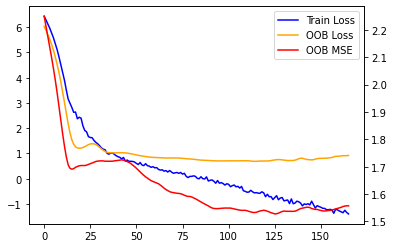

Bootstrap iteration 28 at time 2022-07-07 03:12:10.588212
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.4583916664123535, MSE: 2.8477325439453125
Epoch: 0, Loss: 6.23420524597168, OOB Loss: 5.935131072998047, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.97416353225708, MSE: 2.0495245456695557
Epoch: 40, Loss: 0.7732810974121094, OOB Loss: 1.2484021186828613, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0754520893096924, MSE: 2.0236752033233643
Epoch: 80, Loss: -0.10103321075439453, OOB Loss: 1.0851271152496338, LR: 0.00040823971994699836
Early stopped, best epoch: 65, train loss: 0.15194201469421387, best OOB loss: 1.0074033737182617, LR: 0.00037306096931780195


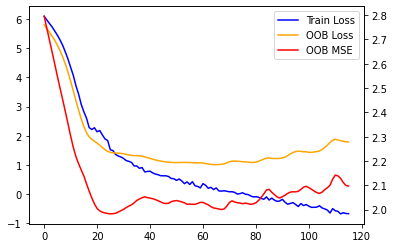

Bootstrap iteration 29 at time 2022-07-07 03:12:19.328463
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.11843729019165, MSE: 1.408066987991333
Epoch: 0, Loss: 6.870022296905518, OOB Loss: 6.36738920211792, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7208023071289062, MSE: 1.0360828638076782
Epoch: 40, Loss: 1.2800869941711426, OOB Loss: -0.13397347927093506, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.716764211654663, MSE: 1.0120303630828857
Epoch: 80, Loss: 0.3100419044494629, OOB Loss: -0.4450368881225586, LR: 0.00040823971994699836
Early stopped, best epoch: 72, train loss: 0.4208812713623047, best OOB loss: -0.4870293140411377, LR: 0.00040215426928559


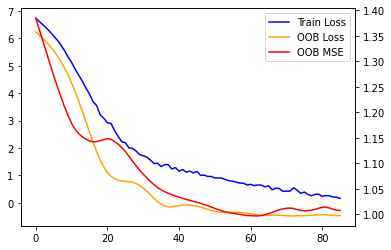

Bootstrap iteration 30 at time 2022-07-07 03:12:26.406892
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.648792266845703, MSE: 4.673278331756592
Epoch: 0, Loss: 6.447926044464111, OOB Loss: 6.389705657958984, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1082794666290283, MSE: 2.6907613277435303
Epoch: 40, Loss: 0.6658952236175537, OOB Loss: 1.770258903503418, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.190584659576416, MSE: 2.781224489212036
Epoch: 80, Loss: -0.24540996551513672, OOB Loss: 1.9383864402770996, LR: 0.00040823971994699836
Early stopped, best epoch: 44, train loss: 0.4964776039123535, best OOB loss: 1.65355384349823, LR: 0.0003931957570841881


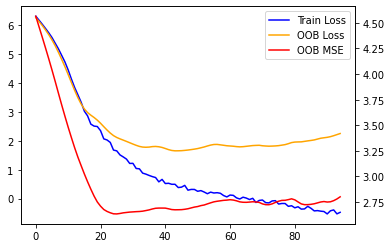

Bootstrap iteration 31 at time 2022-07-07 03:12:33.529560
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.317912578582764, MSE: 6.375123500823975
Epoch: 0, Loss: 6.978598117828369, OOB Loss: 7.426815986633301, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8349567651748657, MSE: 3.780980110168457
Epoch: 40, Loss: 0.5017006397247314, OOB Loss: 3.917832374572754, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1206395626068115, MSE: 3.9199748039245605
Epoch: 80, Loss: -0.3278939723968506, OOB Loss: 3.5740091800689697, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.23721075057983398, best OOB loss: 3.1581592559814453, LR: 0.0003883053234953742


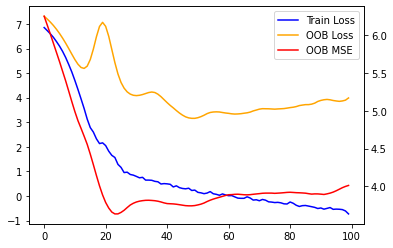

Bootstrap iteration 32 at time 2022-07-07 03:12:40.614162
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.17241096496582, MSE: 1.7755836248397827
Epoch: 0, Loss: 7.742157459259033, OOB Loss: 7.353143692016602, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0250489711761475, MSE: 1.225516438484192
Epoch: 40, Loss: 1.214131474494934, OOB Loss: 0.3909280300140381, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.174649238586426, MSE: 1.2134785652160645
Epoch: 80, Loss: 0.06212949752807617, OOB Loss: 0.41936731338500977, LR: 0.00040823971994699836
Early stopped, best epoch: 46, train loss: 0.9018311500549316, best OOB loss: 0.19048500061035156, LR: 0.00039123223577224893


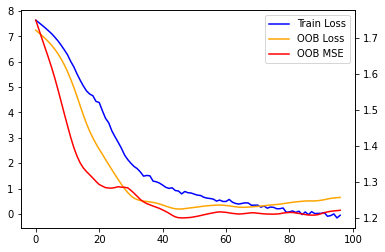

Bootstrap iteration 33 at time 2022-07-07 03:12:47.942699
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.249430179595947, MSE: 7.342954158782959
Epoch: 0, Loss: 7.653117656707764, OOB Loss: 7.910343170166016, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.8383721709251404, MSE: 5.288625240325928
Epoch: 40, Loss: 0.24516654014587402, OOB Loss: 6.250741481781006, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.0097614526748657, MSE: 5.896963596343994
Epoch: 80, Loss: -0.45157337188720703, OOB Loss: 4.941098690032959, LR: 0.00040823971994699836
Early stopped, best epoch: 56, train loss: -0.03505825996398926, best OOB loss: 4.319873809814453, LR: 0.00038156073358353075


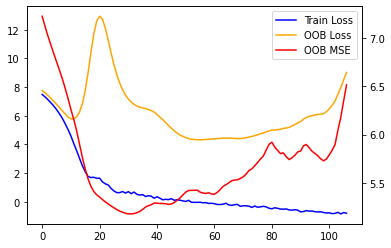

Bootstrap iteration 34 at time 2022-07-07 03:12:55.524547
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.345536231994629, MSE: 5.688971519470215
Epoch: 0, Loss: 6.955959320068359, OOB Loss: 7.013802528381348, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.553772449493408, MSE: 2.8768982887268066
Epoch: 40, Loss: 0.8328499794006348, OOB Loss: 2.977391242980957, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.904812812805176, MSE: 3.026881217956543
Epoch: 80, Loss: -0.0006394386291503906, OOB Loss: 2.3793578147888184, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.28029513359069824, best OOB loss: 2.187575101852417, LR: 0.00037493329244695894


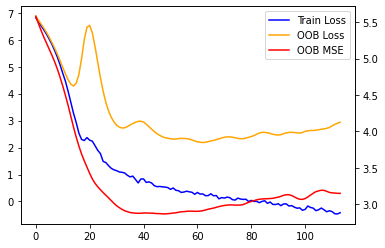

Bootstrap iteration 35 at time 2022-07-07 03:13:03.723792
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.793359279632568, MSE: 1.6741129159927368
Epoch: 0, Loss: 7.59039306640625, OOB Loss: 7.0441694259643555, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.247459888458252, MSE: 1.2522666454315186
Epoch: 40, Loss: 1.1324471235275269, OOB Loss: 0.1295459270477295, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0531489849090576, MSE: 1.1881699562072754
Epoch: 80, Loss: 0.3173081874847412, OOB Loss: 0.00900578498840332, LR: 0.00040823971994699836
Early stopped, best epoch: 66, train loss: 0.5607852935791016, best OOB loss: -0.04426431655883789, LR: 0.00038060683174957196


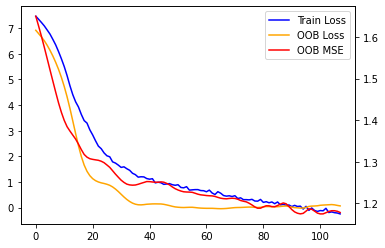

Bootstrap iteration 36 at time 2022-07-07 03:13:11.986017
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.257033348083496, MSE: 5.076650619506836
Epoch: 0, Loss: 6.8687262535095215, OOB Loss: 6.963902473449707, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1811606884002686, MSE: 4.123359680175781
Epoch: 40, Loss: 0.6686067581176758, OOB Loss: 3.999253988265991, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.101867198944092, MSE: 3.73773193359375
Epoch: 80, Loss: 0.03186345100402832, OOB Loss: 2.1790642738342285, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.2981119155883789, best OOB loss: 2.078951597213745, LR: 0.00037493329244695894


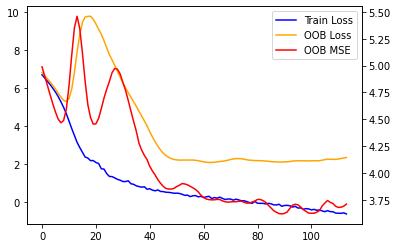

Bootstrap iteration 37 at time 2022-07-07 03:13:20.177180
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.366162300109863, MSE: 3.322524070739746
Epoch: 0, Loss: 6.33013391494751, OOB Loss: 5.988640785217285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9735145568847656, MSE: 1.8137683868408203
Epoch: 40, Loss: 1.1418297290802002, OOB Loss: 0.1310138702392578, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.890657663345337, MSE: 1.6849373579025269
Epoch: 80, Loss: 0.37625837326049805, OOB Loss: 0.1320188045501709, LR: 0.00040823971994699836
Early stopped, best epoch: 49, train loss: 0.8353843688964844, best OOB loss: 0.0052034854888916016, LR: 0.0003883053234953742


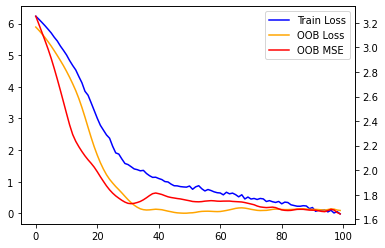

Bootstrap iteration 38 at time 2022-07-07 03:13:27.750973
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.025183200836182, MSE: 2.768092632293701
Epoch: 0, Loss: 6.854236602783203, OOB Loss: 6.445395469665527, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.2219337224960327, MSE: 1.6252437829971313
Epoch: 40, Loss: 0.8861672878265381, OOB Loss: 0.8523358106613159, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3844738006591797, MSE: 1.5534130334854126
Epoch: 80, Loss: 0.07160615921020508, OOB Loss: 0.5830509662628174, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.2857184410095215, MSE: 1.5515532493591309
Epoch: 120, Loss: -0.7111160755157471, OOB Loss: 0.8313961029052734, LR: 0.00036934432610923556
Early stopped, best epoch: 95, train loss: -0.2626960277557373, best OOB loss: 0.5635008811950684, LR: 0.0003460723843006206


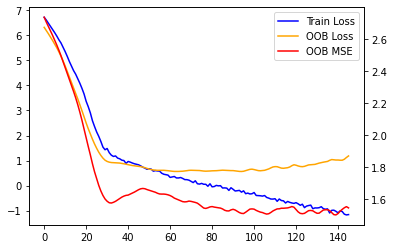

Bootstrap iteration 39 at time 2022-07-07 03:13:38.414188
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.760840892791748, MSE: 1.9970662593841553
Epoch: 0, Loss: 7.306321144104004, OOB Loss: 7.003130912780762, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4195029735565186, MSE: 1.5524711608886719
Epoch: 40, Loss: 1.222107172012329, OOB Loss: 0.7138457298278809, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4290783405303955, MSE: 1.5104323625564575
Epoch: 80, Loss: 0.1672532558441162, OOB Loss: 0.43012237548828125, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.106851100921631, MSE: 1.5881420373916626
Epoch: 120, Loss: -0.4440460205078125, OOB Loss: 0.870415210723877, LR: 0.00036934432610923556
Early stopped, best epoch: 79, train loss: 0.2062373161315918, best OOB loss: 0.4157533645629883, LR: 0.00036021390654831885


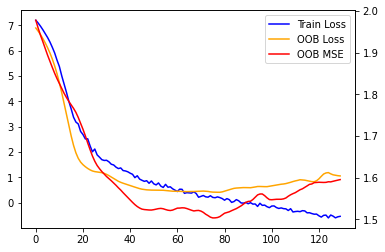

Bootstrap iteration 40 at time 2022-07-07 03:13:48.151948
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.867190837860107, MSE: 6.2668681144714355
Epoch: 0, Loss: 6.539832592010498, OOB Loss: 7.0044097900390625, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.863881826400757, MSE: 4.380670547485352
Epoch: 40, Loss: 0.5605676174163818, OOB Loss: 5.402379989624023, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.4151737689971924, MSE: 3.959972381591797
Epoch: 80, Loss: -0.1579725742340088, OOB Loss: 4.635042190551758, LR: 0.00040823971994699836
Early stopped, best epoch: 60, train loss: 0.15860700607299805, best OOB loss: 3.990739345550537, LR: 0.00037775941094256375


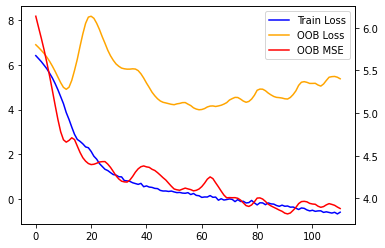

Bootstrap iteration 41 at time 2022-07-07 03:13:55.770846
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.517539978027344, MSE: 2.701404571533203
Epoch: 0, Loss: 7.190036296844482, OOB Loss: 6.886281490325928, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5111515522003174, MSE: 1.8479132652282715
Epoch: 40, Loss: 1.150700330734253, OOB Loss: 0.6827166080474854, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.78928804397583, MSE: 1.798516035079956
Epoch: 80, Loss: 0.13017845153808594, OOB Loss: 0.6395473480224609, LR: 0.00040823971994699836
Early stopped, best epoch: 50, train loss: 0.7234058380126953, best OOB loss: 0.4286019802093506, LR: 0.00038733456018663577


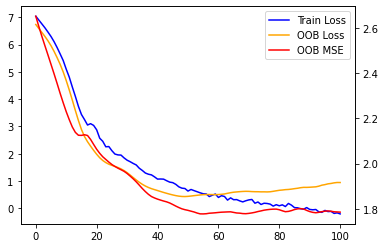

Bootstrap iteration 42 at time 2022-07-07 03:14:03.553108
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -5.282267093658447, MSE: 6.15918493270874
Epoch: 0, Loss: 5.834598541259766, OOB Loss: 6.3291096687316895, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.1185147762298584, MSE: 4.567909240722656
Epoch: 40, Loss: 0.5554261207580566, OOB Loss: 7.405096054077148, LR: 0.00045123116063007594
Early stopped, best epoch: 13, train loss: 3.226341485977173, best OOB loss: 4.536918640136719, LR: 0.0004249215799968589


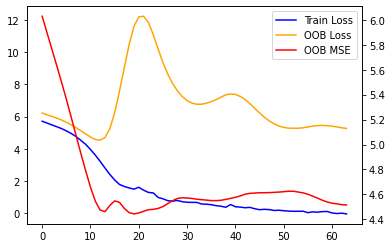

Bootstrap iteration 43 at time 2022-07-07 03:14:08.328247
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.722868919372559, MSE: 4.860921382904053
Epoch: 0, Loss: 7.316375732421875, OOB Loss: 7.220573425292969, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 0.8803051710128784, MSE: 2.5869295597076416
Epoch: 40, Loss: 1.4835450649261475, OOB Loss: 2.0434908866882324, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9468528032302856, MSE: 2.225393295288086
Epoch: 80, Loss: -0.024785757064819336, OOB Loss: 1.6999045610427856, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.5528738498687744, MSE: 2.239020824432373
Epoch: 120, Loss: -0.5960509777069092, OOB Loss: 2.0996034145355225, LR: 0.00036934432610923556
Early stopped, best epoch: 75, train loss: 0.07188129425048828, best OOB loss: 1.6271320581436157, LR: 0.0003638386720442643


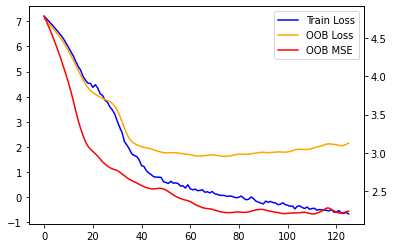

Bootstrap iteration 44 at time 2022-07-07 03:14:17.808533
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.900629043579102, MSE: 2.5521433353424072
Epoch: 0, Loss: 7.491039276123047, OOB Loss: 7.159566879272461, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.709853172302246, MSE: 1.6275975704193115
Epoch: 40, Loss: 1.2633376121520996, OOB Loss: 0.42343854904174805, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.2996373176574707, MSE: 1.5514934062957764
Epoch: 80, Loss: 0.2922983169555664, OOB Loss: 0.2630462646484375, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.8275058269500732, best OOB loss: 0.18505334854125977, LR: 0.0003854003082267038


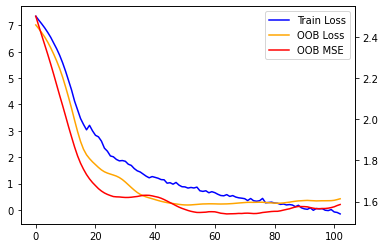

Bootstrap iteration 45 at time 2022-07-07 03:14:25.708084
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.585236549377441, MSE: 1.621888518333435
Epoch: 0, Loss: 7.154216766357422, OOB Loss: 6.780112266540527, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1631500720977783, MSE: 1.338857650756836
Epoch: 40, Loss: 1.3032467365264893, OOB Loss: 0.25797343254089355, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.465477228164673, MSE: 1.2545095682144165
Epoch: 80, Loss: 0.2532320022583008, OOB Loss: 0.04875588417053223, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.223085403442383, MSE: 1.251030445098877
Epoch: 120, Loss: -0.40549325942993164, OOB Loss: 0.4885430335998535, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.34525179862976074, best OOB loss: 0.020622968673706055, LR: 0.00036475054841530254


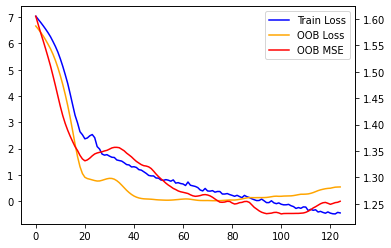

Bootstrap iteration 46 at time 2022-07-07 03:14:34.971265
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.336787223815918, MSE: 3.18410325050354
Epoch: 0, Loss: 7.211177825927734, OOB Loss: 6.990742206573486, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5869381427764893, MSE: 2.173980951309204
Epoch: 40, Loss: 0.9394497871398926, OOB Loss: 0.6383156776428223, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.18806791305542, MSE: 2.1476831436157227
Epoch: 80, Loss: 0.0652618408203125, OOB Loss: 0.4738025665283203, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.850494384765625, MSE: 2.114168405532837
Epoch: 120, Loss: -0.6604015827178955, OOB Loss: 0.8155760765075684, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.19098138809204102, best OOB loss: 0.43070268630981445, LR: 0.00036475054841530254


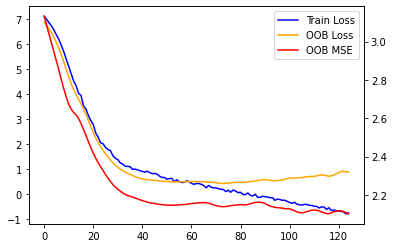

Bootstrap iteration 47 at time 2022-07-07 03:14:44.381428
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.022879123687744, MSE: 4.631542682647705
Epoch: 0, Loss: 6.718328475952148, OOB Loss: 6.654932975769043, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6065164804458618, MSE: 2.6400887966156006
Epoch: 40, Loss: 0.8500683307647705, OOB Loss: 0.7143524885177612, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.90485680103302, MSE: 2.4897987842559814
Epoch: 80, Loss: 0.1067659854888916, OOB Loss: 0.5156043767929077, LR: 0.00040823971994699836
Early stopped, best epoch: 55, train loss: 0.5589132308959961, best OOB loss: 0.468548059463501, LR: 0.000382517026148903


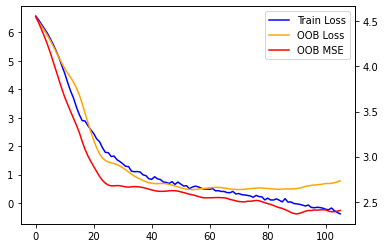

Bootstrap iteration 48 at time 2022-07-07 03:14:52.346641
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -7.101288795471191, MSE: 5.603004455566406
Epoch: 0, Loss: 7.576076030731201, OOB Loss: 7.713172435760498, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6795517206192017, MSE: 3.4274933338165283
Epoch: 40, Loss: 0.809330940246582, OOB Loss: 2.058424472808838, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9638186693191528, MSE: 3.196988582611084
Epoch: 80, Loss: -0.09298992156982422, OOB Loss: 1.740310788154602, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.2183566093444824, MSE: 2.937645673751831
Epoch: 120, Loss: -0.7411718368530273, OOB Loss: 1.9222044944763184, LR: 0.00036934432610923556
Early stopped, best epoch: 102, train loss: -0.41059184074401855, best OOB loss: 1.6704540252685547, LR: 0.0003400613507899008


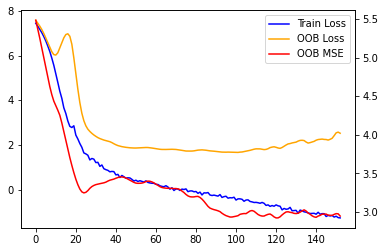

Bootstrap iteration 49 at time 2022-07-07 03:15:03.532287
Approximate NN size (MB):  77.7474365234375
OOB Mean Log Det Precision: -6.5376081466674805, MSE: 1.9555485248565674
Epoch: 0, Loss: 7.322257995605469, OOB Loss: 6.761255741119385, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.851682662963867, MSE: 1.2526767253875732
Epoch: 40, Loss: 1.4583865404129028, OOB Loss: -0.40520739555358887, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5578231811523438, MSE: 1.2854468822479248
Epoch: 80, Loss: 0.5747613906860352, OOB Loss: -0.6241345405578613, LR: 0.00040823971994699836
Early stopped, best epoch: 71, train loss: 0.7227261066436768, best OOB loss: -0.6279962062835693, LR: 0.0004041726062379909


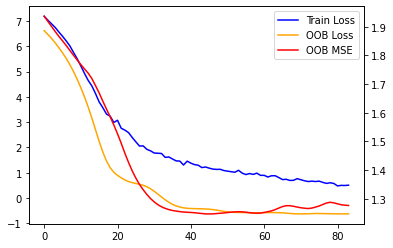

Time 0, 2022-07-07 03:15:10.656686
Time 5, 2022-07-07 03:28:53.820447
Time 10, 2022-07-07 03:42:32.505508
Time 15, 2022-07-07 03:56:03.911078
Time 20, 2022-07-07 04:09:36.470618
Time 25, 2022-07-07 04:23:06.770117
Time 30, 2022-07-07 04:36:38.398417
Time 35, 2022-07-07 04:50:09.708217
Time 40, 2022-07-07 05:03:44.268825
Time 45, 2022-07-07 05:17:17.847141
Time 50, 2022-07-07 05:30:53.163050
Time 55, 2022-07-07 05:44:25.720985
Size of x_mat before appending MARX (711, 6)
Size of x_mat_marx (711, 24)
x_mat_all size (711, 30)
Size of X_train afer appending time (711, 149) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (651, 149)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 1.128783106803894, OOB Loss: 1.1407157182693481
Epoch: 40, Loss: 0.6171268224716187, OOB Loss: 0.650978684425354
Early stopped, best epoch: 19, train loss: 0.6980732679367065, best OOB loss: 0.6259075403213501, LR: 0.00041963655153460226


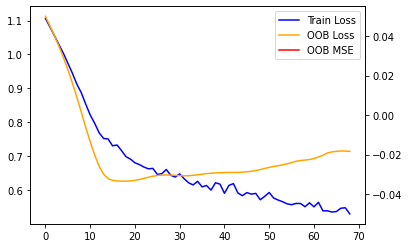

Bootstrap iteration 1 at time 2022-07-07 05:58:12.845062
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3013782501220703, OOB Loss: 1.381058931350708
Epoch: 40, Loss: 0.6025103330612183, OOB Loss: 0.7728134989738464
Epoch: 80, Loss: 0.5070507526397705, OOB Loss: 0.776362419128418
Early stopped, best epoch: 31, train loss: 0.6379014849662781, best OOB loss: 0.7569963335990906, LR: 0.0004062010728455131


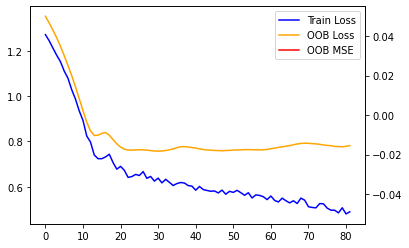

Bootstrap iteration 2 at time 2022-07-07 05:58:24.001887
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8975396156311035, OOB Loss: 1.4042924642562866
Epoch: 40, Loss: 0.5160226821899414, OOB Loss: 0.9656524658203125
Epoch: 80, Loss: 0.40614962577819824, OOB Loss: 1.0365381240844727
Early stopped, best epoch: 44, train loss: 0.49217042326927185, best OOB loss: 0.9649019241333008, LR: 0.00039516913294181626


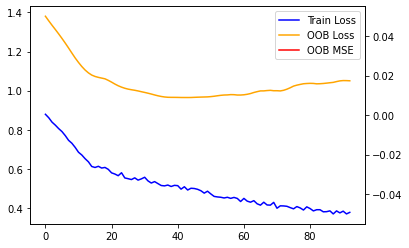

Bootstrap iteration 3 at time 2022-07-07 05:58:36.963497
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9620742201805115, OOB Loss: 1.2218377590179443
Epoch: 40, Loss: 0.5768605470657349, OOB Loss: 0.8801820278167725
Epoch: 80, Loss: 0.45969319343566895, OOB Loss: 0.9134654998779297
Early stopped, best epoch: 44, train loss: 0.5478571653366089, best OOB loss: 0.8743207454681396, LR: 0.0003931957570841881


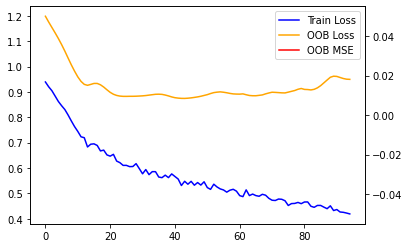

Bootstrap iteration 4 at time 2022-07-07 05:58:49.885601
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7230719923973083, OOB Loss: 1.6660630702972412
Epoch: 40, Loss: 0.45183461904525757, OOB Loss: 1.2400970458984375
Epoch: 80, Loss: 0.3903575837612152, OOB Loss: 1.1903122663497925
Epoch: 120, Loss: 0.32801902294158936, OOB Loss: 1.5258243083953857
Early stopped, best epoch: 81, train loss: 0.3872511088848114, best OOB loss: 1.184613823890686, LR: 0.0003584150883524932


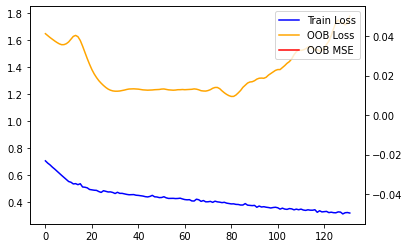

Bootstrap iteration 5 at time 2022-07-07 05:59:07.149258
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0142751932144165, OOB Loss: 1.1831204891204834
Epoch: 40, Loss: 0.5645734071731567, OOB Loss: 0.8839102983474731
Epoch: 80, Loss: 0.4899669289588928, OOB Loss: 0.9742035865783691
Early stopped, best epoch: 44, train loss: 0.5649604201316833, best OOB loss: 0.8791520595550537, LR: 0.0003931957570841881


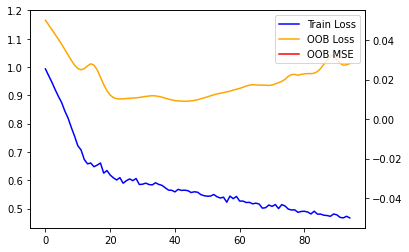

Bootstrap iteration 6 at time 2022-07-07 05:59:19.997643
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0718822479248047, OOB Loss: 0.5836719870567322
Epoch: 40, Loss: 0.6501356959342957, OOB Loss: 0.44852113723754883
Epoch: 80, Loss: 0.5627152919769287, OOB Loss: 0.4721132218837738
Early stopped, best epoch: 51, train loss: 0.6340463161468506, best OOB loss: 0.4394935071468353, LR: 0.00038733456018663577


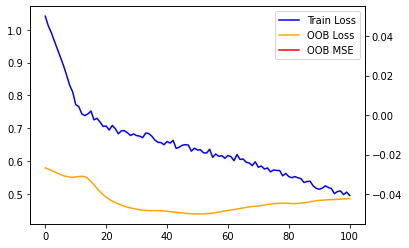

Bootstrap iteration 7 at time 2022-07-07 05:59:34.102105
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8952361345291138, OOB Loss: 0.903153121471405
Epoch: 40, Loss: 0.5536472201347351, OOB Loss: 0.7338787913322449
Epoch: 80, Loss: 0.42859405279159546, OOB Loss: 0.7838267087936401
Early stopped, best epoch: 51, train loss: 0.5300519466400146, best OOB loss: 0.7181934714317322, LR: 0.0003863662237861692


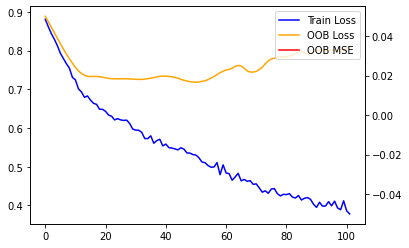

Bootstrap iteration 8 at time 2022-07-07 05:59:47.873366
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0748759508132935, OOB Loss: 1.1411516666412354
Epoch: 40, Loss: 0.5954067707061768, OOB Loss: 0.7037660479545593
Early stopped, best epoch: 20, train loss: 0.7005499601364136, best OOB loss: 0.6842724680900574, LR: 0.0004175409915053764


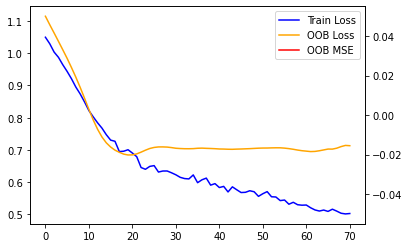

Bootstrap iteration 9 at time 2022-07-07 05:59:57.776647
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.060948371887207, OOB Loss: 0.4933971166610718
Epoch: 40, Loss: 0.6460493803024292, OOB Loss: 0.4560735821723938
Epoch: 80, Loss: 0.5262220501899719, OOB Loss: 0.43758291006088257
Epoch: 120, Loss: 0.4609149098396301, OOB Loss: 0.4381556510925293
Epoch: 160, Loss: 0.38332635164260864, OOB Loss: 0.44827181100845337
Early stopped, best epoch: 110, train loss: 0.45923948287963867, best OOB loss: 0.4281669557094574, LR: 0.00033331933788480705


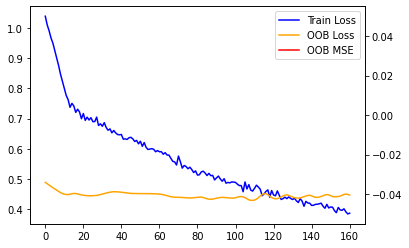

Bootstrap iteration 10 at time 2022-07-07 06:00:18.833664
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.827621340751648, OOB Loss: 1.416794776916504
Epoch: 40, Loss: 0.47733068466186523, OOB Loss: 1.1514610052108765
Early stopped, best epoch: 22, train loss: 0.5241615176200867, best OOB loss: 1.065316915512085, LR: 0.00041545589617904646


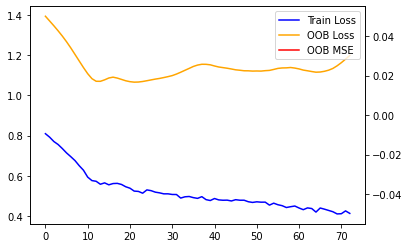

Bootstrap iteration 11 at time 2022-07-07 06:00:28.775695
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2545497417449951, OOB Loss: 0.6361120939254761
Epoch: 40, Loss: 0.6570131778717041, OOB Loss: 0.41462764143943787
Epoch: 80, Loss: 0.5712692141532898, OOB Loss: 0.39721593260765076
Epoch: 120, Loss: 0.4824432134628296, OOB Loss: 0.3886187672615051
Epoch: 160, Loss: 0.40771088004112244, OOB Loss: 0.4020310342311859
Early stopped, best epoch: 123, train loss: 0.4802577495574951, best OOB loss: 0.38684433698654175, LR: 0.0003226474723277302


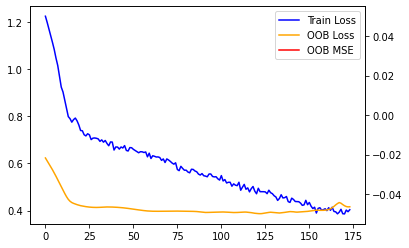

Bootstrap iteration 12 at time 2022-07-07 06:00:52.556403
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1425700187683105, OOB Loss: 0.8335206508636475
Epoch: 40, Loss: 0.6566343307495117, OOB Loss: 0.4785853326320648
Epoch: 80, Loss: 0.5639802813529968, OOB Loss: 0.45926612615585327
Epoch: 120, Loss: 0.45128482580184937, OOB Loss: 0.4560931324958801
Epoch: 160, Loss: 0.3884808421134949, OOB Loss: 0.46289849281311035
Early stopped, best epoch: 115, train loss: 0.47215747833251953, best OOB loss: 0.4522668719291687, LR: 0.00032917362660378724


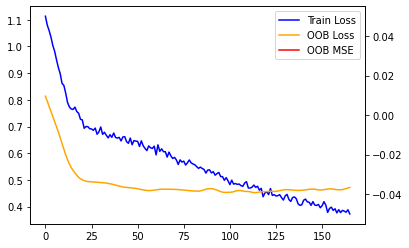

Bootstrap iteration 13 at time 2022-07-07 06:01:14.885374
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0582635402679443, OOB Loss: 1.0015588998794556
Epoch: 40, Loss: 0.6289783716201782, OOB Loss: 0.6390136480331421
Epoch: 80, Loss: 0.5130491256713867, OOB Loss: 0.6426915526390076
Early stopped, best epoch: 58, train loss: 0.5648912787437439, best OOB loss: 0.620085597038269, LR: 0.00037965531467019806


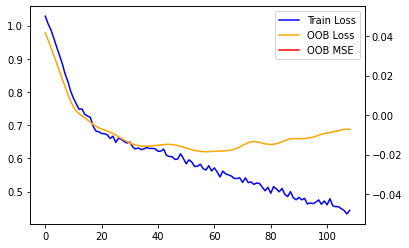

Bootstrap iteration 14 at time 2022-07-07 06:01:30.109131
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1740723848342896, OOB Loss: 0.8661514520645142
Epoch: 40, Loss: 0.6399561762809753, OOB Loss: 0.48178303241729736
Epoch: 80, Loss: 0.5534057021141052, OOB Loss: 0.4468294084072113
Epoch: 120, Loss: 0.4713040292263031, OOB Loss: 0.4391864538192749
Epoch: 160, Loss: 0.3988865315914154, OOB Loss: 0.4469171464443207
Early stopped, best epoch: 116, train loss: 0.4730249345302582, best OOB loss: 0.4349101781845093, LR: 0.0003283506925372778


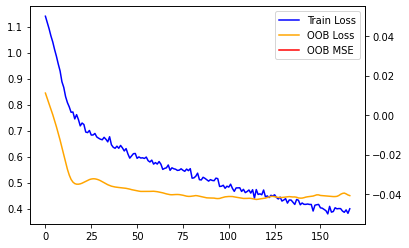

Bootstrap iteration 15 at time 2022-07-07 06:01:52.730081
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9332529902458191, OOB Loss: 1.7058318853378296
Epoch: 40, Loss: 0.5228266716003418, OOB Loss: 0.9850241541862488
Epoch: 80, Loss: 0.44784197211265564, OOB Loss: 1.035233736038208
Early stopped, best epoch: 44, train loss: 0.5226649045944214, best OOB loss: 0.9724221229553223, LR: 0.0003931957570841881


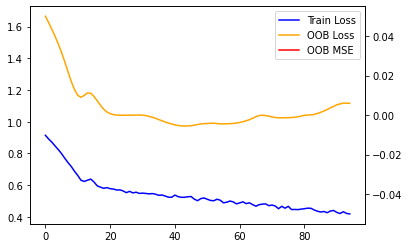

Bootstrap iteration 16 at time 2022-07-07 06:02:05.726824
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2619421482086182, OOB Loss: 1.1193077564239502
Epoch: 40, Loss: 0.6286150813102722, OOB Loss: 0.5445827841758728
Epoch: 80, Loss: 0.5123173594474792, OOB Loss: 0.5224524140357971
Epoch: 120, Loss: 0.46220219135284424, OOB Loss: 0.5003089904785156
Epoch: 160, Loss: 0.3841003179550171, OOB Loss: 0.49336227774620056
Early stopped, best epoch: 134, train loss: 0.43388208746910095, best OOB loss: 0.4913162589073181, LR: 0.00031388474922642277


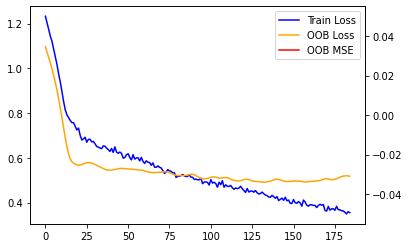

Bootstrap iteration 17 at time 2022-07-07 06:02:30.400792
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.059633731842041, OOB Loss: 0.9646128416061401
Epoch: 40, Loss: 0.6258771419525146, OOB Loss: 0.5423183441162109
Epoch: 80, Loss: 0.5003433227539062, OOB Loss: 0.5956406593322754
Early stopped, best epoch: 44, train loss: 0.6313418745994568, best OOB loss: 0.5375146865844727, LR: 0.0003931957570841881


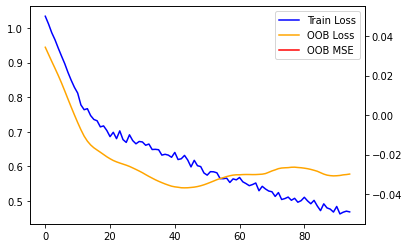

Bootstrap iteration 18 at time 2022-07-07 06:02:43.589153
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1591553688049316, OOB Loss: 0.8986713290214539
Epoch: 40, Loss: 0.6450023651123047, OOB Loss: 0.533846378326416
Epoch: 80, Loss: 0.5486714839935303, OOB Loss: 0.5006126761436462
Epoch: 120, Loss: 0.4573427140712738, OOB Loss: 0.4877500534057617
Early stopped, best epoch: 106, train loss: 0.5010226964950562, best OOB loss: 0.484912633895874, LR: 0.00033667346834210566


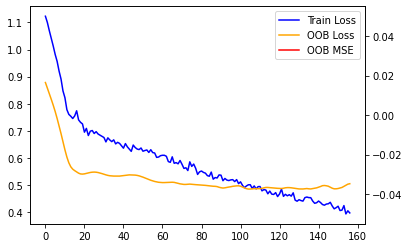

Bootstrap iteration 19 at time 2022-07-07 06:03:04.876589
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1421773433685303, OOB Loss: 0.6321660876274109
Epoch: 40, Loss: 0.6472470760345459, OOB Loss: 0.5000812411308289
Epoch: 80, Loss: 0.5405861139297485, OOB Loss: 0.485623836517334
Epoch: 120, Loss: 0.44591832160949707, OOB Loss: 0.5016345977783203
Early stopped, best epoch: 82, train loss: 0.5244988203048706, best OOB loss: 0.4852387309074402, LR: 0.00035751905063161196


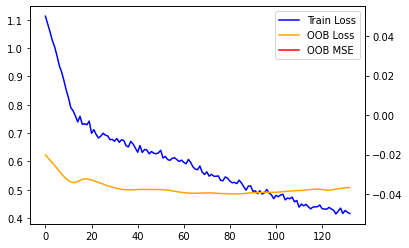

Bootstrap iteration 20 at time 2022-07-07 06:03:23.085602
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9570616483688354, OOB Loss: 3.0286717414855957
Epoch: 40, Loss: 0.5160537958145142, OOB Loss: 1.1973659992218018
Early stopped, best epoch: 21, train loss: 0.5439058542251587, best OOB loss: 1.1646082401275635, LR: 0.00041649713902661297


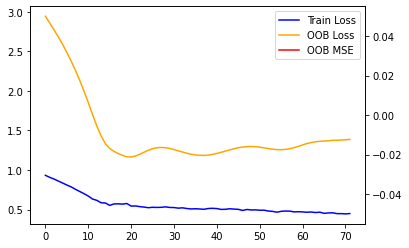

Bootstrap iteration 21 at time 2022-07-07 06:03:33.235164
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0395445823669434, OOB Loss: 1.3694732189178467
Epoch: 40, Loss: 0.5563356280326843, OOB Loss: 1.0120586156845093
Epoch: 80, Loss: 0.4773895740509033, OOB Loss: 0.9869034290313721
Epoch: 120, Loss: 0.4132259786128998, OOB Loss: 1.0700256824493408
Early stopped, best epoch: 82, train loss: 0.48347753286361694, best OOB loss: 0.9796552658081055, LR: 0.00035751905063161196


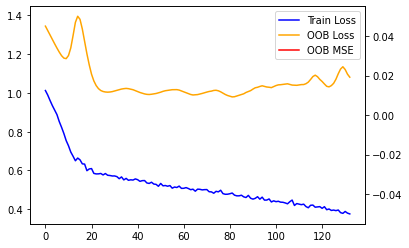

Bootstrap iteration 22 at time 2022-07-07 06:03:50.810978
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1605174541473389, OOB Loss: 0.8066867589950562
Epoch: 40, Loss: 0.6344959139823914, OOB Loss: 0.6133575439453125
Epoch: 80, Loss: 0.5166744589805603, OOB Loss: 0.6188137531280518
Early stopped, best epoch: 55, train loss: 0.5670088529586792, best OOB loss: 0.6017138361930847, LR: 0.000382517026148903


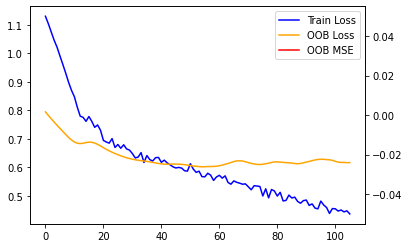

Bootstrap iteration 23 at time 2022-07-07 06:04:05.408609
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8967276811599731, OOB Loss: 0.6030457019805908
Epoch: 40, Loss: 0.6060886383056641, OOB Loss: 0.521101176738739
Epoch: 80, Loss: 0.48193714022636414, OOB Loss: 0.524489164352417
Early stopped, best epoch: 56, train loss: 0.5586123466491699, best OOB loss: 0.5197924971580505, LR: 0.00038156073358353075


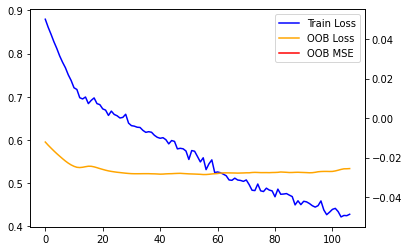

Bootstrap iteration 24 at time 2022-07-07 06:04:19.861305
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7656829357147217, OOB Loss: 2.2894694805145264
Epoch: 40, Loss: 0.4557100534439087, OOB Loss: 1.7199658155441284
Early stopped, best epoch: 14, train loss: 0.5470263361930847, best OOB loss: 1.477884292602539, LR: 0.0004238592760468668


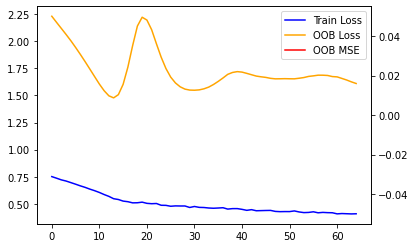

Bootstrap iteration 25 at time 2022-07-07 06:04:28.861447
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.199080228805542, OOB Loss: 1.1286664009094238
Epoch: 40, Loss: 0.6176176071166992, OOB Loss: 0.6477561593055725
Epoch: 80, Loss: 0.5282388925552368, OOB Loss: 0.676078736782074
Early stopped, best epoch: 34, train loss: 0.6307497024536133, best OOB loss: 0.6421760320663452, LR: 0.00040316217472239593


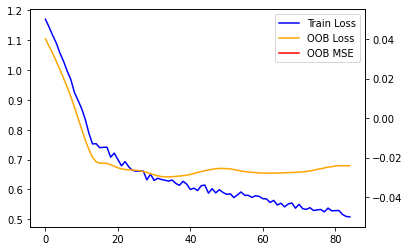

Bootstrap iteration 26 at time 2022-07-07 06:04:40.610075
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.7692409753799438, OOB Loss: 1.830085277557373
Epoch: 40, Loss: 0.47809505462646484, OOB Loss: 1.3637703657150269
Epoch: 80, Loss: 0.39957675337791443, OOB Loss: 1.4651249647140503
Early stopped, best epoch: 45, train loss: 0.4609522223472595, best OOB loss: 1.3373768329620361, LR: 0.0003922127676914776


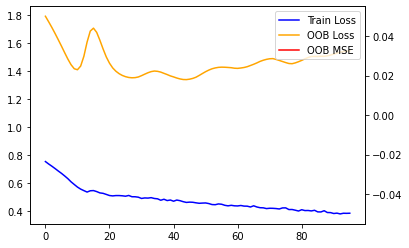

Bootstrap iteration 27 at time 2022-07-07 06:04:53.481977
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1703226566314697, OOB Loss: 0.768702507019043
Epoch: 40, Loss: 0.6267527341842651, OOB Loss: 0.4443504810333252
Epoch: 80, Loss: 0.5295318365097046, OOB Loss: 0.42872175574302673
Epoch: 120, Loss: 0.4544316232204437, OOB Loss: 0.43603333830833435
Early stopped, best epoch: 89, train loss: 0.5302339792251587, best OOB loss: 0.4232097268104553, LR: 0.00035130919659078646


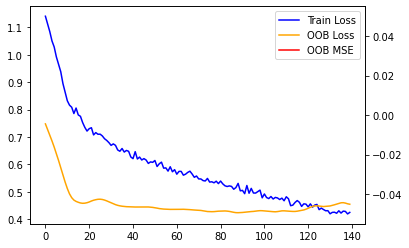

Bootstrap iteration 28 at time 2022-07-07 06:05:12.680752
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.171661615371704, OOB Loss: 0.9669105410575867
Epoch: 40, Loss: 0.6321581602096558, OOB Loss: 0.5320748686790466
Epoch: 80, Loss: 0.5478591918945312, OOB Loss: 0.5394901633262634
Early stopped, best epoch: 35, train loss: 0.6520843505859375, best OOB loss: 0.5275044441223145, LR: 0.00040215426928559


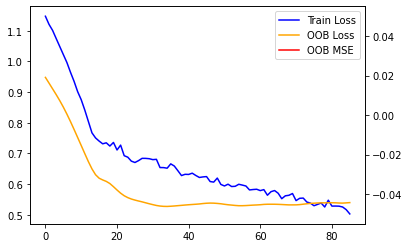

Bootstrap iteration 29 at time 2022-07-07 06:05:24.643279
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.4428986310958862, OOB Loss: 0.8461005091667175
Epoch: 40, Loss: 0.6397659182548523, OOB Loss: 0.5445132255554199
Epoch: 80, Loss: 0.5321444272994995, OOB Loss: 0.5377955436706543
Epoch: 120, Loss: 0.46347081661224365, OOB Loss: 0.5588521957397461
Early stopped, best epoch: 86, train loss: 0.5267581939697266, best OOB loss: 0.5359645485877991, LR: 0.0003539572447587195


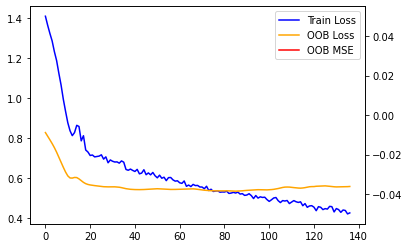

Bootstrap iteration 30 at time 2022-07-07 06:05:43.343084
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8906152248382568, OOB Loss: 1.3326008319854736
Epoch: 40, Loss: 0.5496495366096497, OOB Loss: 0.8520185351371765
Epoch: 80, Loss: 0.44828057289123535, OOB Loss: 0.943189799785614
Early stopped, best epoch: 55, train loss: 0.520885169506073, best OOB loss: 0.8242443799972534, LR: 0.000382517026148903


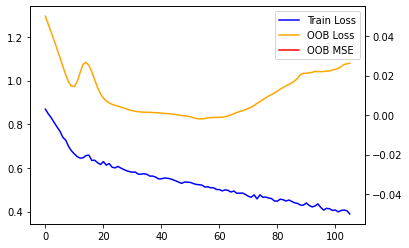

Bootstrap iteration 31 at time 2022-07-07 06:05:58.220649
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.5122489929199219, OOB Loss: 0.6057770252227783
Epoch: 40, Loss: 0.6952161192893982, OOB Loss: 0.39911481738090515
Epoch: 80, Loss: 0.5968729853630066, OOB Loss: 0.3717593550682068
Epoch: 120, Loss: 0.5185180902481079, OOB Loss: 0.3606840968132019
Epoch: 160, Loss: 0.4510745406150818, OOB Loss: 0.3741147518157959
Early stopped, best epoch: 120, train loss: 0.5185180902481079, best OOB loss: 0.3606840968132019, LR: 0.00032507947825378313


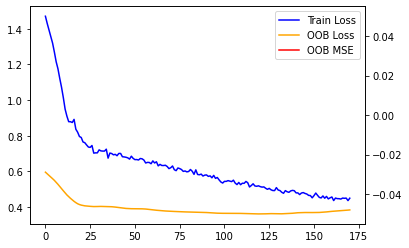

Bootstrap iteration 32 at time 2022-07-07 06:06:22.509653
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9370348453521729, OOB Loss: 1.184570074081421
Epoch: 40, Loss: 0.5582175254821777, OOB Loss: 0.87352055311203
Epoch: 80, Loss: 0.42833441495895386, OOB Loss: 0.9992782473564148
Early stopped, best epoch: 45, train loss: 0.5482508540153503, best OOB loss: 0.8666197061538696, LR: 0.0003922127676914776


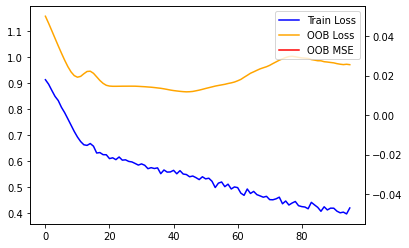

Bootstrap iteration 33 at time 2022-07-07 06:06:35.561086
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0498404502868652, OOB Loss: 0.6894239187240601
Epoch: 40, Loss: 0.6289445161819458, OOB Loss: 0.5180122256278992
Epoch: 80, Loss: 0.529518723487854, OOB Loss: 0.5109935998916626
Early stopped, best epoch: 65, train loss: 0.5540735721588135, best OOB loss: 0.5005385875701904, LR: 0.00037306096931780195


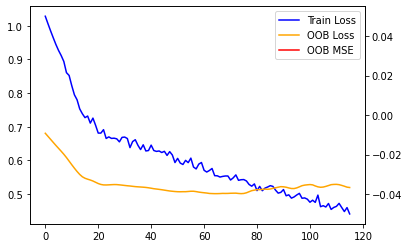

Bootstrap iteration 34 at time 2022-07-07 06:06:51.854300
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0606220960617065, OOB Loss: 0.47553008794784546
Epoch: 40, Loss: 0.6698266267776489, OOB Loss: 0.3822022080421448
Early stopped, best epoch: 13, train loss: 0.7759988307952881, best OOB loss: 0.3790484368801117, LR: 0.0004249215799968589


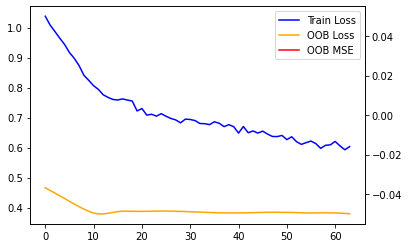

Bootstrap iteration 35 at time 2022-07-07 06:07:00.937595
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8146030306816101, OOB Loss: 1.1884255409240723
Epoch: 40, Loss: 0.5178389549255371, OOB Loss: 0.9255000948905945
Epoch: 80, Loss: 0.39961838722229004, OOB Loss: 0.9946455955505371
Early stopped, best epoch: 35, train loss: 0.5450049042701721, best OOB loss: 0.9184243083000183, LR: 0.00040215426928559


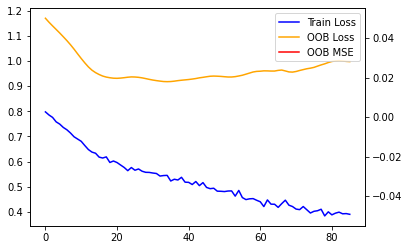

Bootstrap iteration 36 at time 2022-07-07 06:07:12.590150
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2569658756256104, OOB Loss: 0.9055895209312439
Epoch: 40, Loss: 0.6426007151603699, OOB Loss: 0.6093348860740662
Epoch: 80, Loss: 0.5221514105796814, OOB Loss: 0.6567569971084595
Early stopped, best epoch: 39, train loss: 0.6489158868789673, best OOB loss: 0.6089903116226196, LR: 0.00039814778225889965


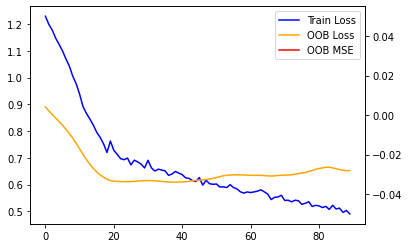

Bootstrap iteration 37 at time 2022-07-07 06:07:24.987787
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2204468250274658, OOB Loss: 0.975827157497406
Epoch: 40, Loss: 0.645072340965271, OOB Loss: 0.6232794523239136
Epoch: 80, Loss: 0.5404242277145386, OOB Loss: 0.665570855140686
Early stopped, best epoch: 39, train loss: 0.6600590944290161, best OOB loss: 0.623265266418457, LR: 0.00039814778225889965


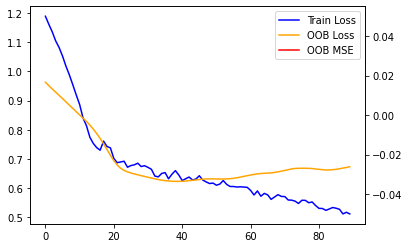

Bootstrap iteration 38 at time 2022-07-07 06:07:37.429451
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0128239393234253, OOB Loss: 0.7876883745193481
Epoch: 40, Loss: 0.6240886449813843, OOB Loss: 0.5466159582138062
Epoch: 80, Loss: 0.5123535990715027, OOB Loss: 0.5532647371292114
Early stopped, best epoch: 45, train loss: 0.5910293459892273, best OOB loss: 0.5413964986801147, LR: 0.0003922127676914776


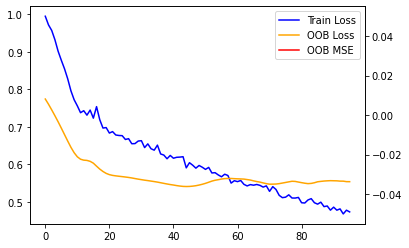

Bootstrap iteration 39 at time 2022-07-07 06:07:51.071883
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.382272720336914, OOB Loss: 0.6061076521873474
Epoch: 40, Loss: 0.6874566078186035, OOB Loss: 0.4056907892227173
Epoch: 80, Loss: 0.5619351863861084, OOB Loss: 0.39487403631210327
Epoch: 120, Loss: 0.4726064205169678, OOB Loss: 0.37575095891952515
Epoch: 160, Loss: 0.4164552092552185, OOB Loss: 0.3851252794265747
Early stopped, best epoch: 138, train loss: 0.45812293887138367, best OOB loss: 0.3718752861022949, LR: 0.00031075765280671894


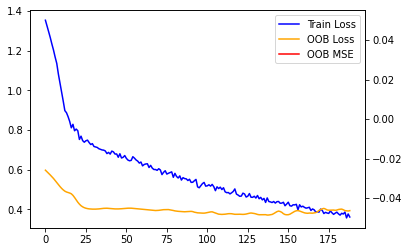

Bootstrap iteration 40 at time 2022-07-07 06:08:16.463015
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.0640019178390503, OOB Loss: 1.1919829845428467
Epoch: 40, Loss: 0.6128233671188354, OOB Loss: 0.6991558074951172
Epoch: 80, Loss: 0.5059545040130615, OOB Loss: 0.6897743940353394
Early stopped, best epoch: 46, train loss: 0.5837886333465576, best OOB loss: 0.6893441081047058, LR: 0.00039123223577224893


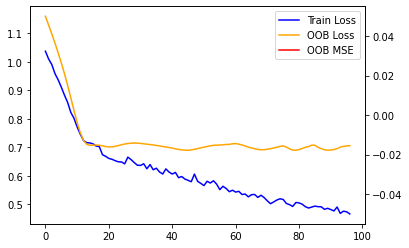

Bootstrap iteration 41 at time 2022-07-07 06:08:29.696362
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8911371231079102, OOB Loss: 1.4173598289489746
Epoch: 40, Loss: 0.5810477137565613, OOB Loss: 0.8861222267150879
Epoch: 80, Loss: 0.45845890045166016, OOB Loss: 0.999966561794281
Early stopped, best epoch: 31, train loss: 0.5913740992546082, best OOB loss: 0.876288652420044, LR: 0.0004062010728455131


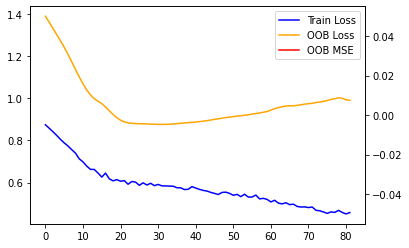

Bootstrap iteration 42 at time 2022-07-07 06:08:41.028218
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8041645288467407, OOB Loss: 1.7711296081542969
Epoch: 40, Loss: 0.46953994035720825, OOB Loss: 1.2289929389953613
Epoch: 80, Loss: 0.4108453691005707, OOB Loss: 1.2921409606933594
Early stopped, best epoch: 46, train loss: 0.4621134400367737, best OOB loss: 1.2235872745513916, LR: 0.00039123223577224893


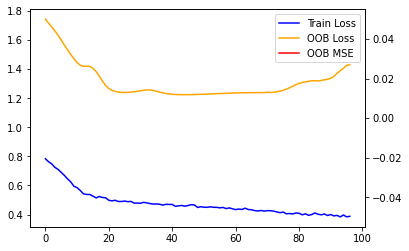

Bootstrap iteration 43 at time 2022-07-07 06:08:54.546401
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1984832286834717, OOB Loss: 1.264502763748169
Epoch: 40, Loss: 0.6460191011428833, OOB Loss: 0.667726993560791
Epoch: 80, Loss: 0.5434088706970215, OOB Loss: 0.6574560403823853
Early stopped, best epoch: 57, train loss: 0.6128628253936768, best OOB loss: 0.654033362865448, LR: 0.00038060683174957196


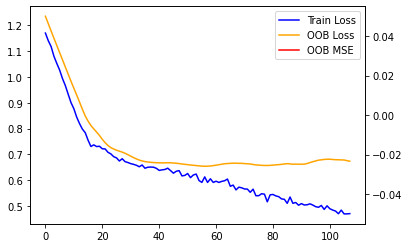

Bootstrap iteration 44 at time 2022-07-07 06:09:09.856440
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.066098690032959, OOB Loss: 0.8743380904197693
Epoch: 40, Loss: 0.6111973524093628, OOB Loss: 0.633012056350708
Epoch: 80, Loss: 0.4767463803291321, OOB Loss: 0.6644232273101807
Early stopped, best epoch: 59, train loss: 0.5625643730163574, best OOB loss: 0.627734899520874, LR: 0.00037870617638352256


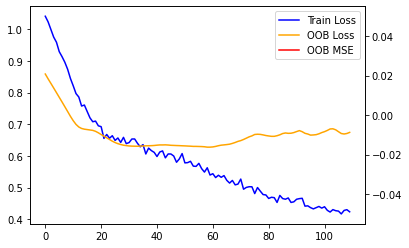

Bootstrap iteration 45 at time 2022-07-07 06:09:24.974108
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.3906786441802979, OOB Loss: 1.1615657806396484
Epoch: 40, Loss: 0.6385185718536377, OOB Loss: 0.6344940662384033
Epoch: 80, Loss: 0.5314289331436157, OOB Loss: 0.6324700713157654
Epoch: 120, Loss: 0.4443593919277191, OOB Loss: 0.6851053237915039
Early stopped, best epoch: 94, train loss: 0.5030350685119629, best OOB loss: 0.6122246980667114, LR: 0.0003469397336347074


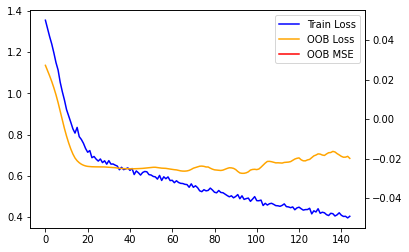

Bootstrap iteration 46 at time 2022-07-07 06:09:44.691403
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.2743486166000366, OOB Loss: 0.7615036964416504
Epoch: 40, Loss: 0.6564669609069824, OOB Loss: 0.4296755790710449
Epoch: 80, Loss: 0.5516151785850525, OOB Loss: 0.41348981857299805
Epoch: 120, Loss: 0.4889317452907562, OOB Loss: 0.4233001172542572
Early stopped, best epoch: 92, train loss: 0.5275239944458008, best OOB loss: 0.41248369216918945, LR: 0.0003486809591745855


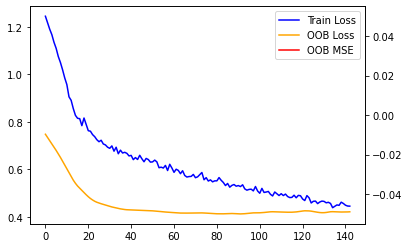

Bootstrap iteration 47 at time 2022-07-07 06:10:04.638999
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.8161290884017944, OOB Loss: 1.4502419233322144
Epoch: 40, Loss: 0.49038776755332947, OOB Loss: 1.044560432434082
Early stopped, best epoch: 27, train loss: 0.5423866510391235, best OOB loss: 1.0065534114837646, LR: 0.00041028859863643906


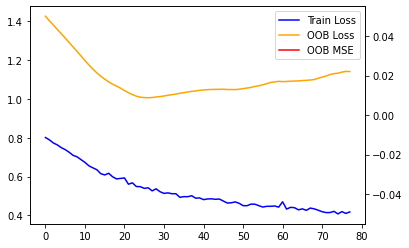

Bootstrap iteration 48 at time 2022-07-07 06:10:15.320172
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 0.9684960842132568, OOB Loss: 0.8574761152267456
Epoch: 40, Loss: 0.6228732466697693, OOB Loss: 0.6789683103561401
Early stopped, best epoch: 26, train loss: 0.6663030385971069, best OOB loss: 0.6673204302787781, LR: 0.000411316890863598


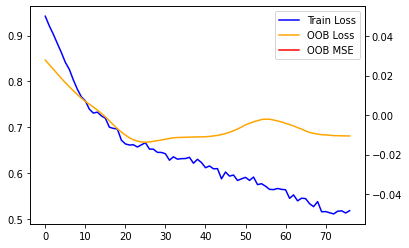

Bootstrap iteration 49 at time 2022-07-07 06:10:26.054458
Approximate NN size (MB):  77.7474365234375
Epoch: 0, Loss: 1.1211562156677246, OOB Loss: 0.9303641319274902
Epoch: 40, Loss: 0.6273650527000427, OOB Loss: 0.5517609119415283
Epoch: 80, Loss: 0.517352819442749, OOB Loss: 0.5795508623123169
Early stopped, best epoch: 50, train loss: 0.5976285934448242, best OOB loss: 0.5503665804862976, LR: 0.00038733456018663577


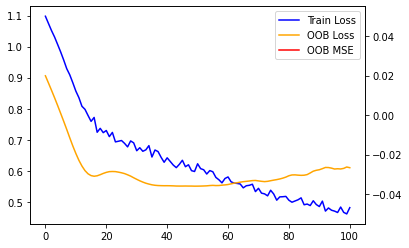

Time 0, 2022-07-07 06:10:40.378968
Time 5, 2022-07-07 06:24:31.823188
Time 10, 2022-07-07 06:38:19.093962
Time 15, 2022-07-07 06:52:04.141446
Time 20, 2022-07-07 07:05:48.813366
Time 25, 2022-07-07 07:19:33.673055
Time 30, 2022-07-07 07:33:15.250495
Time 35, 2022-07-07 07:47:26.038676


In [ ]:
experiment_name = '6jul_multi_forecasting'
test_size = T

folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

for variable_list in variable_lists:
  # Select variables for experiment
  print('Variables', variable_list)
  x_d = x_d_all.copy()
  x_d = x_d[variable_list]
  x_d_colnames = x_d.columns
  var_names = x_d.columns
  n_var = len(var_names)
  nn_hyps['variable_list'] = variable_list

  train_size = x_d.shape[0] - test_size - nn_hyps['n_lag_d']
  if nn_hyps['fix_bootstrap'] == True:
    bootstrap_indices = get_bootstrap_indices(num_bootstrap = num_inner_bootstraps, n_obs = train_size, block_size = nn_hyps['block_size'], sampling_rate = nn_hyps['sampling_rate'], opt_bootstrap = nn_hyps['opt_bootstrap'])
    nn_hyps['bootstrap_indices'] = bootstrap_indices
  else:
    nn_hyps['bootstrap_indices'] = None

  # Save experiment param list
  with open(f'{folder_path}/params.npz', 'wb') as f:
      np.savez(f, params = experiment_params, date = datetime.now())

  for repeat in range(num_repeats):
    for i in range(len(experiment_params)):

      nn_hyps.update(experiment_params[i])

      n_betas = n_var * nn_hyps['n_lag_linear'] + 1
      n_inputs_wo_time = n_var * (nn_hyps['n_lag_linear'] + nn_hyps['n_lag_d'])

      X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps = process_varnn_data(x_d, nn_hyps, test_size = test_size, n_time_trends = 100, time_dummy_setting = nn_hyps['time_dummy_setting'], marx = nn_hyps['marx'], dummy_interval = nn_hyps['dummy_interval'])

      n_inputs_total = X_train.shape[1]
      nn_hyps['neurons_weights'] = [nn_hyps['tvpl_archi'] for i in range(n_betas)]

      # If s_pos is already not defined (s_pos can be defined by user)
      if not nn_hyps.get('s_pos'):
        # s_pos_setting
        if nn_hyps['s_pos_setting']['is_hemi'] == False:
          nn_hyps['s_pos'] = [ list(range(n_inputs_total)) ]
        else:
          n_inputs_total_new = n_inputs_wo_time + nn_hyps['s_pos_setting']['n_times']
          nn_hyps['s_pos'] = [ list(range(n_inputs_wo_time)), list(range(n_inputs_wo_time, n_inputs_total_new))]
          # Subset the X_train and X_test to only the required columns
          X_train = X_train[:, :n_inputs_total_new]
          X_test = X_test[:, :n_inputs_total_new]

      if nn_hyps['forecast_method'] == 'New':
        predict_fn = predict_one_bootstrap_new
      else:
        predict_fn = predict_one_bootstrap_old

      print(nn_hyps['s_pos'])

      ### FORECASTING NEW CODE
      # Fix the shock ids across the different models
      error_ids = np.array(random.choices(range(X_train.shape[0]), k = h * B * T))
      error_ids = error_ids.reshape((h, B, T))

      # Test prediction array
      FCAST = np.zeros((h+1, n_var, B, T, R))
      FCAST[:] = np.nan

      for r in range(R):
        print(f'Re-estimation window {r}, {datetime.now()}')

        # Training data is the data available till that moment
        X_train = x_mat_all[:-(test_size - reestimation_window * r), :]
        Y_train = y_mat[:-(test_size - reestimation_window * r), :]

        results = conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device)

        if r == 0:
          BETAS = results['betas_draws']
          BETAS_IN = results['betas_in_draws']
          SIGMAS = results['sigmas_draws']
          SIGMAS_IN = results['sigmas_in_draws']
          PRECISION = results['precision_draws']
          PRECISION_IN = results['precision_in_draws']
          CHOLESKY = results['cholesky_draws']
          CHOLESKY_IN = results['cholesky_in_draws']
          PREDS = results['pred_in_ensemble'] 
          PREDS_TEST = results['pred_ensemble']

          with open(f'{folder_path}/params_{i}_repeat_{repeat}.npz', 'wb') as f:
            np.savez(f, betas = BETAS, betas_in = BETAS_IN, 
                    sigmas = SIGMAS, sigmas_in = SIGMAS_IN,
                    precision = PRECISION, precision_in = PRECISION_IN,
                    cholesky = CHOLESKY, cholesky_in = CHOLESKY_IN,
                    train_preds = PREDS, test_preds = PREDS_TEST, 
                    y = Y_train, y_test = Y_test, 
                    params = nn_hyps)
            
        # For every timestep (in the future), for every bootstrap, get the h-th horizon prediction
        for t in range(r * reestimation_window, T):
          if t % 5 == 0:
            print(f'Time {t}, {datetime.now()}')
          for b in range(B):
            if t == r * reestimation_window: # first sample (X_train is continually changed so can take last value of X_train)
              FCAST[:, :, b, t, r] = predict_fn(X_train[-1, :], results, error_ids[:, b, t], nn_hyps)
            else: # not the first sample (X_test is unchanged so can just index t)
              FCAST[:, :, b, t, r] = predict_fn(X_test[t, :], results, error_ids[:, b, t], nn_hyps)
        
      del nn_hyps['s_pos']

      with open(f'{folder_path}/params_{i}_forecasting_repeat_{repeat}.npz', 'wb') as f:
        np.save(f, FCAST)

### Benchmarks to compare VARNN Against

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

n_lag_linear = 2

In [ ]:
experiment_name = '15jun_multi_forecasting'
test_size = T

folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

Folder already exists


In [ ]:
variable_list = variable_lists[0]
x_d = x_d_all.copy()
x_d = x_d[variable_list]
x_d_colnames = x_d.columns
var_names = x_d.columns
n_var = len(var_names)

In [ ]:
### Expanding Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

data = np.array(data)
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]
  
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/expanding_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 21:40:33.311614
(2, 3)


In [ ]:
### Rolling Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment - *restricted to the length of window
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/rolling_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 21:41:09.851281


In [ ]:
def get_ar_forecasts(y_in, results_coefs, h):
  # y_in should be of length 'ar_lags' - all you need to start iterating forward
  
  # Store both train and test 
  y_all = np.zeros((y_in.shape[0] + h))
  y_all[:] = np.nan
  y_all[:y_in.shape[0]] = y_in

  for horizon in range(1, h+1):
    # Get the input lags for 
    y_in_this = y_all[(y_in.shape[0] -1 -4 + horizon):(y_in.shape[0] -1 + horizon)]
    # Evaluate the AR equation to get the prediction
    y_all[y_in.shape[0] - 1 + horizon] = results_coefs[0] + np.dot(results_coefs[1:], y_in)

  # Return h predictions
  return y_all[y_in.shape[0]:]

In [ ]:
### Expanding Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/expanding_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 23:24:52.252451
Re-estimation window 1, 2022-06-17 23:24:54.397479


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 2, 2022-06-17 23:24:57.622641
Re-estimation window 3, 2022-06-17 23:24:59.114346
Re-estimation window 4, 2022-06-17 23:25:00.689837
Re-estimation window 5, 2022-06-17 23:25:02.065021
Re-estimation window 6, 2022-06-17 23:25:03.579679
Re-estimation window 7, 2022-06-17 23:25:04.899740
Re-estimation window 8, 2022-06-17 23:25:06.142552
Re-estimation window 9, 2022-06-17 23:25:07.304450
Re-estimation window 10, 2022-06-17 23:25:09.435681
Re-estimation window 11, 2022-06-17 23:25:11.055106
Re-estimation window 12, 2022-06-17 23:25:12.773911
Re-estimation window 13, 2022-06-17 23:25:14.351466
Re-estimation window 14, 2022-06-17 23:25:15.578412
Re-estimation window 15, 2022-06-17 23:25:16.812903
Re-estimation window 16, 2022-06-17 23:25:18.376501


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 17, 2022-06-17 23:25:20.458416
Re-estimation window 18, 2022-06-17 23:25:21.941324


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 19, 2022-06-17 23:25:23.980050
Re-estimation window 20, 2022-06-17 23:25:25.614310
Re-estimation window 21, 2022-06-17 23:25:26.862580
Re-estimation window 22, 2022-06-17 23:25:28.382334
Re-estimation window 23, 2022-06-17 23:25:29.771904
Re-estimation window 24, 2022-06-17 23:25:31.051674
Re-estimation window 25, 2022-06-17 23:25:32.773161
Re-estimation window 26, 2022-06-17 23:25:34.609915
Re-estimation window 27, 2022-06-17 23:25:36.125466
Re-estimation window 28, 2022-06-17 23:25:37.683670


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 29, 2022-06-17 23:25:39.779743
Re-estimation window 30, 2022-06-17 23:25:41.256862
Re-estimation window 31, 2022-06-17 23:25:42.804874
Re-estimation window 32, 2022-06-17 23:25:44.347131
Re-estimation window 33, 2022-06-17 23:25:45.975145
Re-estimation window 34, 2022-06-17 23:25:47.543781
Re-estimation window 35, 2022-06-17 23:25:49.141360


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 36, 2022-06-17 23:25:51.244459


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 37, 2022-06-17 23:25:53.785401
Re-estimation window 38, 2022-06-17 23:25:56.434199
Re-estimation window 39, 2022-06-17 23:25:58.008241
Re-estimation window 40, 2022-06-17 23:25:59.268038
Re-estimation window 41, 2022-06-17 23:26:00.605628
Re-estimation window 42, 2022-06-17 23:26:02.004803
Re-estimation window 43, 2022-06-17 23:26:03.696986
Re-estimation window 44, 2022-06-17 23:26:05.344045
Re-estimation window 45, 2022-06-17 23:26:06.888347
Re-estimation window 46, 2022-06-17 23:26:08.850990
Re-estimation window 47, 2022-06-17 23:26:10.490944
Re-estimation window 48, 2022-06-17 23:26:12.048801
Re-estimation window 49, 2022-06-17 23:26:13.603358
Re-estimation window 50, 2022-06-17 23:26:15.217145
Re-estimation window 51, 2022-06-17 23:26:16.784168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 52, 2022-06-17 23:26:18.940851


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 53, 2022-06-17 23:26:21.066308


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 54, 2022-06-17 23:26:23.218578
Re-estimation window 55, 2022-06-17 23:26:24.845132
Re-estimation window 56, 2022-06-17 23:26:26.389276
Re-estimation window 57, 2022-06-17 23:26:28.012853
Re-estimation window 58, 2022-06-17 23:26:29.676621
Re-estimation window 59, 2022-06-17 23:26:31.093597
Re-estimation window 60, 2022-06-17 23:26:32.448542
Re-estimation window 61, 2022-06-17 23:26:34.003367


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 62, 2022-06-17 23:26:36.199417
Re-estimation window 63, 2022-06-17 23:26:37.776925
Re-estimation window 64, 2022-06-17 23:26:39.457674
Re-estimation window 65, 2022-06-17 23:26:41.090028


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 66, 2022-06-17 23:26:43.367393
Re-estimation window 67, 2022-06-17 23:26:44.987638
Re-estimation window 68, 2022-06-17 23:26:46.676053


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 69, 2022-06-17 23:26:48.905837


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 70, 2022-06-17 23:26:51.163711
Re-estimation window 71, 2022-06-17 23:26:52.874610
Re-estimation window 72, 2022-06-17 23:26:54.485997
Re-estimation window 73, 2022-06-17 23:26:56.119959
Re-estimation window 74, 2022-06-17 23:26:57.674946
Re-estimation window 75, 2022-06-17 23:26:59.133415
Re-estimation window 76, 2022-06-17 23:27:00.620656


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 77, 2022-06-17 23:27:02.644137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 78, 2022-06-17 23:27:04.679967
Re-estimation window 79, 2022-06-17 23:27:05.568896
Re-estimation window 80, 2022-06-17 23:27:06.404287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 81, 2022-06-17 23:27:08.324612
Re-estimation window 82, 2022-06-17 23:27:09.596942
Re-estimation window 83, 2022-06-17 23:27:10.389944
Re-estimation window 84, 2022-06-17 23:27:11.200983
Re-estimation window 85, 2022-06-17 23:27:12.572045
Re-estimation window 86, 2022-06-17 23:27:13.874660


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 87, 2022-06-17 23:27:15.716057


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 88, 2022-06-17 23:27:17.604162
Re-estimation window 89, 2022-06-17 23:27:18.386204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
### Rolling Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/rolling_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-06-17 23:27:20.311823
Re-estimation window 1, 2022-06-17 23:27:20.861230
Re-estimation window 2, 2022-06-17 23:27:21.458066
Re-estimation window 3, 2022-06-17 23:27:21.978616
Re-estimation window 4, 2022-06-17 23:27:22.395175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 5, 2022-06-17 23:27:23.072218
Re-estimation window 6, 2022-06-17 23:27:23.595624
Re-estimation window 7, 2022-06-17 23:27:24.169657
Re-estimation window 8, 2022-06-17 23:27:24.681305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 9, 2022-06-17 23:27:25.188307
Re-estimation window 10, 2022-06-17 23:27:25.678996
Re-estimation window 11, 2022-06-17 23:27:26.318459
Re-estimation window 12, 2022-06-17 23:27:26.769336
Re-estimation window 13, 2022-06-17 23:27:27.252183
Re-estimation window 14, 2022-06-17 23:27:27.839497
Re-estimation window 15, 2022-06-17 23:27:28.468849
Re-estimation window 16, 2022-06-17 23:27:28.978554


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 17, 2022-06-17 23:27:29.714852
Re-estimation window 18, 2022-06-17 23:27:30.221754
Re-estimation window 19, 2022-06-17 23:27:30.734674
Re-estimation window 20, 2022-06-17 23:27:31.207311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 21, 2022-06-17 23:27:31.935252
Re-estimation window 22, 2022-06-17 23:27:32.452791


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 23, 2022-06-17 23:27:33.021121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 24, 2022-06-17 23:27:33.798915


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 25, 2022-06-17 23:27:34.506926
Re-estimation window 26, 2022-06-17 23:27:34.967206
Re-estimation window 27, 2022-06-17 23:27:35.484977
Re-estimation window 28, 2022-06-17 23:27:36.130552
Re-estimation window 29, 2022-06-17 23:27:36.629028
Re-estimation window 30, 2022-06-17 23:27:37.083155
Re-estimation window 31, 2022-06-17 23:27:37.583866
Re-estimation window 32, 2022-06-17 23:27:38.104987
Re-estimation window 33, 2022-06-17 23:27:38.550956
Re-estimation window 34, 2022-06-17 23:27:38.912299


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 35, 2022-06-17 23:27:39.526692
Re-estimation window 36, 2022-06-17 23:27:39.968459
Re-estimation window 37, 2022-06-17 23:27:40.408157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 38, 2022-06-17 23:27:41.149059
Re-estimation window 39, 2022-06-17 23:27:41.713192
Re-estimation window 40, 2022-06-17 23:27:42.211568
Re-estimation window 41, 2022-06-17 23:27:42.820441
Re-estimation window 42, 2022-06-17 23:27:43.318791
Re-estimation window 43, 2022-06-17 23:27:43.684195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 44, 2022-06-17 23:27:44.320323


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 45, 2022-06-17 23:27:45.009821
Re-estimation window 46, 2022-06-17 23:27:45.503288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 47, 2022-06-17 23:27:46.176892
Re-estimation window 48, 2022-06-17 23:27:46.759602
Re-estimation window 49, 2022-06-17 23:27:47.317481
Re-estimation window 50, 2022-06-17 23:27:47.751399
Re-estimation window 51, 2022-06-17 23:27:48.172699
Re-estimation window 52, 2022-06-17 23:27:48.638321
Re-estimation window 53, 2022-06-17 23:27:49.117807
Re-estimation window 54, 2022-06-17 23:27:49.653963
Re-estimation window 55, 2022-06-17 23:27:50.155964


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 56, 2022-06-17 23:27:50.779165
Re-estimation window 57, 2022-06-17 23:27:51.234150
Re-estimation window 58, 2022-06-17 23:27:51.781141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 59, 2022-06-17 23:27:52.377245
Re-estimation window 60, 2022-06-17 23:27:52.810226
Re-estimation window 61, 2022-06-17 23:27:53.181989
Re-estimation window 62, 2022-06-17 23:27:53.657103
Re-estimation window 63, 2022-06-17 23:27:54.142951
Re-estimation window 64, 2022-06-17 23:27:54.573528
Re-estimation window 65, 2022-06-17 23:27:55.161607
Re-estimation window 66, 2022-06-17 23:27:55.655850
Re-estimation window 67, 2022-06-17 23:27:56.173597


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 68, 2022-06-17 23:27:56.931513
Re-estimation window 69, 2022-06-17 23:27:57.414559
Re-estimation window 70, 2022-06-17 23:27:57.994520
Re-estimation window 71, 2022-06-17 23:27:58.573584
Re-estimation window 72, 2022-06-17 23:27:59.134235


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 73, 2022-06-17 23:27:59.732783
Re-estimation window 74, 2022-06-17 23:28:00.253203
Re-estimation window 75, 2022-06-17 23:28:00.685940
Re-estimation window 76, 2022-06-17 23:28:01.081956
Re-estimation window 77, 2022-06-17 23:28:01.440098
Re-estimation window 78, 2022-06-17 23:28:01.735054
Re-estimation window 79, 2022-06-17 23:28:02.207312
Re-estimation window 80, 2022-06-17 23:28:02.484433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 81, 2022-06-17 23:28:03.033137
Re-estimation window 82, 2022-06-17 23:28:03.448717
Re-estimation window 83, 2022-06-17 23:28:03.730336
Re-estimation window 84, 2022-06-17 23:28:04.101932
Re-estimation window 85, 2022-06-17 23:28:04.386564
Re-estimation window 86, 2022-06-17 23:28:04.760113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 87, 2022-06-17 23:28:05.175030
Re-estimation window 88, 2022-06-17 23:28:05.422355
Re-estimation window 89, 2022-06-17 23:28:05.686064
